In [4]:
pip install --upgrade category_encoders

Note: you may need to restart the kernel to use updated packages.


In [5]:
!pip install optuna

     |████████████████████████████████| 308 kB 2.7 MB/s eta 0:00:01
     |████████████████████████████████| 80 kB 24.5 MB/s eta 0:00:01
     |████████████████████████████████| 209 kB 28.3 MB/s eta 0:00:01
     |████████████████████████████████| 75 kB 12.6 MB/s eta 0:00:01
     |████████████████████████████████| 149 kB 20.2 MB/s eta 0:00:01
     |████████████████████████████████| 49 kB 17.2 MB/s eta 0:00:01
     |████████████████████████████████| 112 kB 29.7 MB/s eta 0:00:01
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11107 sha256=fa87360cad7de782c65069099152014a95bc9cc24be8cb8433af08a99275e0af
  Stored in directory: /Users/xuzikai/Library/Caches/pip/wheels/7f/1a/65/84ff8c386bec21fca6d220ea1f5498a0367883a78dd5ba6122
Successfully built pyperclip


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import collections 
from copy import deepcopy

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from catboost import CatBoostClassifier

import optuna
from optuna.samplers import TPESampler
from sklearn.metrics import mean_squared_error

# Draw inline
%matplotlib inline

# Set figure aesthetics
sns.set_style('white')
sns.set(rc={'figure.figsize':(11.7,8.27),'figure.facecolor':'white'})

# Import Data

In [49]:
df1 = pd.read_csv('train.csv', index_col=False)
df1.drop(['id'],axis = 1,inplace = True)

df2 = pd.read_csv('test.csv', index_col=False)
idarray = df2['id'].to_numpy()
df2.drop(['id'],axis = 1,inplace = True)


df = pd.concat([df1,df2],axis = 0,ignore_index=True)

In [50]:
df.head()

,Decision,Host_response_time,Host_is_superhost,Host_has_profile_pic,Host_identity_verified,Neighbourhood,Property_type,Room_type,Accommodates,Bathrooms_text,...,Beds,Essentials,Cooking,Balcony,Parking,Price,Number_of_reviews,Review_scores_rating,Instant_bookable,Month
0,1.0,within an hour,t,t,t,28806,Entire cabin,Entire home/apt,6,1 bath,...,3.0,5,5,1,1,$164.00,90,4.93,t,August
1,1.0,within an hour,t,t,t,28804,Entire house,Entire home/apt,4,1 bath,...,1.0,5,4,1,1,$101.00,522,4.69,t,June
2,0.0,within a few hours,t,t,t,28806,Private room in bungalow,Private room,1,1 private bath,...,1.0,5,3,1,1,$32.00,35,4.83,f,June
3,1.0,within an hour,t,t,t,28803,Entire condominium (condo),Entire home/apt,8,2 baths,...,5.0,5,5,0,1,$381.00,11,5.00,t,September
4,0.0,within an hour,t,t,t,28805,Entire house,Entire home/apt,6,2 baths,...,4.0,5,5,1,1,$238.00,63,4.70,f,July


In [51]:
#checking type of every column in the dataset
df.dtypes

Decision                  float64
Host_response_time         object
Host_is_superhost          object
Host_has_profile_pic       object
Host_identity_verified     object
Neighbourhood               int64
Property_type              object
Room_type                  object
Accommodates                int64
Bathrooms_text             object
Bedrooms                  float64
Beds                      float64
Essentials                  int64
Cooking                     int64
Balcony                     int64
Parking                     int64
Price                      object
Number_of_reviews           int64
Review_scores_rating      float64
Instant_bookable           object
Month                      object
dtype: object

In [52]:
# Turn Price into floats
PriceValue=[]
for c in df.Price:
    PriceValue.append(float(c[1:].strip().replace(',', '')))
df['Price'] = np.array(PriceValue)

# Handle the Missing Data

In [53]:
# Missing Value Percentage
df_nan = (df.isnull().sum() / df.shape[0]) * 100
df_nan

Decision                  24.619110
Host_response_time        11.613359
Host_is_superhost          1.130058
Host_has_profile_pic       1.130058
Host_identity_verified     1.130058
Neighbourhood              0.000000
Property_type              0.000000
Room_type                  0.000000
Accommodates               0.000000
Bathrooms_text             0.000000
Bedrooms                   7.405913
Beds                       0.221976
Essentials                 0.000000
Cooking                    0.000000
Balcony                    0.000000
Parking                    0.000000
Price                      0.000000
Number_of_reviews          0.000000
Review_scores_rating       6.750076
Instant_bookable           0.000000
Month                      0.000000
dtype: float64

In our case, missing data that is observed does not need too much special treatment. Looking into the nature of our dataset we can state further things: columns "name" and "host_name" are irrelevant and insignificant to our data analysis, columns "Host_response_time" need very simple handling. To elaborate, "last_review" is date; if there were no reviews for the listing - date simply will not exist. In our case, this column is irrelevant and insignificant therefore appending those values is not needed. we can see that in "number_of_review" that column will have a 0, therefore following this logic with 0 total reviews there will be 0.0 rate of reviews per month. Therefore, let's proceed with removing columns that are not important and handling of missing data.

In [54]:
df.Host_response_time.describe()

count               8760
unique                 4
top       within an hour
freq                7697
Name: Host_response_time, dtype: object

For respose time, 7697/8760 of the owners will respond within an hour, we will just assume the missing value to be 'within an hour'. We will replace missing values in this three columns with the modes.

In [55]:
df.fillna({'Host_response_time':'within an hour'}, inplace=True)
df.fillna({'Host_is_superhost':'t'}, inplace=True)
df.fillna({'Host_has_profile_pic':'t'}, inplace=True)
df.fillna({'Host_identity_verified':'t'}, inplace=True)

For the missing in Beds and Bedrooms, we will use accomodates to predict them

<AxesSubplot:xlabel='Accommodates', ylabel='Bedrooms'>

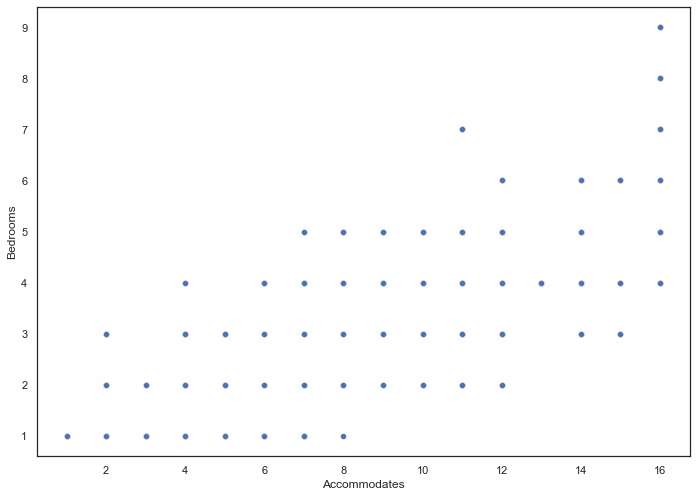

In [56]:
sns.set_style('white')
sns.scatterplot(x='Accommodates',y='Bedrooms',data = df)

In [57]:
# Predict number of bedrooms
from sklearn.linear_model import LinearRegression
X = df.dropna().Accommodates.to_numpy().reshape(-1,1)
y = df.dropna().Bedrooms.to_numpy().reshape(-1,1)
reg = LinearRegression().fit(X, y)
reg.score(X,y)

0.7830275914335578

In [58]:
# Update Bedroom NaN with predicted value
pred_bdrms = np.rint(reg.predict(df.Accommodates[df.Bedrooms.isnull()].to_numpy().reshape(-1,1)))
a = 0
for i in df.Bedrooms[df.Bedrooms.isnull()].index:
    df.at[i,'Bedrooms'] = pred_bdrms[a]
    a+=1

<AxesSubplot:xlabel='Accommodates', ylabel='Beds'>

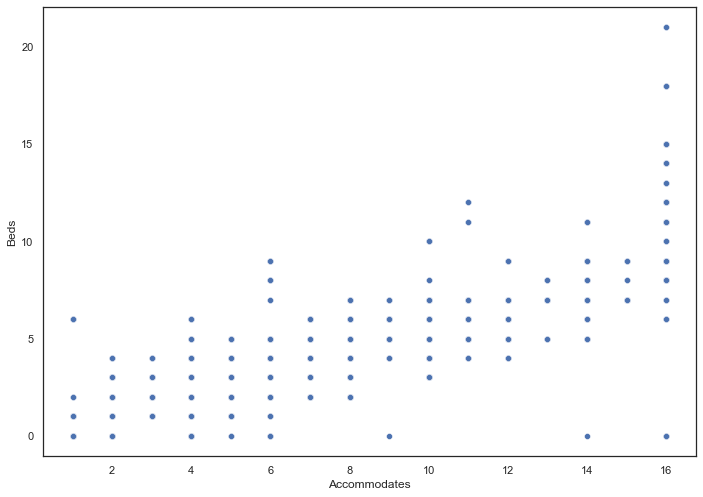

In [59]:
sns.scatterplot(y='Beds',x='Accommodates',data = df)

In [60]:
# Predict number of Beds
X = df.dropna().Accommodates.to_numpy().reshape(-1,1)
y = df.dropna().Beds.to_numpy().reshape(-1,1)
reg = LinearRegression().fit(X, y)
reg.score(X,y)

0.7827665440425944

In [61]:
# Update Beds information
pred_beds = np.rint(reg.predict(df.Accommodates[df.Beds.isnull()].to_numpy().reshape(-1,1)))
a = 0
for i in df.Beds[df.Beds.isnull()].index:
    df.at[i,'Beds'] = pred_beds[a]
    a+=1

Now I will handle the missing value in review score. I believe review score is of vital importance in terms of the choosing decision. So I will drop missing value in the training set and replace the missing value with the overall mean in the testing set

In [62]:
df.isnull().sum()

Decision                  2440
Host_response_time           0
Host_is_superhost            0
Host_has_profile_pic         0
Host_identity_verified       0
Neighbourhood                0
Property_type                0
Room_type                    0
Accommodates                 0
Bathrooms_text               0
Bedrooms                     0
Beds                         0
Essentials                   0
Cooking                      0
Balcony                      0
Parking                      0
Price                        0
Number_of_reviews            0
Review_scores_rating       669
Instant_bookable             0
Month                        0
dtype: int64

In [63]:
# Record of number of will be dropped in the training set
train_idx = df[:len(df1)].isnull().sum()['Review_scores_rating']

In [64]:
# Fill in missing review score with the mean
df["Review_scores_rating"][len(df1):] = df[len(df1):]["Review_scores_rating"].fillna(df.dropna().Review_scores_rating.mean())

<ipython-input-64-761f1468e230>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Review_scores_rating"][len(df1):] = df[len(df1):]["Review_scores_rating"].fillna(df.dropna().Review_scores_rating.mean())


In [65]:
# Index for training set
train_index = len(df1)-train_idx
train_index
train_label = df.Decision[:train_index]
# There will be 7076 samples in our training set

In [66]:
# Drop sample with missing review score in the training set
df = df.drop(columns = 'Decision').dropna()
df.shape

(9516, 20)

In [67]:
# Please ignore
#df_no_encode = pd.concat([df1,df2],axis = 0,ignore_index=True)
#print(df1.shape, df2.shape)

#PriceValue=[]
#for c in df_no_encode.Price:
    #PriceValue.append(float(c[1:].strip().replace(',', '')))
#df_no_encode['Price'] = np.array(PriceValue)

#df_no_encode.drop(columns = 'Host_response_time')

#a = 0
#for i in df_no_encode.Bedrooms[df.Bedrooms.isnull()].index:
   # df_no_encode.at[i,'Bedrooms'] = pred_bdrms[a]
   # a+=1

#a = 0
#for i in df_no_encode.Beds[df.Beds.isnull()].index:
 #   df_no_encode.at[i,'Beds'] = pred_beds[a]
  #  a+=1
    
#df_no_encode["Review_scores_rating"] = df_no_encode["Review_scores_rating"].fillna(df_no_encode.dropna().Review_scores_rating.mean())

#df_no_encode.fillna({'Host_is_superhost':'t'}, inplace=True)
#df_no_encode.fillna({'Host_has_profile_pic':'t'}, inplace=True)
#df_no_encode.fillna({'Host_identity_verified':'t'}, inplace=True)


# Exploring and Visualizing Data
Exploring the data by analyzing its statistics and visualizing the values of features and correlations between different features. Explaining the process and the results
Now that we are ready for an exploration of our data, we can make a rule that we are going to be working from left to right. The reason some may prefer to do this is due to its set approach - some datasets have a big number of attributes, plus this way we will remember to explore each column individually to make sure we learn as much as we can about our dataset.

Now we will do histogram for the variables, then we will do the variable-wise encoding and outlier wiping. Note that we will do outliers wiping at last, since the df now contains both training sets with label and testing set without lable. We only want to remove outliers that lie in training set.

In [68]:
df.columns

Index(['Host_response_time', 'Host_is_superhost', 'Host_has_profile_pic',
       'Host_identity_verified', 'Neighbourhood', 'Property_type', 'Room_type',
       'Accommodates', 'Bathrooms_text', 'Bedrooms', 'Beds', 'Essentials',
       'Cooking', 'Balcony', 'Parking', 'Price', 'Number_of_reviews',
       'Review_scores_rating', 'Instant_bookable', 'Month'],
      dtype='object')

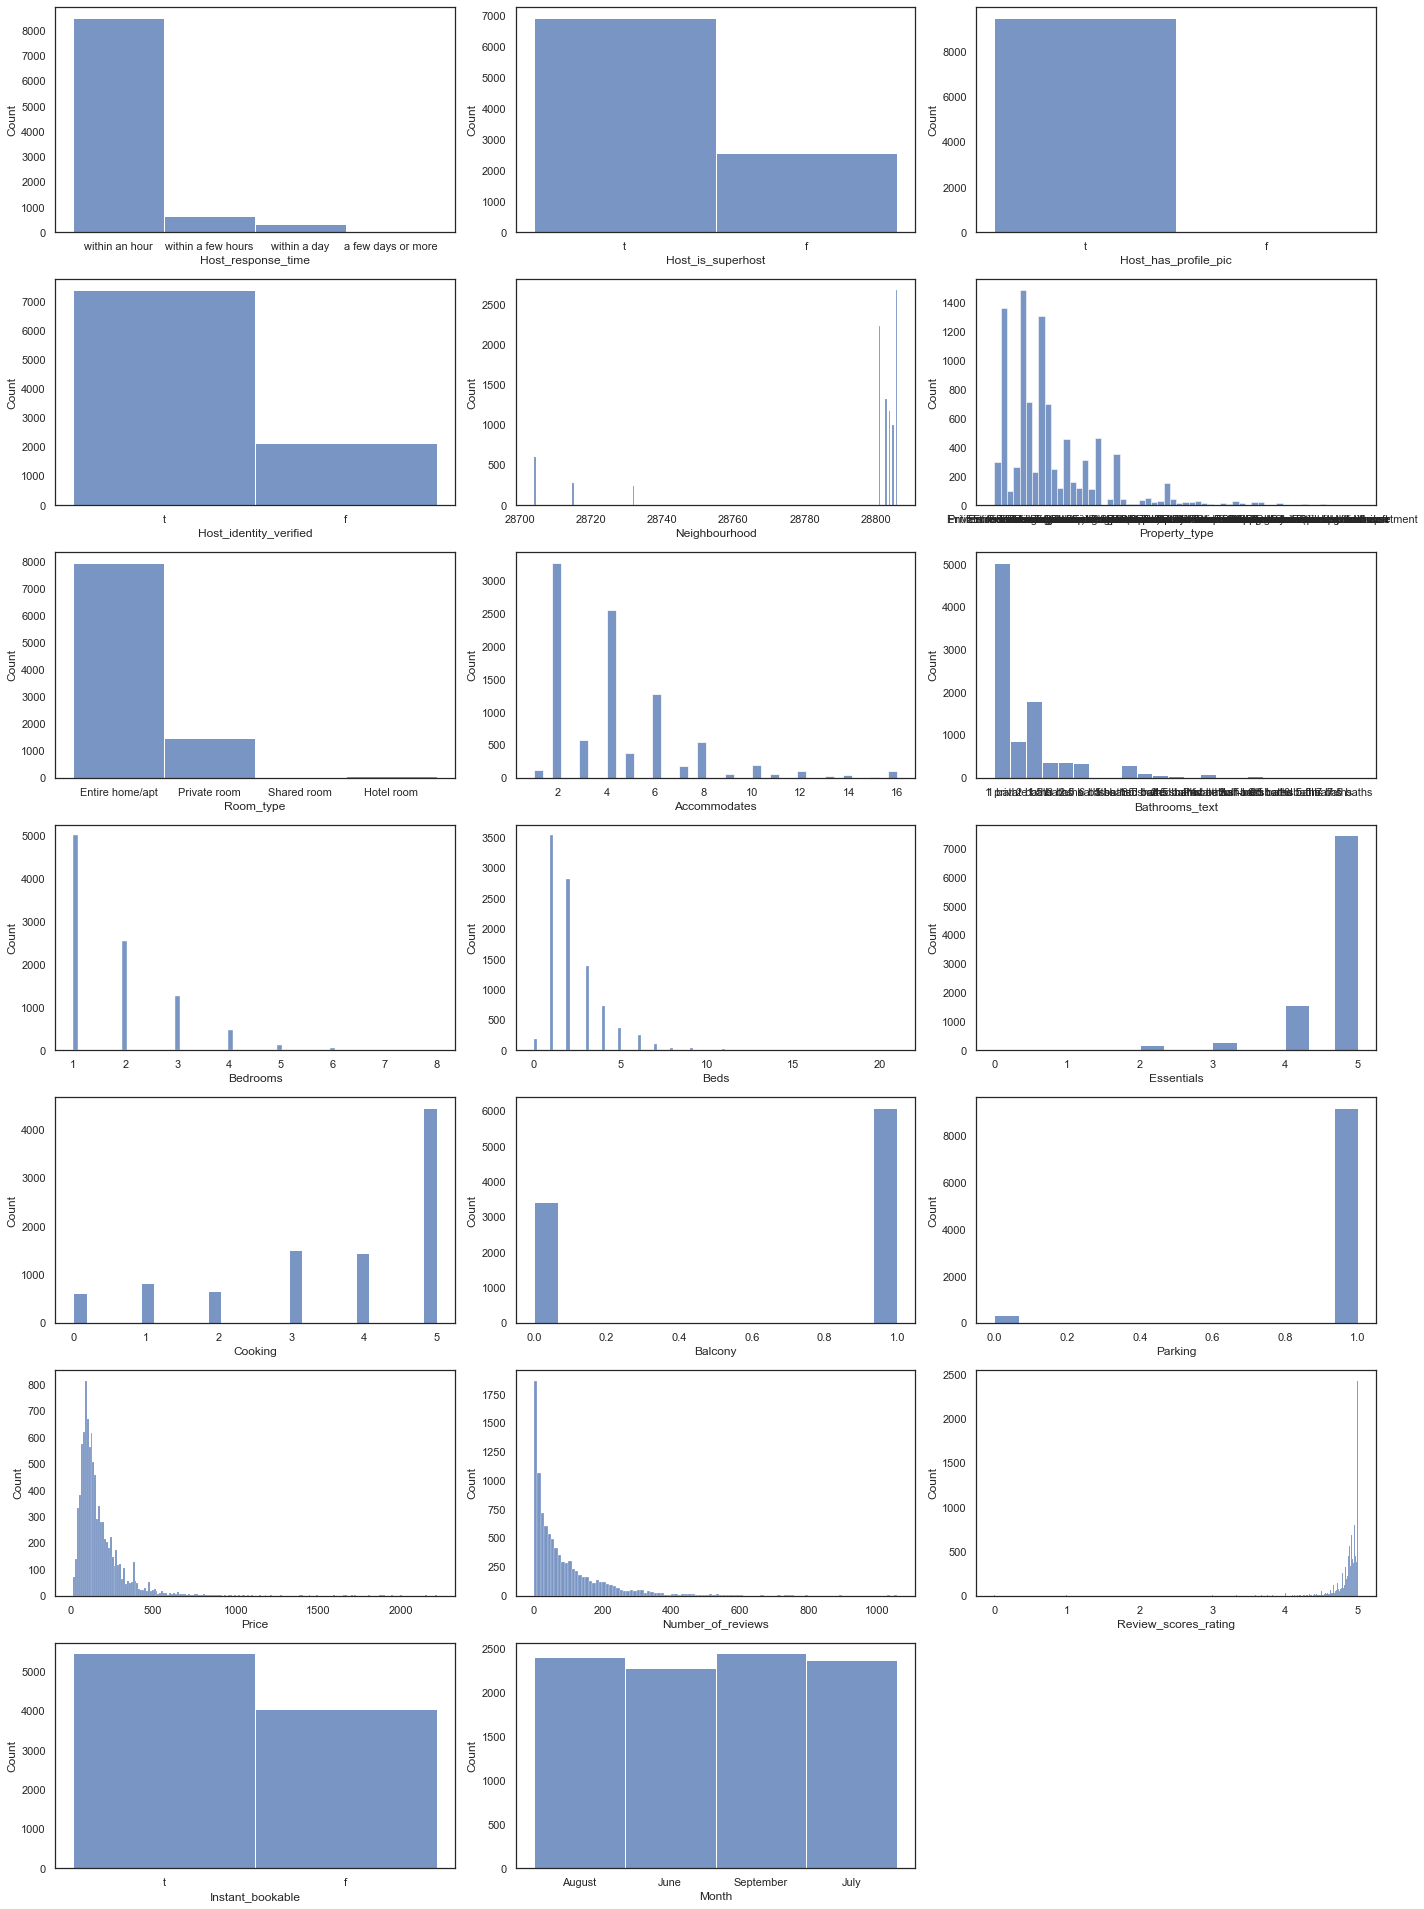

In [24]:
c = 1 
nrows = round(len(df.columns) / 3) + 1
fig = plt.figure(figsize=(20,30))
for i in df.columns:
    plt.subplot(nrows, 3, c)
    sns.histplot(df[i])
    c += 1 
plt.tight_layout()
plt.show()

Handle Binary variables: 

Note that four variables are in binary form, and one of them ('Host_has_profile_pic') has only 15 'f' but 9896 't' after our handeling of missing data. So I will drop this variable and encode other three of them.

In [69]:
# Using 0-1 to denote false or ture
df['Host_is_superhost'] = df['Host_is_superhost'].map({'f':0, 't':1})
df['Host_identity_verified'] = df['Host_identity_verified'].map({'f':0, 't':1})
df['Instant_bookable'] = df['Instant_bookable'].map({'f':0, 't':1})
df['Host_has_profile_pic'] = df['Host_has_profile_pic'].map({'f':0, 't':1})


We now turn to encode the left categorical variables, which have multiple outcomes, we will use one-hot encoding. Note that for some of the variables, we don't cover all subsets. For example, 'Property_type' has 58 unique types, it is not meaningful to cover each of them with a dummy variable. Instead, I will make some of the most frequent types dummies and see the others as 'others'. It is convineint to practice since to avoid multicolinearity, I do not have to specify the 'others' specifically.

In [70]:
df.Property_type.describe()

count                        9516
unique                         58
top       Entire residential home
freq                         1487
Name: Property_type, dtype: object

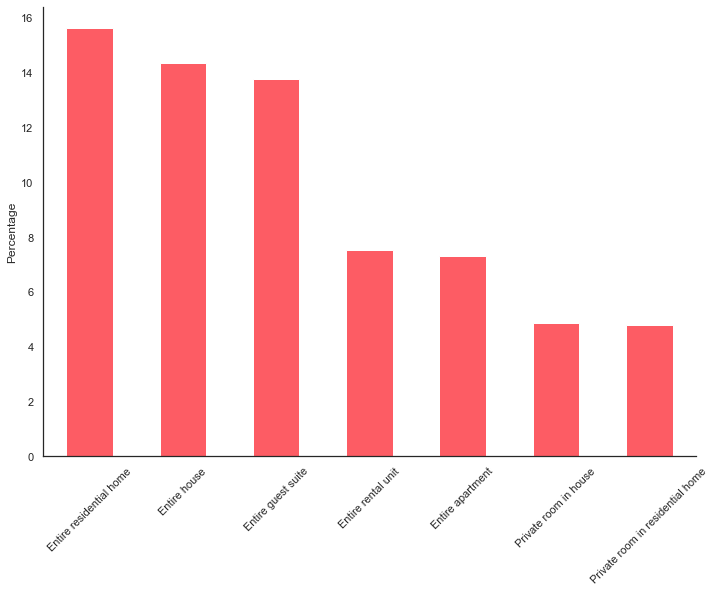

In [71]:
proptype_percentage = df.Property_type.value_counts() / df.shape[0] * 100
proptype_percentage2 = proptype_percentage[proptype_percentage>4]
proptype_percentage2.plot(kind='bar',color='#FD5C64', rot=45)
plt.ylabel('Percentage')
sns.despine()

Including these 7 categories as dummies will cover about 70 percent of all the cases.

In [72]:
# Property_type
dummies_porperty_type = pd.get_dummies(df['Property_type'], prefix= 'is' )
df['is_Entire residential home'] = dummies_porperty_type['is_Entire residential home']
df['is_Entire house'] = dummies_porperty_type['is_Entire house']
df['is_Entire guest suite'] = dummies_porperty_type['is_Entire guest suite']
df['is_Entire rental unit'] = dummies_porperty_type['is_Entire rental unit']
df['is_Entire apartment'] = dummies_porperty_type['is_Entire apartment']
df['is_Private room in house'] = dummies_porperty_type['is_Private room in house']
df['is_Private room in residential home'] = dummies_porperty_type['is_Private room in residential home']

In [73]:
# Host_response_time
dummies_response_time = pd.get_dummies(df['Host_response_time'], prefix= 'is' )
df['is_within an hour'] = dummies_response_time['is_within an hour']
df['is_within a few hours'] = dummies_response_time['is_within a few hours']


In [74]:
# Neighbourhood

In [75]:
dummies_neighbour = pd.get_dummies(df['Neighbourhood'], prefix= 'is' )
df['is_28805'] = dummies_neighbour['is_28805']
df['is_28804'] = dummies_neighbour['is_28804']
df['is_28806'] = dummies_neighbour['is_28806']
df['is_28803'] = dummies_neighbour['is_28803']
df['is_28704'] = dummies_neighbour['is_28704']
df['is_28801'] = dummies_neighbour['is_28801']

In [76]:
# Room_type

In [77]:
room_type_percentage = df.Room_type.value_counts() / df.shape[0] * 100
room_type_percentage

Entire home/apt    83.732661
Private room       15.384615
Hotel room          0.546448
Shared room         0.336276
Name: Room_type, dtype: float64

In [78]:
dummies_room_type = pd.get_dummies(df['Room_type'], prefix= 'is' )
df['is_Entire home/apt'] = dummies_room_type['is_Entire home/apt']
df['is_Private room'] = dummies_room_type['is_Private room']

In [79]:
# Bathrooms_text

In [80]:
btrmtext_percentage = df.Bathrooms_text.value_counts() / df.shape[0] * 100
btrmtext_percentage

1 bath               52.900378
2 baths              18.883985
1 private bath        8.984868
3 baths               3.898697
1.5 baths             3.804119
2.5 baths             3.741068
1 shared bath         3.142077
3.5 baths             1.208491
4 baths               0.903741
1.5 shared baths      0.567465
2 shared baths        0.409836
4.5 baths             0.346784
2.5 shared baths      0.252207
5 baths               0.252207
0 baths               0.157629
6 baths               0.126103
Half-bath             0.115595
5.5 baths             0.094578
6.5 baths             0.063052
0 shared baths        0.052543
Private half-bath     0.042034
7 baths               0.042034
7.5 baths             0.010509
Name: Bathrooms_text, dtype: float64

In [81]:
dummies_btrmtext = pd.get_dummies(df['Bathrooms_text'], prefix= 'is' )
df['is_1 bath'] = dummies_btrmtext['is_1 bath']
df['is_2 baths'] = dummies_btrmtext['is_2 baths']
df['is_1 private bath'] = dummies_btrmtext['is_1 private bath']
df['is_3 baths'] = dummies_btrmtext['is_3 baths']
df['is_1.5 baths'] = dummies_btrmtext['is_1.5 baths']
df['is_2.5 baths'] = dummies_btrmtext['is_2.5 baths']


In [82]:
# Month
dummies_month = pd.get_dummies(df['Month'], prefix= 'is' )
df['is_August'] = dummies_month['is_August']
df['is_July'] = dummies_month['is_July']
df['is_June'] = dummies_month['is_June']


In [83]:
# Drop the original categorical data
df_final = df.drop(['Host_has_profile_pic','Property_type', 'Month','Bathrooms_text','Room_type','Neighbourhood','Host_response_time'], axis=1)

In [84]:
X_raw, Z_raw= df_final[:train_index],df_final[train_index:]

# Add Decisions back 
#df_train = pd.read_csv('train.csv', index_col=False)
#label = df_train['Decision'].to_numpy()
#X_raw.loc[:,'Decision'] = pd.Series(train_label, index = X_raw.index)

In [85]:
df_final.columns

Index(['Host_is_superhost', 'Host_identity_verified', 'Accommodates',
       'Bedrooms', 'Beds', 'Essentials', 'Cooking', 'Balcony', 'Parking',
       'Price', 'Number_of_reviews', 'Review_scores_rating',
       'Instant_bookable', 'is_Entire residential home', 'is_Entire house',
       'is_Entire guest suite', 'is_Entire rental unit', 'is_Entire apartment',
       'is_Private room in house', 'is_Private room in residential home',
       'is_within an hour', 'is_within a few hours', 'is_28805', 'is_28804',
       'is_28806', 'is_28803', 'is_28704', 'is_28801', 'is_Entire home/apt',
       'is_Private room', 'is_1 bath', 'is_2 baths', 'is_1 private bath',
       'is_3 baths', 'is_1.5 baths', 'is_2.5 baths', 'is_August', 'is_July',
       'is_June'],
      dtype='object')

# Drop the outliers and split the training and testing data

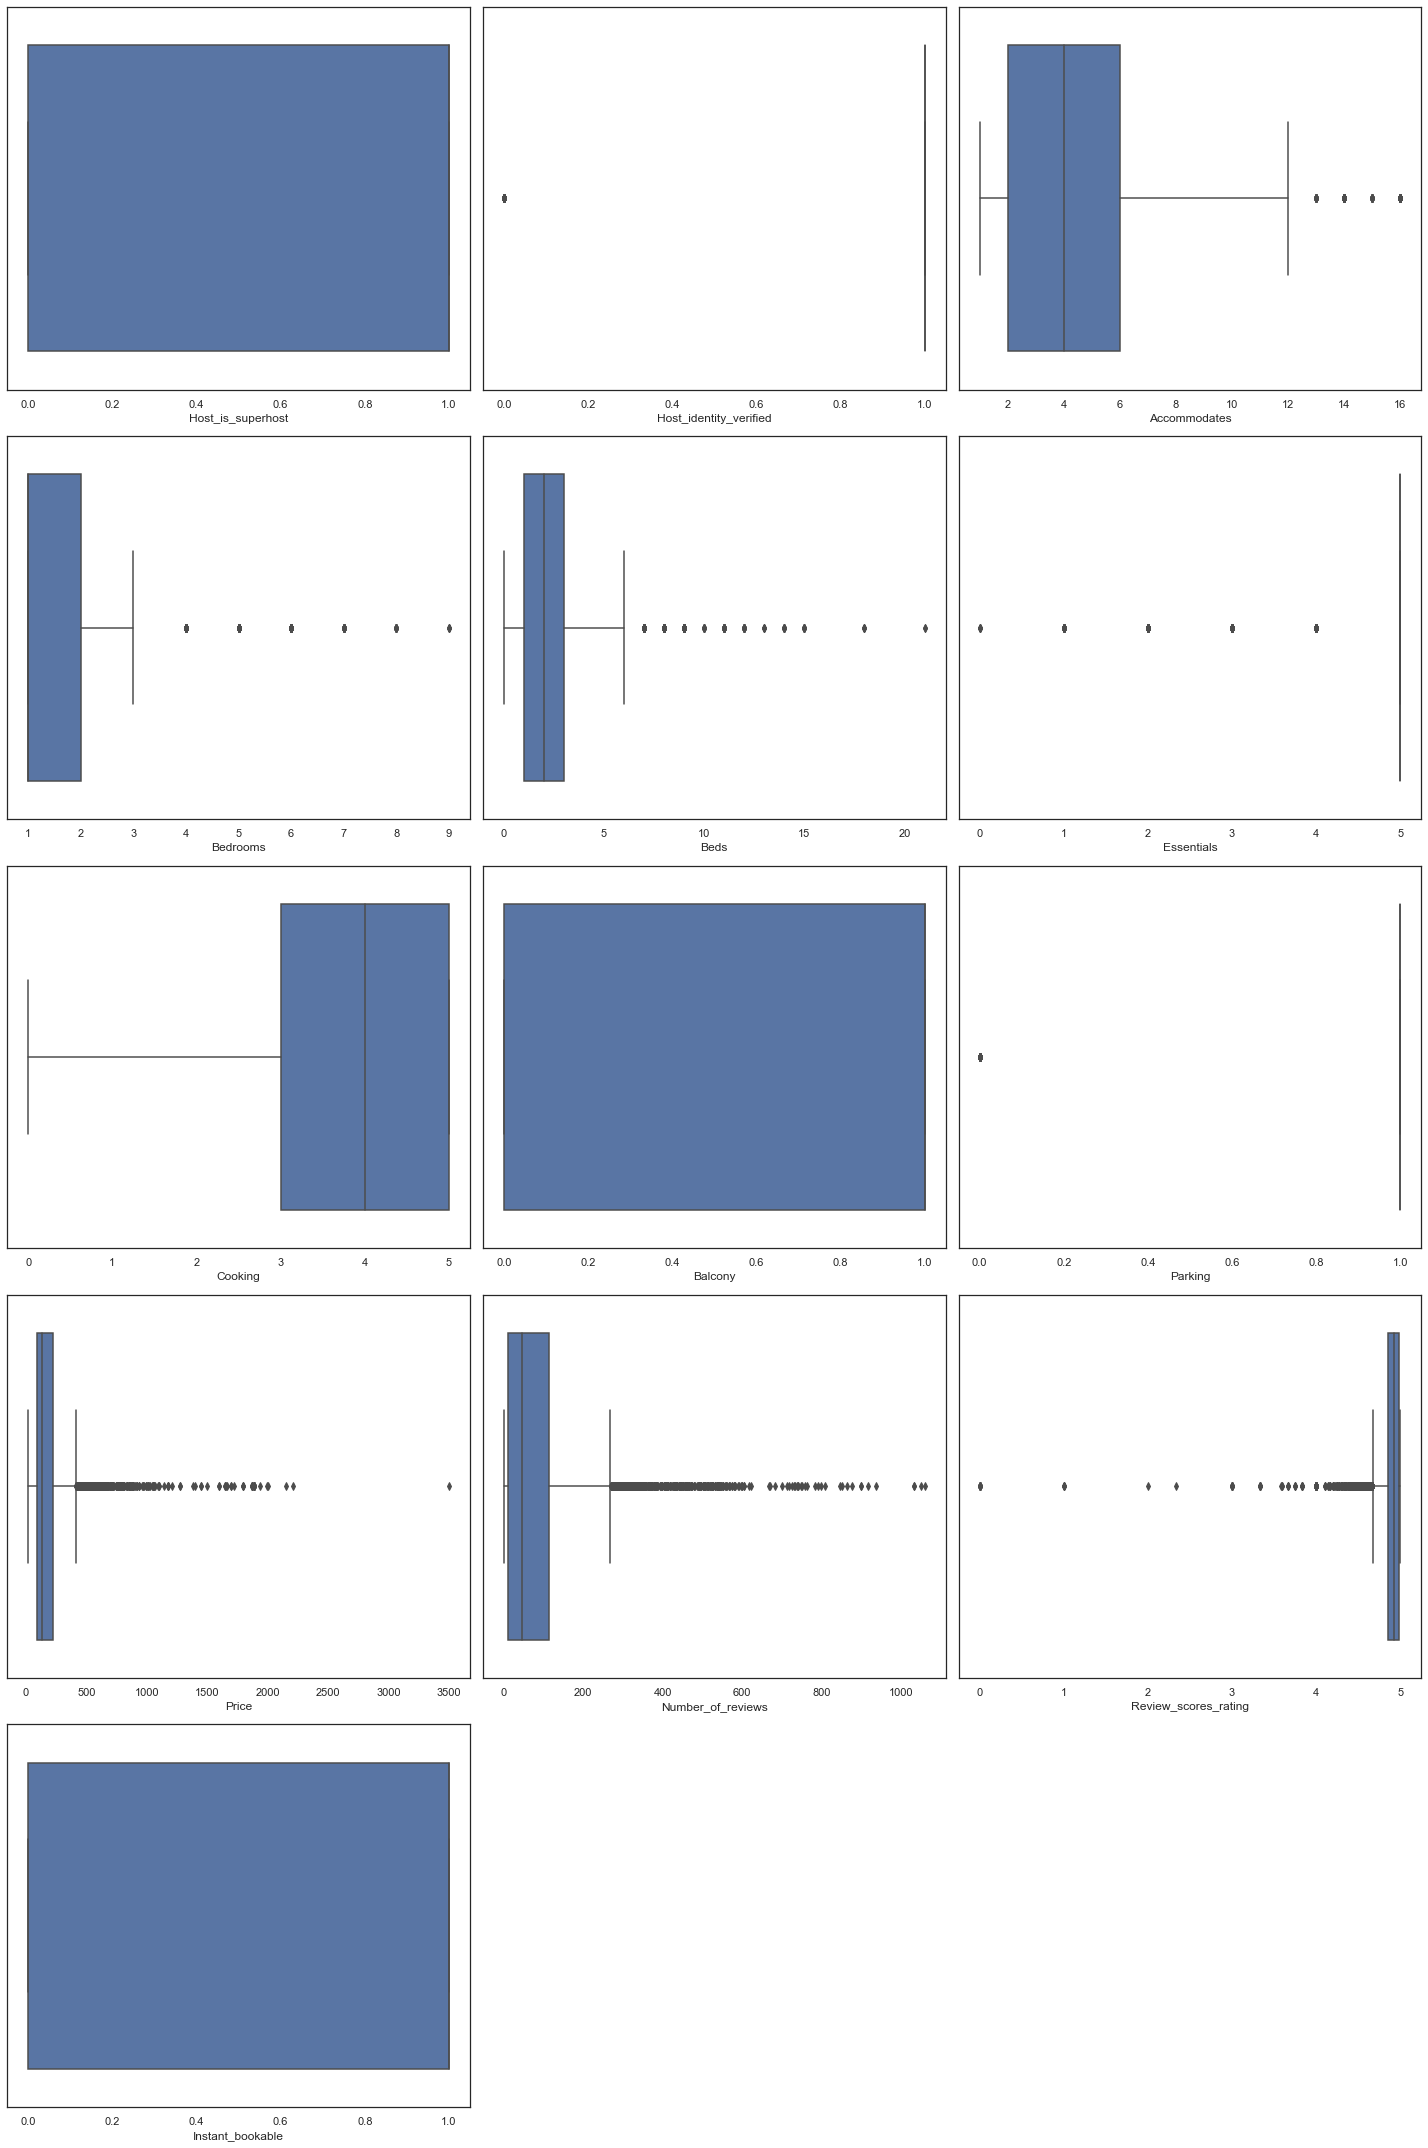

In [97]:
# visualizing the outliers

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns 

var_num = df_final.select_dtypes(include=['float', 'int']).columns
c = 1 
nrows = round(len(var_num) / 3) + 1
fig = plt.figure(figsize=(20,30))
for i in var_num:
    plt.subplot(nrows, 3, c)
    sns.boxplot(df[i])
    c += 1 
plt.tight_layout()
plt.show()

Now we are left with 10 numerical variables untreated. In the following section, we will drop the outliers in terms of these variables. Specifically, we will drop outliers in Price, Review_Scores and Number of reviews. Samples in the training set with extremely high price, low rating score and high number of reviews will be dropped.

Drop the outliers

In [90]:
Xdf = X_raw.drop(X_raw[(df.Price>500) | (df.Review_scores_rating<4) | (df.Number_of_reviews>500)].index)

<ipython-input-90-65fd2558d804>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  Xdf = X_raw.drop(X_raw[(df.Price>500) | (df.Review_scores_rating<4) | (df.Number_of_reviews>500)].index)


In [91]:
Xdf.shape

(6768, 39)

Rescaling the data for SVM with Gaussian Kernel

In [93]:
X = Xdf.to_numpy()
y = train_label
Z = Z_raw.to_numpy()
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=42)

In [215]:
ytest.shape

(1406,)

# Logistic regression

Logistic regression does not really have any critical hyperparameters to tune.
Sometimes, we can see useful differences in performance or convergence with different solvers (solver).



In [216]:
# I conduct a grid searching key hyperparametres for logistic regression
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
# define models and parameters
model = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2','l1','elasticnet']
c_values = [100, 10, 1.0, 0.1, 0.01]
# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X, y)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.696450 using {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.696450 (0.014534) with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.692134 (0.012961) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.695454 (0.014738) with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.000000 (0.000000) with: {'C': 100, 'penalty': 'l1', 'solver': 'newton-cg'}
0.000000 (0.000000) with: {'C': 100, 'penalty': 'l1', 'solver': 'lbfgs'}
0.695264 (0.014683) with: {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}
0.000000 (0.000000) with: {'C': 100, 'penalty': 'elasticnet', 'solver': 'newton-cg'}
0.000000 (0.000000) with: {'C': 100, 'penalty': 'elasticnet', 'solver': 'lbfgs'}
0.000000 (0.000000) with: {'C': 100, 'penalty': 'elasticnet', 'solver': 'liblinear'}
0.696308 (0.014600) with: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.691232 (0.012271) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.694980 (0.014103) with: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}

In [797]:
# Try training on normalized data
# define models and parameters
model = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2','l1','elasticnet']
c_values = [100, 10, 1.0, 0.1, 0.01]
# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(Xdf_norm.drop(columns = ['Decision']).to_numpy(), y)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.696545 using {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.696355 (0.014451) with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.696355 (0.014451) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.696355 (0.014451) with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.000000 (0.000000) with: {'C': 100, 'penalty': 'l1', 'solver': 'newton-cg'}
0.000000 (0.000000) with: {'C': 100, 'penalty': 'l1', 'solver': 'lbfgs'}
0.696308 (0.014461) with: {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}
0.000000 (0.000000) with: {'C': 100, 'penalty': 'elasticnet', 'solver': 'newton-cg'}
0.000000 (0.000000) with: {'C': 100, 'penalty': 'elasticnet', 'solver': 'lbfgs'}
0.000000 (0.000000) with: {'C': 100, 'penalty': 'elasticnet', 'solver': 'liblinear'}
0.696307 (0.014119) with: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.696355 (0.014356) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.696545 (0.014154) with: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}


It seems that logistic regression, though intuitive and direct, doesn't provides us with a satisfying accuracy in this binary classification.

# Catboost Part 1 - A simple wonder & Visualization

Let's fist have some fun with Catboost with a tune parameter on the tree depth

In [98]:
from catboost import CatBoostClassifier
depth_list = [2, 3, 4, 5, 6, 7, 8] 
acc_score_list = [] 
for depth in depth_list:
    catbst = CatBoostClassifier(iterations = 8000, 
                                learning_rate = 0.005,
                                depth = depth,
                                loss_function='Logloss', 
                                leaf_estimation_method = 'Gradient', 
                                eval_metric = 'Accuracy', 
                                custom_metric = 'Accuracy', 
                                use_best_model = True,
                                random_seed = 76, verbose = False)
    catbst.fit(Xtrain, ytrain, eval_set=(Xtest, ytest), plot=True)
    y_predict = catbst.predict(Xtest) 
    acc_score_list.append(accuracy_score(ytest, y_predict))
    cm = confusion_matrix(ytest, y_predict) 
    print(cm)

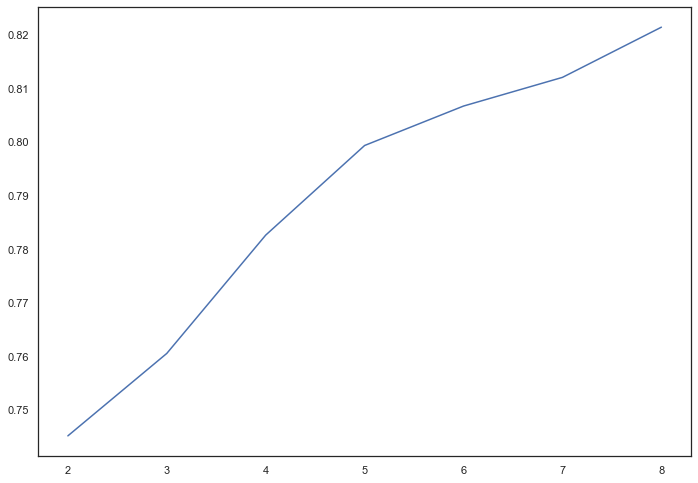

In [857]:
plt.plot(depth_list, acc_score_list) 

# Catboost Part 2 - hyperparameter tuning

In [95]:
# define a function for parameter tuning
# Credit: This function is derived from Competition Notebook: https://www.kaggle.com/richez/house-prices-catboost-optuna

def objective(trial):
    param = {
        "loss_function": trial.suggest_categorical("loss_function", ['Logloss', 'CrossEntropy']),
        "learning_rate": trial.suggest_loguniform("learning_rate", 1e-5, 1e0),
        "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 1e-2, 1e0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 1, 10),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 2, 20),
        "one_hot_max_size": trial.suggest_int("one_hot_max_size", 2, 20),    
        'random_state': trial.suggest_categorical('random_state', [6, 9, 12, 15])
    }
    # Conditional Hyper-Parameters
    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    catboost = CatBoostClassifier(**param)
    catboost.fit(Xtrain, ytrain, eval_set=[(Xtest, ytest)], verbose=0, early_stopping_rounds=100)
    y_pred = catboost.predict(Xtest)
    score = mean_squared_error(ytest, y_pred, squared=False)        
    return score   

In [96]:
'''
study = optuna.create_study(sampler=TPESampler(), direction="minimize")
study.optimize(objective, n_trials=10000, timeout=3600) # Run for 60 minutes     
print("Number of completed trials: {}".format(len(study.trials)))   
print("Best trial:")
trial = study.best_trial      
     
print("\tBest Score: {}".format(trial.value))                                                                 
print("\tBest Params: ")           
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))     
'''

[I 2021-12-09 08:40:00,470] A new study created in memory with name: no-name-9df61446-8d00-491a-ba4b-6f4d82972a69
[I 2021-12-09 08:40:02,091] Trial 0 finished with value: 0.5568658485285913 and parameters: {'loss_function': 'Logloss', 'learning_rate': 6.715576025882538e-05, 'l2_leaf_reg': 0.16728216749178879, 'colsample_bylevel': 0.08795416848159318, 'depth': 7, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'min_data_in_leaf': 19, 'one_hot_max_size': 3, 'random_state': 6, 'bagging_temperature': 6.169638693996269}. Best is trial 0 with value: 0.5568658485285913.
[I 2021-12-09 08:40:03,482] Trial 1 finished with value: 0.5891382910924179 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.0002623646447170715, 'l2_leaf_reg': 0.06266075575004597, 'colsample_bylevel': 0.025051467927384122, 'depth': 4, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'min_data_in_leaf': 10, 'one_hot_max_size': 3, 'random_state': 6, 'bagging_temperature': 3.8065940262071196

[I 2021-12-09 08:40:24,459] Trial 18 finished with value: 0.5663639612101129 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.002486742045142429, 'l2_leaf_reg': 0.03491865105582958, 'colsample_bylevel': 0.06844354951989869, 'depth': 3, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 9, 'one_hot_max_size': 6, 'random_state': 9}. Best is trial 13 with value: 0.4710691208760756.
[I 2021-12-09 08:40:25,429] Trial 19 finished with value: 0.4859329868508775 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.15963028551779798, 'l2_leaf_reg': 0.33522510477921386, 'colsample_bylevel': 0.03858784771569754, 'depth': 4, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 5, 'one_hot_max_size': 11, 'random_state': 6}. Best is trial 13 with value: 0.4710691208760756.
[I 2021-12-09 08:40:26,135] Trial 20 finished with value: 0.5651067699567265 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.007978609992672346, 'l2

[I 2021-12-09 08:40:52,724] Trial 37 finished with value: 0.5024831653266604 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.005207287255728508, 'l2_leaf_reg': 0.014695323640165545, 'colsample_bylevel': 0.08033562278697656, 'depth': 7, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 9, 'one_hot_max_size': 2, 'random_state': 9, 'subsample': 0.35159088232669833}. Best is trial 31 with value: 0.45180214453827944.
[I 2021-12-09 08:40:55,295] Trial 38 finished with value: 0.4565003867790752 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.011706956220692026, 'l2_leaf_reg': 0.010093758387063506, 'colsample_bylevel': 0.09278449227386959, 'depth': 9, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 11, 'one_hot_max_size': 14, 'random_state': 9, 'subsample': 0.6623935068141082}. Best is trial 31 with value: 0.45180214453827944.
[I 2021-12-09 08:41:02,325] Trial 39 finished with value: 0.47407917783

[I 2021-12-09 08:41:27,973] Trial 55 finished with value: 0.45727873412480935 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.046812533384257365, 'l2_leaf_reg': 0.027758503078354518, 'colsample_bylevel': 0.0901029447937672, 'depth': 7, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 7, 'one_hot_max_size': 20, 'random_state': 12, 'subsample': 0.9122519355138917}. Best is trial 52 with value: 0.4374047345985382.
[I 2021-12-09 08:41:28,630] Trial 56 finished with value: 0.5549467187013899 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.025352130716786412, 'l2_leaf_reg': 0.973385706553331, 'colsample_bylevel': 0.011972626750263594, 'depth': 7, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 8, 'one_hot_max_size': 19, 'random_state': 12, 'subsample': 0.7923235487855328}. Best is trial 52 with value: 0.4374047345985382.
[I 2021-12-09 08:41:28,998] Trial 57 finished with value: 0.52396344871596

[I 2021-12-09 08:41:53,403] Trial 73 finished with value: 0.4549396971278277 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.07373799363878161, 'l2_leaf_reg': 0.02233538630504128, 'colsample_bylevel': 0.09092396156894593, 'depth': 9, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 3, 'one_hot_max_size': 16, 'random_state': 12, 'subsample': 0.9893015646233425}. Best is trial 52 with value: 0.4374047345985382.
[I 2021-12-09 08:41:53,983] Trial 74 finished with value: 0.4718234354038612 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.15654741961004862, 'l2_leaf_reg': 0.013825053805577796, 'colsample_bylevel': 0.06981869616396898, 'depth': 10, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 6, 'one_hot_max_size': 18, 'random_state': 12, 'subsample': 0.8427778721692971}. Best is trial 52 with value: 0.4374047345985382.
[I 2021-12-09 08:41:55,582] Trial 75 finished with value: 0.44784929389547

[I 2021-12-09 08:42:15,301] Trial 91 finished with value: 0.46651762166385724 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.024581603609279176, 'l2_leaf_reg': 0.027368568057627045, 'colsample_bylevel': 0.09293177120484233, 'depth': 6, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 12, 'one_hot_max_size': 16, 'random_state': 12, 'subsample': 0.9620362043493064}. Best is trial 52 with value: 0.4374047345985382.
[I 2021-12-09 08:42:16,249] Trial 92 finished with value: 0.458055758872357 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.04835619675921308, 'l2_leaf_reg': 0.013835351883701918, 'colsample_bylevel': 0.09970795372561861, 'depth': 8, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 7, 'one_hot_max_size': 19, 'random_state': 12, 'subsample': 0.8641400370522846}. Best is trial 52 with value: 0.4374047345985382.
[I 2021-12-09 08:42:18,921] Trial 93 finished with value: 0.442255952101

[I 2021-12-09 08:42:56,316] Trial 109 finished with value: 0.4549396971278277 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.026332977471574436, 'l2_leaf_reg': 0.025410369584880643, 'colsample_bylevel': 0.08783280210870262, 'depth': 8, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 11, 'one_hot_max_size': 20, 'random_state': 9, 'subsample': 0.8487365482066359}. Best is trial 52 with value: 0.4374047345985382.
[I 2021-12-09 08:42:58,268] Trial 110 finished with value: 0.516443687640343 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.0008992841757686007, 'l2_leaf_reg': 0.023856598289358297, 'colsample_bylevel': 0.09694461466655463, 'depth': 8, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'min_data_in_leaf': 11, 'one_hot_max_size': 20, 'random_state': 12, 'bagging_temperature': 7.837696025153296}. Best is trial 52 with value: 0.4374047345985382.
[I 2021-12-09 08:42:59,649] Trial 111 finished with value: 0.44943

[I 2021-12-09 08:43:31,201] Trial 127 finished with value: 0.46422513790495384 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.010129351363253127, 'l2_leaf_reg': 0.015093765370359932, 'colsample_bylevel': 0.08987435447209755, 'depth': 9, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 9, 'one_hot_max_size': 20, 'random_state': 6, 'subsample': 0.8974749216162701}. Best is trial 52 with value: 0.4374047345985382.
[I 2021-12-09 08:43:33,616] Trial 128 finished with value: 0.4462583499902143 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.016049433571442537, 'l2_leaf_reg': 0.017694129710214952, 'colsample_bylevel': 0.08740610165951805, 'depth': 9, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 10, 'one_hot_max_size': 18, 'random_state': 6, 'subsample': 0.8556251407327525}. Best is trial 52 with value: 0.4374047345985382.
[I 2021-12-09 08:43:36,892] Trial 129 finished with value: 0.44546074729727

[I 2021-12-09 08:44:21,130] Trial 145 finished with value: 0.45727873412480935 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.04652142191896643, 'l2_leaf_reg': 0.026509583259980353, 'colsample_bylevel': 0.07678598824920294, 'depth': 9, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 8, 'one_hot_max_size': 16, 'random_state': 6, 'subsample': 0.9647883329896694}. Best is trial 52 with value: 0.4374047345985382.
[I 2021-12-09 08:44:22,874] Trial 146 finished with value: 0.43495883620084 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.03327726980872214, 'l2_leaf_reg': 0.019551103831852355, 'colsample_bylevel': 0.09713851978678467, 'depth': 10, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 11, 'one_hot_max_size': 17, 'random_state': 6, 'subsample': 0.8350294621988876}. Best is trial 146 with value: 0.43495883620084.
[I 2021-12-09 08:44:33,194] Trial 147 finished with value: 0.44784929389547357 and p

[I 2021-12-09 08:45:00,552] Trial 163 finished with value: 0.4462583499902143 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.0250523845779884, 'l2_leaf_reg': 0.028308997760388515, 'colsample_bylevel': 0.0970889830182227, 'depth': 9, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 12, 'one_hot_max_size': 20, 'random_state': 12, 'subsample': 0.9445512477262525}. Best is trial 146 with value: 0.43495883620084.
[I 2021-12-09 08:45:01,595] Trial 164 finished with value: 0.4672792835941314 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.0696911646857943, 'l2_leaf_reg': 0.02155303165047414, 'colsample_bylevel': 0.09064909447699565, 'depth': 10, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 13, 'one_hot_max_size': 17, 'random_state': 6, 'subsample': 0.856734929979364}. Best is trial 146 with value: 0.43495883620084.
[I 2021-12-09 08:45:04,106] Trial 165 finished with value: 0.4438612421421363 and 

[I 2021-12-09 08:45:46,330] Trial 181 finished with value: 0.4533736350032652 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.04226727715655279, 'l2_leaf_reg': 0.023115433889148447, 'colsample_bylevel': 0.09447870602703137, 'depth': 10, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 12, 'one_hot_max_size': 20, 'random_state': 12, 'subsample': 0.8943952595916048}. Best is trial 146 with value: 0.43495883620084.
[I 2021-12-09 08:45:47,306] Trial 182 finished with value: 0.4533736350032652 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.08615872281450065, 'l2_leaf_reg': 0.020100265376062236, 'colsample_bylevel': 0.09245205528359149, 'depth': 10, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 13, 'one_hot_max_size': 19, 'random_state': 12, 'subsample': 0.9449638125465869}. Best is trial 146 with value: 0.43495883620084.
[I 2021-12-09 08:45:50,771] Trial 183 finished with value: 0.454939697

[I 2021-12-09 08:46:25,069] Trial 199 finished with value: 0.4626905051502438 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.04169378544390005, 'l2_leaf_reg': 0.01696049212227124, 'colsample_bylevel': 0.08832547578274541, 'depth': 7, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 8, 'one_hot_max_size': 17, 'random_state': 6, 'subsample': 0.9174432598446104}. Best is trial 146 with value: 0.43495883620084.
[I 2021-12-09 08:46:30,272] Trial 200 finished with value: 0.4565003867790752 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.05103059126421325, 'l2_leaf_reg': 0.023195899157250014, 'colsample_bylevel': 0.09096804633871917, 'depth': 9, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 9, 'one_hot_max_size': 20, 'random_state': 9, 'subsample': 0.9406756642660178}. Best is trial 146 with value: 0.43495883620084.
[I 2021-12-09 08:46:32,626] Trial 201 finished with value: 0.45180214453827944 a

[I 2021-12-09 08:47:14,972] Trial 217 finished with value: 0.44784929389547357 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.027110532128113075, 'l2_leaf_reg': 0.031792024279267486, 'colsample_bylevel': 0.08961650732599506, 'depth': 10, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 13, 'one_hot_max_size': 19, 'random_state': 6, 'subsample': 0.9115685351776806}. Best is trial 146 with value: 0.43495883620084.
[I 2021-12-09 08:47:17,489] Trial 218 finished with value: 0.45022516889074815 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.014519770564139082, 'l2_leaf_reg': 0.0344500749204815, 'colsample_bylevel': 0.09450265950061519, 'depth': 9, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 12, 'one_hot_max_size': 19, 'random_state': 6, 'subsample': 0.7777602638138107}. Best is trial 146 with value: 0.43495883620084.
[I 2021-12-09 08:47:18,997] Trial 219 finished with value: 0.45727873412480935 an

[I 2021-12-09 08:48:04,276] Trial 235 finished with value: 0.4549396971278277 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.028673602217469195, 'l2_leaf_reg': 0.037512505802406726, 'colsample_bylevel': 0.09688703690209614, 'depth': 10, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 11, 'one_hot_max_size': 17, 'random_state': 6, 'subsample': 0.9085497465572013}. Best is trial 146 with value: 0.43495883620084.
[I 2021-12-09 08:48:06,871] Trial 236 finished with value: 0.4470545296597848 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.023553562123352145, 'l2_leaf_reg': 0.05706389598693787, 'colsample_bylevel': 0.09521988895373729, 'depth': 9, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 12, 'one_hot_max_size': 19, 'random_state': 12, 'subsample': 0.8458320083519506}. Best is trial 146 with value: 0.43495883620084.
[I 2021-12-09 08:48:10,396] Trial 237 finished with value: 0.493196961916071

[I 2021-12-09 08:48:54,348] Trial 253 finished with value: 0.4549396971278277 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.03255468740250633, 'l2_leaf_reg': 0.03397848548038263, 'colsample_bylevel': 0.09693793653077398, 'depth': 10, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 11, 'one_hot_max_size': 20, 'random_state': 12, 'subsample': 0.8440982016483538}. Best is trial 146 with value: 0.43495883620084.
[I 2021-12-09 08:48:55,275] Trial 254 finished with value: 0.46499055497527714 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.07123664204541955, 'l2_leaf_reg': 0.024740775375424812, 'colsample_bylevel': 0.09047861878069426, 'depth': 10, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 12, 'one_hot_max_size': 19, 'random_state': 12, 'subsample': 0.8760508528896417}. Best is trial 146 with value: 0.43495883620084.
[I 2021-12-09 08:48:57,984] Trial 255 finished with value: 0.45493969712782

[I 2021-12-09 08:49:29,867] Trial 271 finished with value: 0.4494346060878711 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.011050500006790028, 'l2_leaf_reg': 0.031028023934825427, 'colsample_bylevel': 0.09617824151001701, 'depth': 10, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 13, 'one_hot_max_size': 18, 'random_state': 12, 'subsample': 0.8150385495338186}. Best is trial 146 with value: 0.43495883620084.
[I 2021-12-09 08:49:31,357] Trial 272 finished with value: 0.4718234354038612 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.014689491929052645, 'l2_leaf_reg': 0.03540627048843028, 'colsample_bylevel': 0.09035307840214009, 'depth': 7, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 12, 'one_hot_max_size': 19, 'random_state': 12, 'subsample': 0.9151403375006003}. Best is trial 146 with value: 0.43495883620084.
[I 2021-12-09 08:49:34,550] Trial 273 finished with value: 0.52328429943672

[I 2021-12-09 08:50:08,596] Trial 289 finished with value: 0.46422513790495384 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.06576248436280842, 'l2_leaf_reg': 0.04622872821580086, 'colsample_bylevel': 0.09346142567897205, 'depth': 10, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 14, 'one_hot_max_size': 19, 'random_state': 12}. Best is trial 146 with value: 0.43495883620084.
[I 2021-12-09 08:50:09,560] Trial 290 finished with value: 0.5053061266698348 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.01784835248428981, 'l2_leaf_reg': 0.053111179665159484, 'colsample_bylevel': 0.034604552147510355, 'depth': 9, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 11, 'one_hot_max_size': 18, 'random_state': 9, 'subsample': 0.7596093613098213}. Best is trial 146 with value: 0.43495883620084.
[I 2021-12-09 08:50:12,143] Trial 291 finished with value: 0.458055758872357 and parameters: {'loss_function': 'Cro

[I 2021-12-09 08:50:49,653] Trial 307 finished with value: 0.4462583499902143 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.031956542442832934, 'l2_leaf_reg': 0.025935552541328958, 'colsample_bylevel': 0.09489696972805238, 'depth': 10, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 12, 'one_hot_max_size': 19, 'random_state': 12, 'subsample': 0.9084719760178805}. Best is trial 146 with value: 0.43495883620084.
[I 2021-12-09 08:50:50,412] Trial 308 finished with value: 0.46499055497527714 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.0993273414020643, 'l2_leaf_reg': 0.02138536591743158, 'colsample_bylevel': 0.07193998275848268, 'depth': 8, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 14, 'one_hot_max_size': 20, 'random_state': 12, 'subsample': 0.9730852497458594}. Best is trial 146 with value: 0.43495883620084.
[I 2021-12-09 08:50:52,049] Trial 309 finished with value: 0.4541573410

[I 2021-12-09 08:51:15,435] Trial 325 finished with value: 0.4672792835941314 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.21308740355371453, 'l2_leaf_reg': 0.013291291741261676, 'colsample_bylevel': 0.0960163079196518, 'depth': 7, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 6, 'one_hot_max_size': 19, 'random_state': 12, 'subsample': 0.7768836031599358}. Best is trial 146 with value: 0.43495883620084.
[I 2021-12-09 08:51:15,974] Trial 326 finished with value: 0.46499055497527714 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.1392477123128386, 'l2_leaf_reg': 0.030173717120023112, 'colsample_bylevel': 0.0921658336808138, 'depth': 6, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 8, 'one_hot_max_size': 19, 'random_state': 6, 'subsample': 0.8517471603823336}. Best is trial 146 with value: 0.43495883620084.
[I 2021-12-09 08:51:16,576] Trial 327 finished with value: 0.4703135965391772 and 

[I 2021-12-09 08:51:31,323] Trial 343 finished with value: 0.4672792835941314 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.046151451622567154, 'l2_leaf_reg': 0.039631727104070966, 'colsample_bylevel': 0.09275676601355706, 'depth': 6, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 14, 'one_hot_max_size': 9, 'random_state': 6, 'subsample': 0.7833306164717267}. Best is trial 146 with value: 0.43495883620084.
[I 2021-12-09 08:51:33,044] Trial 344 finished with value: 0.4422559521015795 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.03067601695715929, 'l2_leaf_reg': 0.02792844920645969, 'colsample_bylevel': 0.09996589892734187, 'depth': 9, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 12, 'one_hot_max_size': 19, 'random_state': 12, 'subsample': 0.8621053843121533}. Best is trial 146 with value: 0.43495883620084.
[I 2021-12-09 08:51:34,681] Trial 345 finished with value: 0.44466171392

[I 2021-12-09 08:52:00,788] Trial 361 finished with value: 0.45415734109382927 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.04350029511696358, 'l2_leaf_reg': 0.023274563634420205, 'colsample_bylevel': 0.0884018849605446, 'depth': 9, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'min_data_in_leaf': 12, 'one_hot_max_size': 17, 'random_state': 15, 'bagging_temperature': 1.0603524209986381}. Best is trial 146 with value: 0.43495883620084.
[I 2021-12-09 08:52:03,453] Trial 362 finished with value: 0.4494346060878711 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.02208573284323813, 'l2_leaf_reg': 0.03065644208572687, 'colsample_bylevel': 0.09668326416309848, 'depth': 9, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 13, 'one_hot_max_size': 3, 'random_state': 12, 'subsample': 0.8871590166731967}. Best is trial 146 with value: 0.43495883620084.
[I 2021-12-09 08:52:04,233] Trial 363 finished with value: 0.5280200

[I 2021-12-09 08:52:33,733] Trial 379 finished with value: 0.4510143459537019 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.03431480322767466, 'l2_leaf_reg': 0.02472571314452987, 'colsample_bylevel': 0.0695122580832602, 'depth': 9, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 14, 'one_hot_max_size': 20, 'random_state': 12, 'subsample': 0.9690523163348805}. Best is trial 146 with value: 0.43495883620084.
[I 2021-12-09 08:52:36,032] Trial 380 finished with value: 0.45022516889074815 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.022392797636831503, 'l2_leaf_reg': 0.017035582565776742, 'colsample_bylevel': 0.0985313428360584, 'depth': 9, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 13, 'one_hot_max_size': 20, 'random_state': 12, 'subsample': 0.9361652462190488}. Best is trial 146 with value: 0.43495883620084.
[I 2021-12-09 08:52:43,265] Trial 381 finished with value: 0.447849293895

[I 2021-12-09 08:53:11,996] Trial 397 finished with value: 0.46499055497527714 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.022392604373391654, 'l2_leaf_reg': 0.01565800029666023, 'colsample_bylevel': 0.09999275220355612, 'depth': 6, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 12, 'one_hot_max_size': 19, 'random_state': 9, 'subsample': 0.6630349987653389}. Best is trial 146 with value: 0.43495883620084.
[I 2021-12-09 08:53:15,463] Trial 398 finished with value: 0.44466171392340825 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.014956441429954882, 'l2_leaf_reg': 0.04570043629412896, 'colsample_bylevel': 0.09394602069961454, 'depth': 10, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 12, 'one_hot_max_size': 20, 'random_state': 6, 'subsample': 0.6845430090060642}. Best is trial 146 with value: 0.43495883620084.
[I 2021-12-09 08:53:17,293] Trial 399 finished with value: 0.451014345953701

[I 2021-12-09 08:53:51,885] Trial 415 finished with value: 0.532045624200069 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.5930033679175912, 'l2_leaf_reg': 0.033099417627695533, 'colsample_bylevel': 0.09386687624215419, 'depth': 9, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 4, 'one_hot_max_size': 14, 'random_state': 12, 'subsample': 0.968353485895857}. Best is trial 146 with value: 0.43495883620084.
[I 2021-12-09 08:53:54,223] Trial 416 finished with value: 0.4770702433286961 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.007888142909786951, 'l2_leaf_reg': 0.02394813661555693, 'colsample_bylevel': 0.08756402669449159, 'depth': 9, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 15, 'one_hot_max_size': 17, 'random_state': 6, 'subsample': 0.9247478150528584}. Best is trial 146 with value: 0.43495883620084.
[I 2021-12-09 08:53:55,406] Trial 417 finished with value: 0.4525885718428285

[I 2021-12-09 08:54:33,894] Trial 433 finished with value: 0.47855876564575317 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.009425104266672785, 'l2_leaf_reg': 0.017871072756250415, 'colsample_bylevel': 0.08536966108345263, 'depth': 8, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 11, 'one_hot_max_size': 16, 'random_state': 12, 'subsample': 0.9406969027392067}. Best is trial 146 with value: 0.43495883620084.
[I 2021-12-09 08:54:35,867] Trial 434 finished with value: 0.45415734109382927 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.029351853602752095, 'l2_leaf_reg': 0.027652621005969234, 'colsample_bylevel': 0.09696280508895248, 'depth': 9, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 11, 'one_hot_max_size': 20, 'random_state': 12, 'subsample': 0.9775839194059908}. Best is trial 146 with value: 0.43495883620084.
[I 2021-12-09 08:54:37,341] Trial 435 finished with value: 0.4525885

[I 2021-12-09 08:55:10,723] Trial 451 finished with value: 0.45727873412480935 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.012468506892280809, 'l2_leaf_reg': 0.013949175559698672, 'colsample_bylevel': 0.08991344824555117, 'depth': 9, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 10, 'one_hot_max_size': 20, 'random_state': 12, 'subsample': 0.9847155488134578}. Best is trial 146 with value: 0.43495883620084.
[I 2021-12-09 08:55:12,840] Trial 452 finished with value: 0.4565003867790752 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.02735199675390754, 'l2_leaf_reg': 0.03063173397044594, 'colsample_bylevel': 0.09199552727338008, 'depth': 9, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'min_data_in_leaf': 11, 'one_hot_max_size': 20, 'random_state': 12, 'bagging_temperature': 6.114284360812725}. Best is trial 146 with value: 0.43495883620084.
[I 2021-12-09 08:55:14,164] Trial 453 finished with value: 0.45

[I 2021-12-09 08:55:50,753] Trial 469 finished with value: 0.45180214453827944 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.03319001202273714, 'l2_leaf_reg': 0.016741786803690154, 'colsample_bylevel': 0.09451980124506972, 'depth': 10, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 9, 'one_hot_max_size': 18, 'random_state': 6, 'subsample': 0.9370061800815882}. Best is trial 146 with value: 0.43495883620084.
[I 2021-12-09 08:55:52,748] Trial 470 finished with value: 0.4398370317620449 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.027067164855374665, 'l2_leaf_reg': 0.023062033729932145, 'colsample_bylevel': 0.0980359553463093, 'depth': 9, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 12, 'one_hot_max_size': 20, 'random_state': 12}. Best is trial 146 with value: 0.43495883620084.
[I 2021-12-09 08:55:54,587] Trial 471 finished with value: 0.4486426502195451 and parameters: {'loss_function':

[I 2021-12-09 08:56:35,162] Trial 488 finished with value: 0.43659095764327827 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.02103343226460719, 'l2_leaf_reg': 0.023995420620934037, 'colsample_bylevel': 0.09842370198837534, 'depth': 9, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 10, 'one_hot_max_size': 20, 'random_state': 12}. Best is trial 146 with value: 0.43495883620084.
[I 2021-12-09 08:56:37,813] Trial 489 finished with value: 0.5038966228735666 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.0009994454611661665, 'l2_leaf_reg': 0.026186322190900103, 'colsample_bylevel': 0.0986748823037925, 'depth': 9, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 10, 'one_hot_max_size': 20, 'random_state': 12}. Best is trial 146 with value: 0.43495883620084.
[I 2021-12-09 08:56:39,535] Trial 490 finished with value: 0.4510143459537019 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.0

[I 2021-12-09 08:57:16,554] Trial 507 finished with value: 0.44466171392340825 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.04972681908961565, 'l2_leaf_reg': 0.0297840602675957, 'colsample_bylevel': 0.09829464523344236, 'depth': 8, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 15, 'one_hot_max_size': 20, 'random_state': 12}. Best is trial 146 with value: 0.43495883620084.
[I 2021-12-09 08:57:19,123] Trial 508 finished with value: 0.4710691208760756 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.009654890110440321, 'l2_leaf_reg': 0.018344295336380597, 'colsample_bylevel': 0.09248498149279652, 'depth': 9, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 13, 'one_hot_max_size': 20, 'random_state': 12}. Best is trial 146 with value: 0.43495883620084.
[I 2021-12-09 08:57:20,654] Trial 509 finished with value: 0.45883146774112354 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.03

[I 2021-12-09 08:57:52,565] Trial 526 finished with value: 0.4859329868508775 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.07050201501068161, 'l2_leaf_reg': 0.01590741253471176, 'colsample_bylevel': 0.09517271394484371, 'depth': 4, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 14, 'one_hot_max_size': 19, 'random_state': 12}. Best is trial 146 with value: 0.43495883620084.
[I 2021-12-09 08:57:54,412] Trial 527 finished with value: 0.44784929389547357 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.036083773674233405, 'l2_leaf_reg': 0.06069303214401007, 'colsample_bylevel': 0.09269877824786059, 'depth': 8, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'min_data_in_leaf': 11, 'one_hot_max_size': 20, 'random_state': 12, 'bagging_temperature': 8.78649348751925}. Best is trial 146 with value: 0.43495883620084.
[I 2021-12-09 08:57:55,193] Trial 528 finished with value: 0.4565003867790752 and parameters: {'loss_fun

[I 2021-12-09 08:58:24,699] Trial 545 finished with value: 0.4533736350032652 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.03210722793420216, 'l2_leaf_reg': 0.027448808084397237, 'colsample_bylevel': 0.09985488603043989, 'depth': 8, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 12, 'one_hot_max_size': 20, 'random_state': 12}. Best is trial 146 with value: 0.43495883620084.
[I 2021-12-09 08:58:25,398] Trial 546 finished with value: 0.5360410166680325 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.03685994846795203, 'l2_leaf_reg': 0.013233448810323517, 'colsample_bylevel': 0.01477702392629486, 'depth': 9, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 12, 'one_hot_max_size': 19, 'random_state': 9, 'subsample': 0.9620040137118587}. Best is trial 146 with value: 0.43495883620084.
[I 2021-12-09 08:58:27,984] Trial 547 finished with value: 0.43414047454233795 and parameters: {'loss_function':

[I 2021-12-09 08:59:01,277] Trial 564 finished with value: 0.44466171392340825 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.0375884478474337, 'l2_leaf_reg': 0.0362709063100439, 'colsample_bylevel': 0.09633509903492507, 'depth': 7, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 6, 'one_hot_max_size': 20, 'random_state': 12}. Best is trial 547 with value: 0.43414047454233795.
[I 2021-12-09 08:59:02,459] Trial 565 finished with value: 0.45572071005836723 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.1319237369353113, 'l2_leaf_reg': 0.029317613041229706, 'colsample_bylevel': 0.042884056898525195, 'depth': 8, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 5, 'one_hot_max_size': 20, 'random_state': 12}. Best is trial 547 with value: 0.43414047454233795.
[I 2021-12-09 08:59:03,844] Trial 566 finished with value: 0.4486426502195451 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.

[I 2021-12-09 08:59:36,299] Trial 582 finished with value: 0.45883146774112354 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.011335563306231315, 'l2_leaf_reg': 0.08711048316985735, 'colsample_bylevel': 0.09140935308573772, 'depth': 9, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 13, 'one_hot_max_size': 18, 'random_state': 12, 'subsample': 0.8911876417350252}. Best is trial 547 with value: 0.43414047454233795.
[I 2021-12-09 08:59:39,195] Trial 583 finished with value: 0.4565003867790752 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.019589156558160594, 'l2_leaf_reg': 0.03277975664801776, 'colsample_bylevel': 0.09365067510715057, 'depth': 10, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 4, 'one_hot_max_size': 17, 'random_state': 12, 'subsample': 0.7839400847312709}. Best is trial 547 with value: 0.43414047454233795.
[I 2021-12-09 08:59:40,947] Trial 584 finished with value: 0.459605867

[I 2021-12-09 09:00:17,618] Trial 600 finished with value: 0.4565003867790752 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.016115996448748362, 'l2_leaf_reg': 0.0220296703534918, 'colsample_bylevel': 0.09435958712909559, 'depth': 9, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 12, 'one_hot_max_size': 18, 'random_state': 6, 'subsample': 0.4672562003945172}. Best is trial 547 with value: 0.43414047454233795.
[I 2021-12-09 09:00:18,924] Trial 601 finished with value: 0.45415734109382927 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.03793796689908654, 'l2_leaf_reg': 0.014102137854987592, 'colsample_bylevel': 0.09076073150867407, 'depth': 9, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 8, 'one_hot_max_size': 20, 'random_state': 12, 'subsample': 0.9662922735974996}. Best is trial 547 with value: 0.43414047454233795.
[I 2021-12-09 09:00:21,590] Trial 602 finished with value: 0.4486426

[I 2021-12-09 09:00:53,972] Trial 618 finished with value: 0.5307071425218953 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.03651921277916565, 'l2_leaf_reg': 0.03957322666926685, 'colsample_bylevel': 0.09282858900858396, 'depth': 2, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 9, 'one_hot_max_size': 20, 'random_state': 12}. Best is trial 547 with value: 0.43414047454233795.
[I 2021-12-09 09:00:55,750] Trial 619 finished with value: 0.46037896443708126 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.028714971367068343, 'l2_leaf_reg': 0.03172500191739694, 'colsample_bylevel': 0.0888893274203869, 'depth': 9, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'min_data_in_leaf': 16, 'one_hot_max_size': 19, 'random_state': 12, 'bagging_temperature': 2.9262300393945093}. Best is trial 547 with value: 0.43414047454233795.
[I 2021-12-09 09:00:58,345] Trial 620 finished with value: 0.45572071005836723 and parameters: {'l

[I 2021-12-09 09:01:24,149] Trial 636 finished with value: 0.46651762166385724 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.022761981252829314, 'l2_leaf_reg': 0.42431432053540785, 'colsample_bylevel': 0.09309838498861525, 'depth': 8, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'min_data_in_leaf': 16, 'one_hot_max_size': 20, 'random_state': 12, 'bagging_temperature': 5.3095715438312965}. Best is trial 547 with value: 0.43414047454233795.
[I 2021-12-09 09:01:25,337] Trial 637 finished with value: 0.45572071005836723 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.05599741439205906, 'l2_leaf_reg': 0.027157175788189825, 'colsample_bylevel': 0.09827021113979448, 'depth': 8, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 16, 'one_hot_max_size': 20, 'random_state': 9}. Best is trial 547 with value: 0.43414047454233795.
[I 2021-12-09 09:01:27,306] Trial 638 finished with value: 0.4703135965391772 and parameters: {

[I 2021-12-09 09:01:56,443] Trial 654 finished with value: 0.4996442546685878 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.0038147262751019417, 'l2_leaf_reg': 0.04352348645362141, 'colsample_bylevel': 0.09844264922235689, 'depth': 8, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 16, 'one_hot_max_size': 18, 'random_state': 12, 'subsample': 0.840301093178727}. Best is trial 547 with value: 0.43414047454233795.
[I 2021-12-09 09:01:58,652] Trial 655 finished with value: 0.45180214453827944 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.026804638562830423, 'l2_leaf_reg': 0.029759451280249174, 'colsample_bylevel': 0.0944894313401207, 'depth': 10, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 14, 'one_hot_max_size': 20, 'random_state': 6}. Best is trial 547 with value: 0.43414047454233795.
[I 2021-12-09 09:01:59,700] Trial 656 finished with value: 0.4494346060878711 and parameters: {'loss_functi

[I 2021-12-09 09:02:24,020] Trial 672 finished with value: 0.44466171392340825 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.03672242164066518, 'l2_leaf_reg': 0.3262675050363089, 'colsample_bylevel': 0.09965234665726054, 'depth': 8, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 13, 'one_hot_max_size': 20, 'random_state': 12, 'subsample': 0.8714185556196336}. Best is trial 547 with value: 0.43414047454233795.
[I 2021-12-09 09:02:29,312] Trial 673 finished with value: 0.458055758872357 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.050425746533431515, 'l2_leaf_reg': 0.023172582582203092, 'colsample_bylevel': 0.09678269898733854, 'depth': 8, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 5, 'one_hot_max_size': 19, 'random_state': 9}. Best is trial 547 with value: 0.43414047454233795.
[I 2021-12-09 09:02:31,613] Trial 674 finished with value: 0.4494346060878711 and parameters: {'loss_function':

[I 2021-12-09 09:03:05,917] Trial 690 finished with value: 0.46037896443708126 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.010377053012199001, 'l2_leaf_reg': 0.012961210882092237, 'colsample_bylevel': 0.0897211820552833, 'depth': 9, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 14, 'one_hot_max_size': 19, 'random_state': 6, 'subsample': 0.9679837117073122}. Best is trial 547 with value: 0.43414047454233795.
[I 2021-12-09 09:03:08,419] Trial 691 finished with value: 0.4462583499902143 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.031714634185446906, 'l2_leaf_reg': 0.07727340883369939, 'colsample_bylevel': 0.09486842189129391, 'depth': 10, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 10, 'one_hot_max_size': 20, 'random_state': 15}. Best is trial 547 with value: 0.43414047454233795.
[I 2021-12-09 09:03:11,287] Trial 692 finished with value: 0.4844671223139187 and parameters: {'loss_fun

[I 2021-12-09 09:03:39,332] Trial 708 finished with value: 0.458055758872357 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.0283453717233151, 'l2_leaf_reg': 0.023800529102171588, 'colsample_bylevel': 0.0952933720923732, 'depth': 10, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 11, 'one_hot_max_size': 20, 'random_state': 12, 'subsample': 0.9795394400546595}. Best is trial 547 with value: 0.43414047454233795.
[I 2021-12-09 09:03:40,444] Trial 709 finished with value: 0.45960586739381004 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.0669580686629538, 'l2_leaf_reg': 0.024789701610974095, 'colsample_bylevel': 0.09986586804251289, 'depth': 8, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 12, 'one_hot_max_size': 19, 'random_state': 9}. Best is trial 547 with value: 0.43414047454233795.
[I 2021-12-09 09:03:52,246] Trial 710 finished with value: 0.45727873412480935 and parameters: {'loss_function': 

[I 2021-12-09 09:04:14,936] Trial 726 finished with value: 0.44064481395176874 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.04257860345801271, 'l2_leaf_reg': 0.03924910889114982, 'colsample_bylevel': 0.09687431517401435, 'depth': 8, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 12, 'one_hot_max_size': 19, 'random_state': 6, 'subsample': 0.8516522728458602}. Best is trial 547 with value: 0.43414047454233795.
[I 2021-12-09 09:04:16,564] Trial 727 finished with value: 0.4533736350032652 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.036451499003853506, 'l2_leaf_reg': 0.04537886489000742, 'colsample_bylevel': 0.09479644896771318, 'depth': 10, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 11, 'one_hot_max_size': 16, 'random_state': 6, 'subsample': 0.8516800773524413}. Best is trial 547 with value: 0.43414047454233795.
[I 2021-12-09 09:04:18,153] Trial 728 finished with value: 0.457278

[I 2021-12-09 09:04:49,191] Trial 744 finished with value: 0.45022516889074815 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.02263722985328231, 'l2_leaf_reg': 0.03367980475840901, 'colsample_bylevel': 0.0921471558753847, 'depth': 10, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 18, 'one_hot_max_size': 10, 'random_state': 6}. Best is trial 547 with value: 0.43414047454233795.
[I 2021-12-09 09:04:50,249] Trial 745 finished with value: 0.5212415422593981 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.024605057865708053, 'l2_leaf_reg': 0.03889529511307055, 'colsample_bylevel': 0.09669505504389099, 'depth': 3, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 11, 'one_hot_max_size': 20, 'random_state': 6}. Best is trial 547 with value: 0.43414047454233795.
[I 2021-12-09 09:04:51,666] Trial 746 finished with value: 0.4422559521015795 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.0543

[I 2021-12-09 09:05:30,516] Trial 762 finished with value: 0.445460747297274 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.015322371124560445, 'l2_leaf_reg': 0.03511460808136952, 'colsample_bylevel': 0.09189828970988455, 'depth': 9, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 12, 'one_hot_max_size': 12, 'random_state': 12, 'subsample': 0.9273250795661021}. Best is trial 547 with value: 0.43414047454233795.
[I 2021-12-09 09:05:32,185] Trial 763 finished with value: 0.4438612421421363 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.03962732884610041, 'l2_leaf_reg': 0.015978091541602235, 'colsample_bylevel': 0.09702927565782837, 'depth': 10, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 12, 'one_hot_max_size': 18, 'random_state': 6, 'subsample': 0.9057683720075514}. Best is trial 547 with value: 0.43414047454233795.
[I 2021-12-09 09:05:34,840] Trial 764 finished with value: 0.45727873412

[I 2021-12-09 09:06:06,070] Trial 780 finished with value: 0.46037896443708126 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.012530975751198383, 'l2_leaf_reg': 0.02618243416977315, 'colsample_bylevel': 0.09069900180923171, 'depth': 9, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 11, 'one_hot_max_size': 20, 'random_state': 12}. Best is trial 547 with value: 0.43414047454233795.
[I 2021-12-09 09:06:07,981] Trial 781 finished with value: 0.4438612421421363 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.02672978739526411, 'l2_leaf_reg': 0.02134310790872377, 'colsample_bylevel': 0.09779396736096319, 'depth': 9, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 11, 'one_hot_max_size': 20, 'random_state': 12, 'subsample': 0.8862089869398783}. Best is trial 547 with value: 0.43414047454233795.
[I 2021-12-09 09:06:09,705] Trial 782 finished with value: 0.44466171392340825 and parameters: {'loss_function

[I 2021-12-09 09:06:41,218] Trial 798 finished with value: 0.44784929389547357 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.05548856553336093, 'l2_leaf_reg': 0.018233916036227676, 'colsample_bylevel': 0.098053941731567, 'depth': 7, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 8, 'one_hot_max_size': 14, 'random_state': 9, 'subsample': 0.8436001094092987}. Best is trial 547 with value: 0.43414047454233795.
[I 2021-12-09 09:06:43,819] Trial 799 finished with value: 0.45180214453827944 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.023996686087831967, 'l2_leaf_reg': 0.024661376234524853, 'colsample_bylevel': 0.09548546231230673, 'depth': 10, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 11, 'one_hot_max_size': 20, 'random_state': 12}. Best is trial 547 with value: 0.43414047454233795.
[I 2021-12-09 09:06:45,229] Trial 800 finished with value: 0.4525885718428285 and parameters: {'loss_func

[I 2021-12-09 09:07:21,787] Trial 817 finished with value: 0.4414511180367898 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.02628797661119624, 'l2_leaf_reg': 0.029461800967925254, 'colsample_bylevel': 0.09176649765467285, 'depth': 9, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 16, 'one_hot_max_size': 20, 'random_state': 12}. Best is trial 547 with value: 0.43414047454233795.
[I 2021-12-09 09:07:23,922] Trial 818 finished with value: 0.4486426502195451 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.037620747850833615, 'l2_leaf_reg': 0.20229897010850126, 'colsample_bylevel': 0.09549529153900499, 'depth': 9, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 16, 'one_hot_max_size': 20, 'random_state': 6}. Best is trial 547 with value: 0.43414047454233795.
[I 2021-12-09 09:07:25,203] Trial 819 finished with value: 0.4549396971278277 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.035

[I 2021-12-09 09:08:01,826] Trial 836 finished with value: 0.45180214453827944 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.0887174293332589, 'l2_leaf_reg': 0.04199984168159228, 'colsample_bylevel': 0.09824651579690036, 'depth': 10, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'min_data_in_leaf': 13, 'one_hot_max_size': 19, 'random_state': 6, 'bagging_temperature': 0.371309446424787}. Best is trial 547 with value: 0.43414047454233795.
[I 2021-12-09 09:08:03,179] Trial 837 finished with value: 0.44064481395176874 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.03727641439656492, 'l2_leaf_reg': 0.02389365031919247, 'colsample_bylevel': 0.09537878319169062, 'depth': 8, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 17, 'one_hot_max_size': 20, 'random_state': 12, 'subsample': 0.8744994391465948}. Best is trial 547 with value: 0.43414047454233795.
[I 2021-12-09 09:08:04,453] Trial 838 finished with value: 0.454

[I 2021-12-09 09:08:36,223] Trial 854 finished with value: 0.4414511180367898 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.027459114134493312, 'l2_leaf_reg': 0.026507486276944842, 'colsample_bylevel': 0.09588754100899552, 'depth': 9, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 16, 'one_hot_max_size': 20, 'random_state': 12}. Best is trial 547 with value: 0.43414047454233795.
[I 2021-12-09 09:08:37,530] Trial 855 finished with value: 0.44784929389547357 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.048757153689597835, 'l2_leaf_reg': 0.03004502330222735, 'colsample_bylevel': 0.09201189018277618, 'depth': 8, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 7, 'one_hot_max_size': 19, 'random_state': 6, 'subsample': 0.9365049512576628}. Best is trial 547 with value: 0.43414047454233795.
[I 2021-12-09 09:08:38,998] Trial 856 finished with value: 0.45960586739381004 and parameters: {'loss_function': 'L

[I 2021-12-09 09:09:08,144] Trial 872 finished with value: 0.4422559521015795 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.06078349002434067, 'l2_leaf_reg': 0.024241840932748945, 'colsample_bylevel': 0.09571785830978259, 'depth': 9, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 12, 'one_hot_max_size': 19, 'random_state': 6, 'subsample': 0.9443834000222168}. Best is trial 547 with value: 0.43414047454233795.
[I 2021-12-09 09:09:09,392] Trial 873 finished with value: 0.46499055497527714 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.04312566582364236, 'l2_leaf_reg': 0.019830471186364666, 'colsample_bylevel': 0.09402913305052854, 'depth': 8, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 15, 'one_hot_max_size': 20, 'random_state': 12, 'subsample': 0.8501574971243819}. Best is trial 547 with value: 0.43414047454233795.
[I 2021-12-09 09:09:10,754] Trial 874 finished with value: 0.49535

[I 2021-12-09 09:09:40,209] Trial 890 finished with value: 0.5191907479115238 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.07349481092940845, 'l2_leaf_reg': 0.028449743033244986, 'colsample_bylevel': 0.09173885910480628, 'depth': 2, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 16, 'one_hot_max_size': 19, 'random_state': 6, 'subsample': 0.90853376562148}. Best is trial 547 with value: 0.43414047454233795.
[I 2021-12-09 09:09:43,101] Trial 891 finished with value: 0.43821700035776845 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.02139612500105641, 'l2_leaf_reg': 0.019910719580838242, 'colsample_bylevel': 0.09839033313637638, 'depth': 10, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 4, 'one_hot_max_size': 17, 'random_state': 12}. Best is trial 547 with value: 0.43414047454233795.
[I 2021-12-09 09:09:45,980] Trial 892 finished with value: 0.44784929389547357 and parameters: {'loss_funct

[I 2021-12-09 09:10:32,182] Trial 908 finished with value: 0.445460747297274 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.017828733123949524, 'l2_leaf_reg': 0.02364776671081369, 'colsample_bylevel': 0.09989280559661819, 'depth': 9, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 4, 'one_hot_max_size': 16, 'random_state': 12, 'subsample': 0.4690479692101821}. Best is trial 547 with value: 0.43414047454233795.
[I 2021-12-09 09:10:33,087] Trial 909 finished with value: 0.461150765422223 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.08547671096385925, 'l2_leaf_reg': 0.02513096663596299, 'colsample_bylevel': 0.09624529696448621, 'depth': 8, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 12, 'one_hot_max_size': 19, 'random_state': 12}. Best is trial 547 with value: 0.43414047454233795.
[I 2021-12-09 09:10:35,640] Trial 910 finished with value: 0.4470545296597848 and parameters: {'loss_function

[I 2021-12-09 09:11:28,003] Trial 927 finished with value: 0.4470545296597848 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.03733932094031789, 'l2_leaf_reg': 0.029467242621977238, 'colsample_bylevel': 0.0888383491775835, 'depth': 10, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 3, 'one_hot_max_size': 17, 'random_state': 6, 'subsample': 0.895013394968566}. Best is trial 547 with value: 0.43414047454233795.
[I 2021-12-09 09:11:30,824] Trial 928 finished with value: 0.45415734109382927 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.017955035267405533, 'l2_leaf_reg': 0.019233825923030568, 'colsample_bylevel': 0.0972384648297564, 'depth': 10, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 14, 'one_hot_max_size': 17, 'random_state': 12}. Best is trial 547 with value: 0.43414047454233795.
[I 2021-12-09 09:11:34,225] Trial 929 finished with value: 0.4510143459537019 and parameters: {'loss_function':

[I 2021-12-09 09:12:10,800] Trial 945 finished with value: 0.4626905051502438 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.10849831737580506, 'l2_leaf_reg': 0.022308798506432276, 'colsample_bylevel': 0.08956329463589799, 'depth': 10, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 15, 'one_hot_max_size': 16, 'random_state': 12}. Best is trial 547 with value: 0.43414047454233795.
[I 2021-12-09 09:12:12,781] Trial 946 finished with value: 0.5266712881899852 and parameters: {'loss_function': 'Logloss', 'learning_rate': 1.0196678216570165e-05, 'l2_leaf_reg': 0.021687759942811125, 'colsample_bylevel': 0.09998835741965305, 'depth': 8, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 17, 'one_hot_max_size': 15, 'random_state': 12, 'subsample': 0.9180400766297168}. Best is trial 547 with value: 0.43414047454233795.
[I 2021-12-09 09:12:15,181] Trial 947 finished with value: 0.4470545296597848 and parameters: {'loss_funct

[I 2021-12-09 09:12:44,569] Trial 963 finished with value: 0.45022516889074815 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.03815838667685591, 'l2_leaf_reg': 0.038089630149308565, 'colsample_bylevel': 0.09799821925984818, 'depth': 8, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 12, 'one_hot_max_size': 17, 'random_state': 6, 'subsample': 0.9130768252879627}. Best is trial 547 with value: 0.43414047454233795.
[I 2021-12-09 09:12:48,575] Trial 964 finished with value: 0.4438612421421363 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.016636907005812756, 'l2_leaf_reg': 0.05289384751525189, 'colsample_bylevel': 0.09995823592962216, 'depth': 10, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 13, 'one_hot_max_size': 20, 'random_state': 12}. Best is trial 547 with value: 0.43414047454233795.
[I 2021-12-09 09:12:51,299] Trial 965 finished with value: 0.4438612421421363 and parameters: {'loss_function

[I 2021-12-09 09:13:34,642] Trial 982 finished with value: 0.45415734109382927 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.03233303428618899, 'l2_leaf_reg': 0.03956221419467986, 'colsample_bylevel': 0.08724886768963533, 'depth': 10, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 13, 'one_hot_max_size': 10, 'random_state': 12}. Best is trial 547 with value: 0.43414047454233795.
[I 2021-12-09 09:13:37,435] Trial 983 finished with value: 0.45022516889074815 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.016711385048216742, 'l2_leaf_reg': 0.02148098491826653, 'colsample_bylevel': 0.09643388712814185, 'depth': 9, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 10, 'one_hot_max_size': 20, 'random_state': 12, 'subsample': 0.9981776589641393}. Best is trial 547 with value: 0.43414047454233795.
[I 2021-12-09 09:13:38,844] Trial 984 finished with value: 0.4430593241571803 and parameters: {'loss_functio

[I 2021-12-09 09:14:07,217] Trial 1000 finished with value: 0.44466171392340825 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.03459938778311283, 'l2_leaf_reg': 0.03996373101010377, 'colsample_bylevel': 0.09551098845822223, 'depth': 8, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 7, 'one_hot_max_size': 14, 'random_state': 12, 'subsample': 0.9226064921280046}. Best is trial 547 with value: 0.43414047454233795.
[I 2021-12-09 09:14:09,893] Trial 1001 finished with value: 0.4494346060878711 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.02439021732603342, 'l2_leaf_reg': 0.020965147844609587, 'colsample_bylevel': 0.09833886155086694, 'depth': 10, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 13, 'one_hot_max_size': 18, 'random_state': 12, 'subsample': 0.7787418517847972}. Best is trial 547 with value: 0.43414047454233795.
[I 2021-12-09 09:14:11,849] Trial 1002 finished with value: 0.4533736

[I 2021-12-09 09:14:41,365] Trial 1018 finished with value: 0.43659095764327827 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.025665040471393535, 'l2_leaf_reg': 0.5090850347580913, 'colsample_bylevel': 0.09998990646610349, 'depth': 10, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 6, 'one_hot_max_size': 17, 'random_state': 12}. Best is trial 547 with value: 0.43414047454233795.
[I 2021-12-09 09:14:43,785] Trial 1019 finished with value: 0.4470545296597848 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.030937356960288296, 'l2_leaf_reg': 0.07330880287132117, 'colsample_bylevel': 0.09965384854340875, 'depth': 10, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 6, 'one_hot_max_size': 18, 'random_state': 6, 'subsample': 0.7929810177301987}. Best is trial 547 with value: 0.43414047454233795.
[I 2021-12-09 09:14:47,573] Trial 1020 finished with value: 0.4414511180367898 and parameters: {'loss_fu

[I 2021-12-09 09:15:29,803] Trial 1036 finished with value: 0.5400068489107844 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.03336235868005257, 'l2_leaf_reg': 0.10975295792253432, 'colsample_bylevel': 0.0699344960941717, 'depth': 1, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 12, 'one_hot_max_size': 18, 'random_state': 6, 'subsample': 0.7541960317035277}. Best is trial 547 with value: 0.43414047454233795.
[I 2021-12-09 09:15:33,659] Trial 1037 finished with value: 0.44466171392340825 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.026042467352251363, 'l2_leaf_reg': 0.9737144254212932, 'colsample_bylevel': 0.099933575563944, 'depth': 10, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 13, 'one_hot_max_size': 13, 'random_state': 12}. Best is trial 547 with value: 0.43414047454233795.
[I 2021-12-09 09:15:34,817] Trial 1038 finished with value: 0.44784929389547357 and parameters: {'loss_func

[I 2021-12-09 09:16:14,123] Trial 1054 finished with value: 0.4740791778345997 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.01399069692647097, 'l2_leaf_reg': 0.015044462430878097, 'colsample_bylevel': 0.09461844072494603, 'depth': 9, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 5, 'one_hot_max_size': 17, 'random_state': 6}. Best is trial 547 with value: 0.43414047454233795.
[I 2021-12-09 09:16:15,424] Trial 1055 finished with value: 0.45022516889074815 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.04588831243203382, 'l2_leaf_reg': 0.021189578763980636, 'colsample_bylevel': 0.09360635989458764, 'depth': 8, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 17, 'one_hot_max_size': 19, 'random_state': 12, 'subsample': 0.9102400891539513}. Best is trial 547 with value: 0.43414047454233795.
[I 2021-12-09 09:16:16,802] Trial 1056 finished with value: 0.44784929389547357 and parameters: {'loss

[I 2021-12-09 09:16:59,000] Trial 1073 finished with value: 0.45415734109382927 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.0729154325557851, 'l2_leaf_reg': 0.0373916530416684, 'colsample_bylevel': 0.09714353585779968, 'depth': 10, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 13, 'one_hot_max_size': 20, 'random_state': 12}. Best is trial 547 with value: 0.43414047454233795.
[I 2021-12-09 09:17:09,698] Trial 1074 finished with value: 0.4710691208760756 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.015086261967971101, 'l2_leaf_reg': 0.8664258672034992, 'colsample_bylevel': 0.09134244436689097, 'depth': 10, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 6, 'one_hot_max_size': 17, 'random_state': 15, 'subsample': 0.9501534933584656}. Best is trial 547 with value: 0.43414047454233795.
[I 2021-12-09 09:17:11,057] Trial 1075 finished with value: 0.4549396971278277 and parameters: {'loss_f

[I 2021-12-09 09:17:52,778] Trial 1091 finished with value: 0.445460747297274 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.01879124265770754, 'l2_leaf_reg': 0.06832108091454649, 'colsample_bylevel': 0.09279520590725285, 'depth': 9, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 5, 'one_hot_max_size': 17, 'random_state': 6, 'subsample': 0.8427690784195685}. Best is trial 547 with value: 0.43414047454233795.
[I 2021-12-09 09:17:56,665] Trial 1092 finished with value: 0.4470545296597848 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.06365748894367325, 'l2_leaf_reg': 0.03426790190411079, 'colsample_bylevel': 0.09461210439861403, 'depth': 8, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 15, 'one_hot_max_size': 19, 'random_state': 12, 'subsample': 0.9347105918214709}. Best is trial 547 with value: 0.43414047454233795.
[I 2021-12-09 09:17:58,890] Trial 1093 finished with value: 0.44864

[I 2021-12-09 09:18:31,427] Trial 1109 finished with value: 0.4910290526875317 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.004313008579511367, 'l2_leaf_reg': 0.020997083586527753, 'colsample_bylevel': 0.09505284391683021, 'depth': 7, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 2, 'one_hot_max_size': 20, 'random_state': 12}. Best is trial 547 with value: 0.43414047454233795.
[I 2021-12-09 09:18:33,557] Trial 1110 finished with value: 0.4525885718428285 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.029983772642520473, 'l2_leaf_reg': 0.019302763598811678, 'colsample_bylevel': 0.09736712061140831, 'depth': 10, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 11, 'one_hot_max_size': 20, 'random_state': 12}. Best is trial 547 with value: 0.43414047454233795.
[I 2021-12-09 09:18:37,467] Trial 1111 finished with value: 0.44064481395176874 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate'

[I 2021-12-09 09:19:18,076] Trial 1128 finished with value: 0.4525885718428285 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.040365082193591306, 'l2_leaf_reg': 0.02041990134444566, 'colsample_bylevel': 0.09685851022084012, 'depth': 10, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 11, 'one_hot_max_size': 20, 'random_state': 12}. Best is trial 547 with value: 0.43414047454233795.
[I 2021-12-09 09:19:19,439] Trial 1129 finished with value: 0.45572071005836723 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.06277066704286406, 'l2_leaf_reg': 0.0420809843678947, 'colsample_bylevel': 0.09432163485509285, 'depth': 10, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 12, 'one_hot_max_size': 19, 'random_state': 15}. Best is trial 547 with value: 0.43414047454233795.
[I 2021-12-09 09:19:24,098] Trial 1130 finished with value: 0.4470545296597848 and parameters: {'loss_function': 'CrossEntropy', 'learning_ra

[I 2021-12-09 09:19:52,725] Trial 1147 finished with value: 0.45960586739381004 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.06396519813990335, 'l2_leaf_reg': 0.03951049799077732, 'colsample_bylevel': 0.0982597216844101, 'depth': 7, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 12, 'one_hot_max_size': 6, 'random_state': 9}. Best is trial 547 with value: 0.43414047454233795.
[I 2021-12-09 09:19:54,151] Trial 1148 finished with value: 0.5038966228735666 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.006996992171443116, 'l2_leaf_reg': 0.34272502639338, 'colsample_bylevel': 0.0927375735172664, 'depth': 6, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 5, 'one_hot_max_size': 4, 'random_state': 12}. Best is trial 547 with value: 0.43414047454233795.
[I 2021-12-09 09:19:55,049] Trial 1149 finished with value: 0.45022516889074815 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.07

[I 2021-12-09 09:20:17,672] Trial 1166 finished with value: 0.4510143459537019 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.032201376881138034, 'l2_leaf_reg': 0.473170898934319, 'colsample_bylevel': 0.0983375581340011, 'depth': 10, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 11, 'one_hot_max_size': 3, 'random_state': 12}. Best is trial 547 with value: 0.43414047454233795.
[I 2021-12-09 09:20:19,068] Trial 1167 finished with value: 0.4438612421421363 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.04997013081585007, 'l2_leaf_reg': 0.04942048158123424, 'colsample_bylevel': 0.09840108000367948, 'depth': 9, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 13, 'one_hot_max_size': 12, 'random_state': 12, 'subsample': 0.9944585020278427}. Best is trial 547 with value: 0.43414047454233795.
[I 2021-12-09 09:20:22,501] Trial 1168 finished with value: 0.4815220061323866 and parameters: {'loss_function':

[I 2021-12-09 09:20:45,680] Trial 1184 finished with value: 0.4462583499902143 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.06108792680688818, 'l2_leaf_reg': 0.03135006934876999, 'colsample_bylevel': 0.09254228837041237, 'depth': 7, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 17, 'one_hot_max_size': 6, 'random_state': 9}. Best is trial 547 with value: 0.43414047454233795.
[I 2021-12-09 09:20:47,191] Trial 1185 finished with value: 0.4414511180367898 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.05074630404003962, 'l2_leaf_reg': 0.028340251481712816, 'colsample_bylevel': 0.09797667474827759, 'depth': 7, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 17, 'one_hot_max_size': 20, 'random_state': 12, 'subsample': 0.9327258475630615}. Best is trial 547 with value: 0.43414047454233795.
[I 2021-12-09 09:20:48,111] Trial 1186 finished with value: 0.45415734109382927 and parameters: {'loss_fun

[I 2021-12-09 09:21:13,721] Trial 1202 finished with value: 0.44784929389547357 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.02350321334788973, 'l2_leaf_reg': 0.04145408116624471, 'colsample_bylevel': 0.09196157074297286, 'depth': 10, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 6, 'one_hot_max_size': 6, 'random_state': 12, 'subsample': 0.9224476759822353}. Best is trial 547 with value: 0.43414047454233795.
[I 2021-12-09 09:21:14,923] Trial 1203 finished with value: 0.46803970603954903 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.04429570383714386, 'l2_leaf_reg': 0.0370295553314987, 'colsample_bylevel': 0.09442249604569007, 'depth': 5, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 8, 'one_hot_max_size': 20, 'random_state': 12, 'subsample': 0.9986853288383533}. Best is trial 547 with value: 0.43414047454233795.
[I 2021-12-09 09:21:17,698] Trial 1204 finished with value: 0.44705

[I 2021-12-09 09:21:44,680] Trial 1220 finished with value: 0.45883146774112354 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.05004814777823528, 'l2_leaf_reg': 0.028214892078797755, 'colsample_bylevel': 0.05796783070461536, 'depth': 7, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 12, 'one_hot_max_size': 20, 'random_state': 9, 'subsample': 0.9540798788680567}. Best is trial 547 with value: 0.43414047454233795.
[I 2021-12-09 09:21:47,207] Trial 1221 finished with value: 0.4549396971278277 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.02812544562656736, 'l2_leaf_reg': 0.03967665315502117, 'colsample_bylevel': 0.09337487768347015, 'depth': 10, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 14, 'one_hot_max_size': 19, 'random_state': 12, 'subsample': 0.4633102020618295}. Best is trial 547 with value: 0.43414047454233795.
[I 2021-12-09 09:21:48,148] Trial 1222 finished with value: 0.51

[I 2021-12-09 09:22:18,547] Trial 1238 finished with value: 0.45022516889074815 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.03437697533490181, 'l2_leaf_reg': 0.028036955548540902, 'colsample_bylevel': 0.0954875871408321, 'depth': 7, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 8, 'one_hot_max_size': 20, 'random_state': 12}. Best is trial 547 with value: 0.43414047454233795.
[I 2021-12-09 09:22:19,415] Trial 1239 finished with value: 0.524641718836455 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.02887158371484465, 'l2_leaf_reg': 0.026105948832482653, 'colsample_bylevel': 0.031729100845647465, 'depth': 6, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'min_data_in_leaf': 17, 'one_hot_max_size': 20, 'random_state': 6, 'bagging_temperature': 7.666613763196381}. Best is trial 547 with value: 0.43414047454233795.
[I 2021-12-09 09:22:20,318] Trial 1240 finished with value: 0.4549396971278277 and parameters: {'

[I 2021-12-09 09:23:05,357] Trial 1256 finished with value: 0.5307071425218953 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.024203539587082223, 'l2_leaf_reg': 0.019848961406953615, 'colsample_bylevel': 0.018907108782021342, 'depth': 10, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 15, 'one_hot_max_size': 17, 'random_state': 12, 'subsample': 0.9378752862418821}. Best is trial 547 with value: 0.43414047454233795.
[I 2021-12-09 09:23:08,037] Trial 1257 finished with value: 0.43902776330877213 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.023381618702106918, 'l2_leaf_reg': 0.05288567607629257, 'colsample_bylevel': 0.09988069253351187, 'depth': 9, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 13, 'one_hot_max_size': 19, 'random_state': 6, 'subsample': 0.9198660695495895}. Best is trial 547 with value: 0.43414047454233795.
[I 2021-12-09 09:23:09,150] Trial 1258 finished with value: 0

[I 2021-12-09 09:23:51,628] Trial 1274 finished with value: 0.4565003867790752 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.033921497523473274, 'l2_leaf_reg': 0.03882809745912028, 'colsample_bylevel': 0.09697045904804923, 'depth': 9, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 5, 'one_hot_max_size': 20, 'random_state': 6, 'subsample': 0.9521680252569146}. Best is trial 547 with value: 0.43414047454233795.
[I 2021-12-09 09:23:52,701] Trial 1275 finished with value: 0.4634584567245813 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.085804804750971, 'l2_leaf_reg': 0.05179226805030245, 'colsample_bylevel': 0.09672739765970285, 'depth': 10, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 13, 'one_hot_max_size': 19, 'random_state': 6, 'subsample': 0.8608769521090719}. Best is trial 547 with value: 0.43414047454233795.
[I 2021-12-09 09:23:54,471] Trial 1276 finished with value: 0.4365909

[I 2021-12-09 09:24:26,580] Trial 1292 finished with value: 0.4462583499902143 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.0356618072039786, 'l2_leaf_reg': 0.04337617804681252, 'colsample_bylevel': 0.0998618839675368, 'depth': 9, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 5, 'one_hot_max_size': 18, 'random_state': 6, 'subsample': 0.931205093855883}. Best is trial 547 with value: 0.43414047454233795.
[I 2021-12-09 09:24:28,660] Trial 1293 finished with value: 0.4438612421421363 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.03736568907728209, 'l2_leaf_reg': 0.03451968097626932, 'colsample_bylevel': 0.09727649838938342, 'depth': 9, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 4, 'one_hot_max_size': 19, 'random_state': 6, 'subsample': 0.9733736343260911}. Best is trial 547 with value: 0.43414047454233795.
[I 2021-12-09 09:24:30,091] Trial 1294 finished with value: 0.45415734109382927 and

[I 2021-12-09 09:25:00,380] Trial 1310 finished with value: 0.4549396971278277 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.042750563708815664, 'l2_leaf_reg': 0.03294625269132128, 'colsample_bylevel': 0.09997529586957865, 'depth': 9, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 3, 'one_hot_max_size': 18, 'random_state': 6, 'subsample': 0.9287885643543505}. Best is trial 547 with value: 0.43414047454233795.
[I 2021-12-09 09:25:02,424] Trial 1311 finished with value: 0.45180214453827944 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.03237736633258221, 'l2_leaf_reg': 0.041912176241471324, 'colsample_bylevel': 0.09808359365487518, 'depth': 9, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 3, 'one_hot_max_size': 14, 'random_state': 6, 'subsample': 0.9683405665206329}. Best is trial 547 with value: 0.43414047454233795.
[I 2021-12-09 09:25:03,835] Trial 1312 finished with value: 0.440644813951768

[I 2021-12-09 09:25:33,018] Trial 1328 finished with value: 0.4510143459537019 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.027694543736219046, 'l2_leaf_reg': 0.051643177434352476, 'colsample_bylevel': 0.09735722490774742, 'depth': 9, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 4, 'one_hot_max_size': 19, 'random_state': 6, 'subsample': 0.8948846027446439}. Best is trial 547 with value: 0.43414047454233795.
[I 2021-12-09 09:25:34,039] Trial 1329 finished with value: 0.4494346060878711 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.07730311169564724, 'l2_leaf_reg': 0.036041631111544674, 'colsample_bylevel': 0.095567764842833, 'depth': 9, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 5, 'one_hot_max_size': 7, 'random_state': 6, 'subsample': 0.9539528414588143}. Best is trial 547 with value: 0.43414047454233795.
[I 2021-12-09 09:25:35,457] Trial 1330 finished with value: 0.4470545296597848 a

[I 2021-12-09 09:26:11,551] Trial 1346 finished with value: 0.4873944427427345 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.0025333473311109664, 'l2_leaf_reg': 0.03981821014077348, 'colsample_bylevel': 0.09805129457376013, 'depth': 9, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 5, 'one_hot_max_size': 15, 'random_state': 6, 'subsample': 0.9685593163664318}. Best is trial 547 with value: 0.43414047454233795.
[I 2021-12-09 09:26:12,862] Trial 1347 finished with value: 0.45180214453827944 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.04384857191646672, 'l2_leaf_reg': 0.3183185881934225, 'colsample_bylevel': 0.09605497200010403, 'depth': 6, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 8, 'one_hot_max_size': 20, 'random_state': 6, 'subsample': 0.6205809246428146}. Best is trial 547 with value: 0.43414047454233795.
[I 2021-12-09 09:26:14,041] Trial 1348 finished with value: 0.4642251379049538

[I 2021-12-09 09:26:45,028] Trial 1364 finished with value: 0.5198752449100363 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.040281758330057794, 'l2_leaf_reg': 0.027178839290814997, 'colsample_bylevel': 0.02522029655735529, 'depth': 8, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 9, 'one_hot_max_size': 20, 'random_state': 6, 'subsample': 0.9614340733723827}. Best is trial 547 with value: 0.43414047454233795.
[I 2021-12-09 09:26:46,518] Trial 1365 finished with value: 0.44784929389547357 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.031458688200436125, 'l2_leaf_reg': 0.04202820430172296, 'colsample_bylevel': 0.09694700956957834, 'depth': 8, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 18, 'one_hot_max_size': 19, 'random_state': 6, 'subsample': 0.9353463675671019}. Best is trial 547 with value: 0.43414047454233795.
[I 2021-12-09 09:26:47,739] Trial 1366 finished with value: 0.44625834

[I 2021-12-09 09:27:12,440] Trial 1382 finished with value: 0.4486426502195451 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.033390346978442925, 'l2_leaf_reg': 0.025301924496534355, 'colsample_bylevel': 0.09456367577628175, 'depth': 9, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 7, 'one_hot_max_size': 19, 'random_state': 6, 'subsample': 0.9801971795810359}. Best is trial 547 with value: 0.43414047454233795.
[I 2021-12-09 09:27:14,296] Trial 1383 finished with value: 0.44466171392340825 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.02718670011295055, 'l2_leaf_reg': 0.04368686787878866, 'colsample_bylevel': 0.09567474337012595, 'depth': 8, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 5, 'one_hot_max_size': 20, 'random_state': 6, 'subsample': 0.9513950580015934}. Best is trial 547 with value: 0.43414047454233795.
[I 2021-12-09 09:27:15,831] Trial 1384 finished with value: 0.45337

[I 2021-12-09 09:27:37,447] Trial 1400 finished with value: 0.4533736350032652 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.04626559977062119, 'l2_leaf_reg': 0.025922598458177088, 'colsample_bylevel': 0.0982869145095788, 'depth': 9, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 6, 'one_hot_max_size': 20, 'random_state': 6, 'subsample': 0.9161969465506017}. Best is trial 547 with value: 0.43414047454233795.
[I 2021-12-09 09:27:44,825] Trial 1401 finished with value: 0.45960586739381004 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.03652897720542993, 'l2_leaf_reg': 0.02852211142800347, 'colsample_bylevel': 0.09995497087412542, 'depth': 9, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 4, 'one_hot_max_size': 20, 'random_state': 6, 'subsample': 0.950666134906239}. Best is trial 547 with value: 0.43414047454233795.
[I 2021-12-09 09:27:46,839] Trial 1402 finished with value: 0.440644

[I 2021-12-09 09:28:20,082] Trial 1418 finished with value: 0.4470545296597848 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.03633292506999696, 'l2_leaf_reg': 0.10275072910997488, 'colsample_bylevel': 0.09298671932548214, 'depth': 9, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 11, 'one_hot_max_size': 14, 'random_state': 6, 'subsample': 0.8681211179085837}. Best is trial 547 with value: 0.43414047454233795.
[I 2021-12-09 09:28:20,910] Trial 1419 finished with value: 0.524641718836455 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.051874685662331874, 'l2_leaf_reg': 0.061343685887794534, 'colsample_bylevel': 0.022478223297997098, 'depth': 9, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 6, 'one_hot_max_size': 13, 'random_state': 6, 'subsample': 0.8757410823094253}. Best is trial 547 with value: 0.43414047454233795.
[I 2021-12-09 09:28:22,416] Trial 1420 finished with value: 0.459

[I 2021-12-09 09:28:56,285] Trial 1436 finished with value: 0.4470545296597848 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.044224654461970644, 'l2_leaf_reg': 0.8590303081480805, 'colsample_bylevel': 0.09189885588740246, 'depth': 9, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 10, 'one_hot_max_size': 15, 'random_state': 6, 'subsample': 0.9964312544719006}. Best is trial 1427 with value: 0.43332056734305097.
[I 2021-12-09 09:28:58,490] Trial 1437 finished with value: 0.445460747297274 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.04317640967553276, 'l2_leaf_reg': 0.943299979928632, 'colsample_bylevel': 0.09087774248479212, 'depth': 9, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 10, 'one_hot_max_size': 14, 'random_state': 6, 'subsample': 0.9762729774466262}. Best is trial 1427 with value: 0.43332056734305097.
[I 2021-12-09 09:29:05,640] Trial 1438 finished with value: 0.4572787

[I 2021-12-09 09:29:38,035] Trial 1454 finished with value: 0.45022516889074815 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.049512601554278855, 'l2_leaf_reg': 0.8945230349756148, 'colsample_bylevel': 0.09211356294897287, 'depth': 9, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 11, 'one_hot_max_size': 15, 'random_state': 6, 'subsample': 0.9837504105567676}. Best is trial 1427 with value: 0.43332056734305097.
[I 2021-12-09 09:29:40,660] Trial 1455 finished with value: 0.4510143459537019 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.029195905281044272, 'l2_leaf_reg': 0.8794592773469291, 'colsample_bylevel': 0.0907410686248527, 'depth': 9, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 11, 'one_hot_max_size': 15, 'random_state': 6, 'subsample': 0.998100096015854}. Best is trial 1427 with value: 0.43332056734305097.
[I 2021-12-09 09:29:43,250] Trial 1456 finished with value: 0.46037

[I 2021-12-09 09:30:21,119] Trial 1472 finished with value: 0.4438612421421363 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.028609920627248184, 'l2_leaf_reg': 0.06948261350560817, 'colsample_bylevel': 0.09396806666270123, 'depth': 9, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 11, 'one_hot_max_size': 15, 'random_state': 6, 'subsample': 0.9798282406908652}. Best is trial 1427 with value: 0.43332056734305097.
[I 2021-12-09 09:30:23,802] Trial 1473 finished with value: 0.4462583499902143 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.033750911174935304, 'l2_leaf_reg': 0.8957821926005807, 'colsample_bylevel': 0.09183489999675558, 'depth': 9, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 10, 'one_hot_max_size': 13, 'random_state': 6, 'subsample': 0.9342086527429392}. Best is trial 1427 with value: 0.43332056734305097.
[I 2021-12-09 09:30:26,223] Trial 1474 finished with value: 0.445

[I 2021-12-09 09:31:05,290] Trial 1490 finished with value: 0.5259956352008595 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.00027482999009944805, 'l2_leaf_reg': 0.8119555814939908, 'colsample_bylevel': 0.09220470074827064, 'depth': 9, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 11, 'one_hot_max_size': 14, 'random_state': 6, 'subsample': 0.9684024828429186}. Best is trial 1427 with value: 0.43332056734305097.
[I 2021-12-09 09:31:07,375] Trial 1491 finished with value: 0.4486426502195451 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.04704577376740936, 'l2_leaf_reg': 0.9874069158681243, 'colsample_bylevel': 0.08614930828500927, 'depth': 9, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 10, 'one_hot_max_size': 14, 'random_state': 6, 'subsample': 0.9497824217623878}. Best is trial 1427 with value: 0.43332056734305097.
[I 2021-12-09 09:31:08,955] Trial 1492 finished with value: 0.451

[I 2021-12-09 09:31:47,522] Trial 1508 finished with value: 0.4486426502195451 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.04291531584373749, 'l2_leaf_reg': 0.7601039161431422, 'colsample_bylevel': 0.09276083068323024, 'depth': 9, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 11, 'one_hot_max_size': 15, 'random_state': 6, 'subsample': 0.9529995668734229}. Best is trial 1427 with value: 0.43332056734305097.
[I 2021-12-09 09:31:49,391] Trial 1509 finished with value: 0.4414511180367898 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.05336116678822129, 'l2_leaf_reg': 0.0982723917697263, 'colsample_bylevel': 0.09406685487104736, 'depth': 9, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 2, 'one_hot_max_size': 11, 'random_state': 6, 'subsample': 0.9210623158171785}. Best is trial 1427 with value: 0.43332056734305097.
[I 2021-12-09 09:31:50,574] Trial 1510 finished with value: 0.4478492

[I 2021-12-09 09:32:26,357] Trial 1526 finished with value: 0.44064481395176874 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.058569230272857015, 'l2_leaf_reg': 0.2852719644752497, 'colsample_bylevel': 0.09408136634650036, 'depth': 8, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 5, 'one_hot_max_size': 16, 'random_state': 6, 'subsample': 0.8986643691988986}. Best is trial 1427 with value: 0.43332056734305097.
[I 2021-12-09 09:32:27,672] Trial 1527 finished with value: 0.46575471416783215 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.046565310310556635, 'l2_leaf_reg': 0.8880163752643152, 'colsample_bylevel': 0.04744420292873973, 'depth': 9, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 11, 'one_hot_max_size': 14, 'random_state': 6, 'subsample': 0.9841734662395277}. Best is trial 1427 with value: 0.43332056734305097.
[I 2021-12-09 09:32:29,025] Trial 1528 finished with value: 0.443

[I 2021-12-09 09:33:07,022] Trial 1544 finished with value: 0.45727873412480935 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.06868848308368457, 'l2_leaf_reg': 0.20067710685529017, 'colsample_bylevel': 0.08836273134711112, 'depth': 5, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 4, 'one_hot_max_size': 16, 'random_state': 15, 'subsample': 0.9091066669539858}. Best is trial 1427 with value: 0.43332056734305097.
[I 2021-12-09 09:33:08,532] Trial 1545 finished with value: 0.43902776330877213 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.06367018955791966, 'l2_leaf_reg': 0.9953087327753424, 'colsample_bylevel': 0.09232542391658499, 'depth': 8, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 5, 'one_hot_max_size': 12, 'random_state': 6, 'subsample': 0.8947455419039979}. Best is trial 1427 with value: 0.43332056734305097.
[I 2021-12-09 09:33:10,608] Trial 1546 finished with value: 0.451802144

[I 2021-12-09 09:33:53,107] Trial 1562 finished with value: 0.461150765422223 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.028542183154241077, 'l2_leaf_reg': 0.8737894188251553, 'colsample_bylevel': 0.08745110679644767, 'depth': 9, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 10, 'one_hot_max_size': 16, 'random_state': 6, 'subsample': 0.10047447586336206}. Best is trial 1427 with value: 0.43332056734305097.
[I 2021-12-09 09:33:55,750] Trial 1563 finished with value: 0.4438612421421363 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.03244663684856, 'l2_leaf_reg': 0.8205901567630024, 'colsample_bylevel': 0.0899203420971476, 'depth': 9, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 12, 'one_hot_max_size': 15, 'random_state': 6, 'subsample': 0.99826640584543}. Best is trial 1427 with value: 0.43332056734305097.
[I 2021-12-09 09:33:58,189] Trial 1564 finished with value: 0.4430593241571803

[I 2021-12-09 09:34:31,392] Trial 1580 finished with value: 0.4462583499902143 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.0474118959229494, 'l2_leaf_reg': 0.9616436349192471, 'colsample_bylevel': 0.08784027118927903, 'depth': 8, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 10, 'one_hot_max_size': 12, 'random_state': 6, 'subsample': 0.9436653720356992}. Best is trial 1427 with value: 0.43332056734305097.
[I 2021-12-09 09:34:32,398] Trial 1581 finished with value: 0.46499055497527714 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.07645203801692042, 'l2_leaf_reg': 0.1309129611106248, 'colsample_bylevel': 0.09851921528770834, 'depth': 8, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 4, 'one_hot_max_size': 13, 'random_state': 15, 'subsample': 0.8835084211559184}. Best is trial 1427 with value: 0.43332056734305097.
[I 2021-12-09 09:34:33,842] Trial 1582 finished with value: 0.450225

[I 2021-12-09 09:35:13,236] Trial 1598 finished with value: 0.45022516889074815 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.02472659202370065, 'l2_leaf_reg': 0.021579774733276373, 'colsample_bylevel': 0.09599870169805651, 'depth': 8, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 12, 'one_hot_max_size': 18, 'random_state': 12, 'subsample': 0.9161660231763158}. Best is trial 1427 with value: 0.43332056734305097.
[I 2021-12-09 09:35:16,095] Trial 1599 finished with value: 0.4533736350032652 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.03353520346593309, 'l2_leaf_reg': 0.9287513417846891, 'colsample_bylevel': 0.09316047414245214, 'depth': 9, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 11, 'one_hot_max_size': 16, 'random_state': 6}. Best is trial 1427 with value: 0.43332056734305097.
[I 2021-12-09 09:35:18,307] Trial 1600 finished with value: 0.45022516889074815 and parameters: {'loss_

[I 2021-12-09 09:35:52,087] Trial 1616 finished with value: 0.4525885718428285 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.017868309197605216, 'l2_leaf_reg': 0.01917928496287757, 'colsample_bylevel': 0.09799303400571589, 'depth': 9, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 3, 'one_hot_max_size': 12, 'random_state': 6, 'subsample': 0.888666713076366}. Best is trial 1427 with value: 0.43332056734305097.
[I 2021-12-09 09:35:53,197] Trial 1617 finished with value: 0.4565003867790752 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.08727829425407974, 'l2_leaf_reg': 0.7434525639786759, 'colsample_bylevel': 0.08699327726641673, 'depth': 9, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 5, 'one_hot_max_size': 15, 'random_state': 6, 'subsample': 0.9852952432204619}. Best is trial 1427 with value: 0.43332056734305097.
[I 2021-12-09 09:35:54,577] Trial 1618 finished with value: 0.4430593

[I 2021-12-09 09:36:25,251] Trial 1634 finished with value: 0.5419788829194208 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.004306600323555192, 'l2_leaf_reg': 0.7403648035054341, 'colsample_bylevel': 0.09852080891703642, 'depth': 3, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 10, 'one_hot_max_size': 16, 'random_state': 6, 'subsample': 0.9826091611433452}. Best is trial 1427 with value: 0.43332056734305097.
[I 2021-12-09 09:36:26,864] Trial 1635 finished with value: 0.458055758872357 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.05688831223021389, 'l2_leaf_reg': 0.027089005003279817, 'colsample_bylevel': 0.09969475679000217, 'depth': 10, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 6, 'one_hot_max_size': 18, 'random_state': 12, 'subsample': 0.8904567170255944}. Best is trial 1427 with value: 0.43332056734305097.
[I 2021-12-09 09:36:30,779] Trial 1636 finished with value: 0.45337363

[I 2021-12-09 09:37:02,485] Trial 1652 finished with value: 0.461150765422223 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.0791441372067359, 'l2_leaf_reg': 0.02486073137834359, 'colsample_bylevel': 0.07920789033809178, 'depth': 8, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 10, 'one_hot_max_size': 20, 'random_state': 6, 'subsample': 0.7329940989507427}. Best is trial 1427 with value: 0.43332056734305097.
[I 2021-12-09 09:37:03,189] Trial 1653 finished with value: 0.4807829082199318 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.14464153940353755, 'l2_leaf_reg': 0.02135150542634535, 'colsample_bylevel': 0.08522269522411224, 'depth': 10, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 12, 'one_hot_max_size': 18, 'random_state': 12}. Best is trial 1427 with value: 0.43332056734305097.
[I 2021-12-09 09:37:05,443] Trial 1654 finished with value: 0.46422513790495384 and parameters: {'loss_functio

[I 2021-12-09 09:37:38,583] Trial 1670 finished with value: 0.45022516889074815 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.11804359523089716, 'l2_leaf_reg': 0.09177005953309605, 'colsample_bylevel': 0.07628723741842228, 'depth': 6, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 4, 'one_hot_max_size': 20, 'random_state': 12}. Best is trial 1427 with value: 0.43332056734305097.
[I 2021-12-09 09:37:41,446] Trial 1671 finished with value: 0.5157546363826634 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.0005015047499447979, 'l2_leaf_reg': 0.877282592636757, 'colsample_bylevel': 0.0917918688935688, 'depth': 9, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'min_data_in_leaf': 11, 'one_hot_max_size': 6, 'random_state': 6, 'bagging_temperature': 3.178789294787383}. Best is trial 1427 with value: 0.43332056734305097.
[I 2021-12-09 09:37:42,597] Trial 1672 finished with value: 0.4414511180367898 and parameters: {'loss_f

[I 2021-12-09 09:38:16,886] Trial 1688 finished with value: 0.4733284581588003 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.0078051846199399585, 'l2_leaf_reg': 0.018845525517262814, 'colsample_bylevel': 0.09360445976085158, 'depth': 9, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 5, 'one_hot_max_size': 18, 'random_state': 6}. Best is trial 1427 with value: 0.43332056734305097.
[I 2021-12-09 09:38:19,085] Trial 1689 finished with value: 0.44466171392340825 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.04307864176972751, 'l2_leaf_reg': 0.8348471544582737, 'colsample_bylevel': 0.08886617501688855, 'depth': 9, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 6, 'one_hot_max_size': 13, 'random_state': 6, 'subsample': 0.8582321049627963}. Best is trial 1427 with value: 0.43332056734305097.
[I 2021-12-09 09:38:20,627] Trial 1690 finished with value: 0.4626905051502438 and parameters: {'loss_fu

[I 2021-12-09 09:38:53,605] Trial 1706 finished with value: 0.4525885718428285 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.04285569577901969, 'l2_leaf_reg': 0.055123263918601347, 'colsample_bylevel': 0.09165905528553296, 'depth': 9, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 17, 'one_hot_max_size': 15, 'random_state': 6, 'subsample': 0.9474768101155114}. Best is trial 1427 with value: 0.43332056734305097.
[I 2021-12-09 09:38:54,926] Trial 1707 finished with value: 0.445460747297274 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.05781849538580856, 'l2_leaf_reg': 0.08325880445141932, 'colsample_bylevel': 0.09585526362092014, 'depth': 9, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 7, 'one_hot_max_size': 19, 'random_state': 6, 'subsample': 0.9017648541626867}. Best is trial 1427 with value: 0.43332056734305097.
[I 2021-12-09 09:38:55,762] Trial 1708 finished with value: 0.430851484182746

[I 2021-12-09 09:39:20,998] Trial 1724 finished with value: 0.45415734109382927 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.05130947206751095, 'l2_leaf_reg': 0.03792842620975192, 'colsample_bylevel': 0.08670913597682701, 'depth': 8, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 9, 'one_hot_max_size': 12, 'random_state': 12, 'subsample': 0.8717705927033179}. Best is trial 1708 with value: 0.4308514841827461.
[I 2021-12-09 09:39:21,658] Trial 1725 finished with value: 0.4470545296597848 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.23564376804051831, 'l2_leaf_reg': 0.5360376147588897, 'colsample_bylevel': 0.09872902298830195, 'depth': 8, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 9, 'one_hot_max_size': 18, 'random_state': 12, 'subsample': 0.874608961265663}. Best is trial 1708 with value: 0.4308514841827461.
[I 2021-12-09 09:39:22,167] Trial 1726 finished with value: 0.5031903903991437 

[I 2021-12-09 09:39:48,114] Trial 1742 finished with value: 0.44784929389547357 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.0506780097510139, 'l2_leaf_reg': 0.8686970888905844, 'colsample_bylevel': 0.08929540859361138, 'depth': 8, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 9, 'one_hot_max_size': 14, 'random_state': 12, 'subsample': 0.9606052445102159}. Best is trial 1708 with value: 0.4308514841827461.
[I 2021-12-09 09:39:49,168] Trial 1743 finished with value: 0.46651762166385724 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.11608271853599336, 'l2_leaf_reg': 0.04401060344557871, 'colsample_bylevel': 0.09804097225173843, 'depth': 10, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 2, 'one_hot_max_size': 18, 'random_state': 6}. Best is trial 1708 with value: 0.4308514841827461.
[I 2021-12-09 09:39:50,956] Trial 1744 finished with value: 0.445460747297274 and parameters: {'loss_function': 

Number of completed trials: 1752
Best trial:
	Best Score: 0.4308514841827461
	Best Params: 
    loss_function: CrossEntropy
    learning_rate: 0.11636623012035487
    l2_leaf_reg: 0.06904173006404413
    colsample_bylevel: 0.08496215595673909
    depth: 9
    boosting_type: Plain
    bootstrap_type: Bernoulli
    min_data_in_leaf: 10
    one_hot_max_size: 15
    random_state: 6
    subsample: 0.9838304401710416


In [107]:
catbst_for_pred = CatBoostClassifier(iterations = 2000, 
                                    depth = 9,
                                    loss_function='CrossEntropy', 
                                    learning_rate= 0.11636623012035487,
                                    l2_leaf_reg= 0.06904173006404413,
                                    colsample_bylevel= 0.08496215595673909,
                                    min_data_in_leaf= 10,
                                    boosting_type= 'Plain',
                                    bootstrap_type= 'Bernoulli',
                                    one_hot_max_size= 15,
                                    leaf_estimation_method = 'Gradient', 
                                    eval_metric = 'Accuracy', 
                                    custom_metric = 'Accuracy', 
                                    random_seed = 6, 
                                    verbose = False)


In [108]:
catbst_for_pred.fit(X, y, plot=True)
y_predict = catbst_for_pred.predict(Z)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [109]:
catpred = pd.DataFrame({'id':idarray, 'Decision':np.squeeze(y_predict)})
catpred.to_csv('cat_pred_optuna_tuned',index=False)

# Catboost Part 3 - Improving Catboost 

By now Catboost provides me with best score compared to other algorithms. But I believe it could do better, I will do feature engineering again in a way that improves catboost score the most. I will focus on the propotion of outliers that was dropped. Previously we have dropped 500+ outliers, I think it may cause some trouble. First, Catboost, as a tree based model, is not very sensitive to outliers in terms of its accuracy. Second, the outliers may contain some important information that determines decision, for example, if a house price is very high, or a review score is very low. Then the decision may be negative. I want to find a balance between dropping and keeping outliers.

With newly engineered data, I will do the feature Optuna tuning again and see whether there's an improvement in the final score.

In [401]:
#Collect the variables with outliers
has_outliers = ['Host_identity_verified','Accommodates','Bedrooms',
                'Beds','Essentials','Cooking','Price','Number_of_reviews',
                'Review_scores_rating']


(9516, 39)

In [242]:
# Define a function to test different rate 
# where the observations above the rate will be deleted
def outliers(rate):
    
    train = df_final[:train_index]
    train['Decision'] = df_train.Decision
    limit = {}
    
    for i in has_outliers:
        limit[i] = train[i].quantile(rate)
        
    for i, j in limit.items():
        train = train[train[i] < j]
    
    X = train.drop(columns = 'Decision').to_numpy()
    y = train.Decision.to_numpy()
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=42)

    catbst_for_pred = CatBoostClassifier(iterations = 1500, 
                                    depth = 5,
                                    loss_function='CrossEntropy', 
                                    learning_rate= 0.1,
                                    leaf_estimation_method = 'Gradient', 
                                    random_seed = 6, 
                                    verbose = False)
    catbst_for_pred.fit(Xtrain,ytrain)
    pred = catbst_for_pred.predict(Xtest)
    score = mean_squared_error(ytest, pred, squared=True)    
    
    return str(rate) + ' : ' + str(score)+ ' : ' + str(df[:train_index].shape[0] - train.shape[0])

In [245]:
rate = [0.8, 0.85, 0.9, 0.95, 0.98, 0.99, 1]
for i in rate:
    print(outliers(i))

0.8 : 0.25 : 7312
0.85 : 0.17142857142857143 : 7300
0.9 : 0.10256410256410256 : 7278
0.95 : 0.1346153846153846 : 7212
0.98 : 0.07547169811320754 : 7206
0.99 : 0.07407407407407407 : 7204
1 : 0.07407407407407407 : 7204


It seems that outliers has no effect on the prediction for catboost, so we will keep them.

In [418]:
X_with_otlr = X_raw.to_numpy()
y_with_otlr = train_label.to_numpy()
Xtrain_otlr, Xtest_otlr, ytrain_otlr, ytest_otlr = train_test_split(X_with_otlr, y_with_otlr, test_size=0.2, random_state=42)


In [419]:
def objective_with_otlr(trial):
    param = {
        "loss_function": trial.suggest_categorical("loss_function", ['Logloss', 'CrossEntropy']),
        "learning_rate": trial.suggest_loguniform("learning_rate", 1e-5, 1e0),
        "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 1e-2, 1e0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 1, 10),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 2, 20),
        "one_hot_max_size": trial.suggest_int("one_hot_max_size", 2, 20),    
        'random_state': trial.suggest_categorical('random_state', [6, 9, 12, 15])
    }
    # Conditional Hyper-Parameters
    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    catboost = CatBoostClassifier(**param)
    catboost.fit(Xtrain_otlr, ytrain_otlr, eval_set=[(Xtest_otlr, ytest_otlr)], verbose=0, early_stopping_rounds=100)
    y_pred = catboost.predict(Xtest_otlr)
    score = mean_squared_error(ytest_otlr, y_pred, squared=False)        
    return score   

In [420]:
study = optuna.create_study(sampler=TPESampler(), direction="minimize")
study.optimize(objective_with_otlr, n_trials=10000, timeout=3600) # Run for 90 minutes     
print("Number of completed trials: {}".format(len(study.trials)))   
print("Best trial:")
trial = study.best_trial      
     
print("\tBest Score: {}".format(trial.value))                                                                 
print("\tBest Params: ")           
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))   

[I 2021-12-09 14:38:42,338] A new study created in memory with name: no-name-b0e3aeaa-d2b0-4cdd-9661-4bf2cf69d064
[I 2021-12-09 14:38:42,850] Trial 0 finished with value: 0.6100615880736452 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.2020777292804178, 'l2_leaf_reg': 0.46462809000585464, 'colsample_bylevel': 0.08684390155110205, 'depth': 7, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 10, 'one_hot_max_size': 5, 'random_state': 9}. Best is trial 0 with value: 0.6100615880736452.
[I 2021-12-09 14:38:46,992] Trial 1 finished with value: 0.6083226916490467 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.0037010138535527987, 'l2_leaf_reg': 0.249709761797879, 'colsample_bylevel': 0.07404723401768562, 'depth': 9, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 20, 'one_hot_max_size': 14, 'random_state': 6}. Best is trial 1 with value: 0.6083226916490467.
[I 2021-12-09 14:38:47,192] Trial 2 finish

[I 2021-12-09 14:38:58,433] Trial 18 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 1.2649211736403827e-05, 'l2_leaf_reg': 0.028649595586087855, 'colsample_bylevel': 0.020401796423377545, 'depth': 4, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'min_data_in_leaf': 8, 'one_hot_max_size': 2, 'random_state': 9, 'bagging_temperature': 1.496430869910153}. Best is trial 2 with value: 0.6077419538635421.
[I 2021-12-09 14:38:58,738] Trial 19 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.014782987552640247, 'l2_leaf_reg': 0.010283749786329243, 'colsample_bylevel': 0.04696746628919189, 'depth': 6, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 7, 'one_hot_max_size': 9, 'random_state': 15, 'subsample': 0.4098449923047378}. Best is trial 2 with value: 0.6077419538635421.
[I 2021-12-09 14:38:59,950] Trial 20 finished with value: 0.6077

[I 2021-12-09 14:39:23,250] Trial 36 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.0004178428888364304, 'l2_leaf_reg': 0.12161495180845137, 'colsample_bylevel': 0.015451464082855942, 'depth': 3, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 6, 'one_hot_max_size': 3, 'random_state': 15}. Best is trial 2 with value: 0.6077419538635421.
[I 2021-12-09 14:39:24,537] Trial 37 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.002599250177657598, 'l2_leaf_reg': 0.029422380151353133, 'colsample_bylevel': 0.02056389686705836, 'depth': 4, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 8, 'one_hot_max_size': 2, 'random_state': 15, 'subsample': 0.6017719292824558}. Best is trial 2 with value: 0.6077419538635421.
[I 2021-12-09 14:39:25,939] Trial 38 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'CrossEnt

[I 2021-12-09 14:39:51,925] Trial 54 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.00030283036172898105, 'l2_leaf_reg': 0.19797013331755134, 'colsample_bylevel': 0.0528623151883499, 'depth': 5, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'min_data_in_leaf': 10, 'one_hot_max_size': 13, 'random_state': 6, 'bagging_temperature': 9.48637088783287}. Best is trial 2 with value: 0.6077419538635421.
[I 2021-12-09 14:39:54,228] Trial 55 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 4.2204383847058404e-05, 'l2_leaf_reg': 0.3612149317998028, 'colsample_bylevel': 0.042363814958008734, 'depth': 8, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'min_data_in_leaf': 11, 'one_hot_max_size': 13, 'random_state': 6, 'bagging_temperature': 6.216840957810613}. Best is trial 2 with value: 0.6077419538635421.
[I 2021-12-09 14:39:56,371] Trial 56 finished with val

[I 2021-12-09 14:40:18,054] Trial 72 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.0024973511920932247, 'l2_leaf_reg': 0.6004075280569119, 'colsample_bylevel': 0.07422393664527967, 'depth': 1, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'min_data_in_leaf': 20, 'one_hot_max_size': 19, 'random_state': 12, 'bagging_temperature': 2.3393280701315287}. Best is trial 2 with value: 0.6077419538635421.
[I 2021-12-09 14:40:19,871] Trial 73 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 3.491348482736722e-05, 'l2_leaf_reg': 0.7327362420992253, 'colsample_bylevel': 0.034941095819578834, 'depth': 8, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'min_data_in_leaf': 4, 'one_hot_max_size': 16, 'random_state': 12, 'bagging_temperature': 0.7465647617821143}. Best is trial 2 with value: 0.6077419538635421.
[I 2021-12-09 14:40:22,814] Trial 74 finished with v

[I 2021-12-09 14:41:12,711] Trial 90 finished with value: 0.6083226916490467 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.009279776961334203, 'l2_leaf_reg': 0.16409691467016613, 'colsample_bylevel': 0.06559781504695988, 'depth': 10, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 7, 'one_hot_max_size': 11, 'random_state': 15}. Best is trial 2 with value: 0.6077419538635421.
[I 2021-12-09 14:41:14,654] Trial 91 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 3.953965690295355e-05, 'l2_leaf_reg': 0.08958015240811966, 'colsample_bylevel': 0.05945605687523895, 'depth': 5, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'min_data_in_leaf': 2, 'one_hot_max_size': 14, 'random_state': 6, 'bagging_temperature': 6.775553458181069}. Best is trial 2 with value: 0.6077419538635421.
[I 2021-12-09 14:41:15,398] Trial 92 finished with value: 0.6077419538635421 and parameters: {'loss_functio

[I 2021-12-09 14:41:22,421] Trial 109 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 2.3839410036132093e-05, 'l2_leaf_reg': 0.03947845590323054, 'colsample_bylevel': 0.03743005970491028, 'depth': 7, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 17, 'one_hot_max_size': 9, 'random_state': 12, 'subsample': 0.2614030683979679}. Best is trial 2 with value: 0.6077419538635421.
[I 2021-12-09 14:41:24,630] Trial 110 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 5.817431395305531e-05, 'l2_leaf_reg': 0.30137128636079236, 'colsample_bylevel': 0.053528518079782504, 'depth': 7, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'min_data_in_leaf': 20, 'one_hot_max_size': 11, 'random_state': 12, 'bagging_temperature': 1.3949888340070238}. Best is trial 2 with value: 0.6077419538635421.
[I 2021-12-09 14:41:26,797] Trial 111 finished with valu

[I 2021-12-09 14:42:14,576] Trial 126 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.00011757986798505138, 'l2_leaf_reg': 0.14480307895275038, 'colsample_bylevel': 0.06657015029242512, 'depth': 5, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'min_data_in_leaf': 2, 'one_hot_max_size': 14, 'random_state': 6, 'bagging_temperature': 6.777519206450431}. Best is trial 2 with value: 0.6077419538635421.
[I 2021-12-09 14:42:16,559] Trial 127 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'Logloss', 'learning_rate': 1.949663306705715e-05, 'l2_leaf_reg': 0.149631107359296, 'colsample_bylevel': 0.06495682103126993, 'depth': 5, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'min_data_in_leaf': 7, 'one_hot_max_size': 13, 'random_state': 9, 'bagging_temperature': 7.560618007084379}. Best is trial 2 with value: 0.6077419538635421.
[I 2021-12-09 14:42:21,410] Trial 128 finished with value: 0

[I 2021-12-09 14:43:02,353] Trial 145 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.10692273969304651, 'l2_leaf_reg': 0.6237674854851301, 'colsample_bylevel': 0.08703014781051971, 'depth': 1, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 20, 'one_hot_max_size': 7, 'random_state': 15}. Best is trial 2 with value: 0.6077419538635421.
[I 2021-12-09 14:43:02,551] Trial 146 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.059165203369741175, 'l2_leaf_reg': 0.6554721418026788, 'colsample_bylevel': 0.01946837886028515, 'depth': 1, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 17, 'one_hot_max_size': 5, 'random_state': 15}. Best is trial 2 with value: 0.6077419538635421.
[I 2021-12-09 14:43:02,785] Trial 147 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.04261191218717401, 'l2_

[I 2021-12-09 14:43:11,456] Trial 163 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 2.7157715290681125e-05, 'l2_leaf_reg': 0.34140447224127296, 'colsample_bylevel': 0.06225302714261528, 'depth': 7, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'min_data_in_leaf': 20, 'one_hot_max_size': 15, 'random_state': 12, 'bagging_temperature': 0.007956073397036967}. Best is trial 2 with value: 0.6077419538635421.
[I 2021-12-09 14:43:12,760] Trial 164 finished with value: 0.6071606606134905 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.005496649026380579, 'l2_leaf_reg': 0.038845321749756294, 'colsample_bylevel': 0.08791720758027873, 'depth': 6, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'min_data_in_leaf': 2, 'one_hot_max_size': 15, 'random_state': 12, 'bagging_temperature': 1.319388900442126}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 14:43:13,828] Trial 165 finishe

[I 2021-12-09 14:44:06,254] Trial 180 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 1.3636457110543037e-05, 'l2_leaf_reg': 0.19100744310552872, 'colsample_bylevel': 0.056147417500614416, 'depth': 10, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'min_data_in_leaf': 2, 'one_hot_max_size': 13, 'random_state': 9, 'bagging_temperature': 5.902721433026393}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 14:44:10,099] Trial 181 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.000313308393750908, 'l2_leaf_reg': 0.30799734359030306, 'colsample_bylevel': 0.04687417543873663, 'depth': 10, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'min_data_in_leaf': 12, 'one_hot_max_size': 10, 'random_state': 6, 'bagging_temperature': 5.680703326380371}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 14:44:13,852] Trial 182 finished

[I 2021-12-09 14:44:59,251] Trial 198 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.012965266199001943, 'l2_leaf_reg': 0.013915446108595146, 'colsample_bylevel': 0.08199737501653101, 'depth': 4, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 9, 'one_hot_max_size': 6, 'random_state': 15}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 14:44:59,469] Trial 199 finished with value: 0.6083226916490467 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.9858928933104567, 'l2_leaf_reg': 0.015100093862257752, 'colsample_bylevel': 0.09594596447204186, 'depth': 4, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 18, 'one_hot_max_size': 3, 'random_state': 15}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 14:45:00,772] Trial 200 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.00035366062702781

[I 2021-12-09 14:45:04,711] Trial 217 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.1958915378879202, 'l2_leaf_reg': 0.036305076030252195, 'colsample_bylevel': 0.09109971074609985, 'depth': 2, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 19, 'one_hot_max_size': 9, 'random_state': 12, 'subsample': 0.37216594184941426}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 14:45:04,906] Trial 218 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.16390933754811485, 'l2_leaf_reg': 0.034834174974866725, 'colsample_bylevel': 0.03428073426952075, 'depth': 1, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 19, 'one_hot_max_size': 6, 'random_state': 12, 'subsample': 0.17437687312392894}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 14:45:05,062] Trial 219 finished with value: 0.6077419538635421 a

[I 2021-12-09 14:45:12,949] Trial 235 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 4.60499771760572e-05, 'l2_leaf_reg': 0.3490713697196751, 'colsample_bylevel': 0.050803690309856285, 'depth': 7, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 13, 'one_hot_max_size': 16, 'random_state': 12, 'subsample': 0.286894449343689}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 14:45:13,839] Trial 236 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.0021091099840129233, 'l2_leaf_reg': 0.05888036766106469, 'colsample_bylevel': 0.04281872776148456, 'depth': 7, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 12, 'one_hot_max_size': 15, 'random_state': 12, 'subsample': 0.2047325014431165}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 14:45:14,519] Trial 237 finished with value: 0.6077419

[I 2021-12-09 14:45:55,077] Trial 252 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.0001326403395286623, 'l2_leaf_reg': 0.20047394324475357, 'colsample_bylevel': 0.05603322683905168, 'depth': 9, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'min_data_in_leaf': 2, 'one_hot_max_size': 13, 'random_state': 6, 'bagging_temperature': 5.650894247321979}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 14:45:57,768] Trial 253 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 1.2486499857133485e-05, 'l2_leaf_reg': 0.3111925584382191, 'colsample_bylevel': 0.06276322190313685, 'depth': 7, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'min_data_in_leaf': 2, 'one_hot_max_size': 14, 'random_state': 6, 'bagging_temperature': 0.48511726855474935}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 14:45:59,804] Trial 254 finished w

[I 2021-12-09 14:47:20,428] Trial 269 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.00024170996900272664, 'l2_leaf_reg': 0.13424389332667958, 'colsample_bylevel': 0.06399661856354924, 'depth': 10, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'min_data_in_leaf': 2, 'one_hot_max_size': 13, 'random_state': 9, 'bagging_temperature': 7.460208191142597}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 14:47:25,961] Trial 270 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.000325524106201416, 'l2_leaf_reg': 0.16361270905648093, 'colsample_bylevel': 0.05723237368582992, 'depth': 10, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'min_data_in_leaf': 3, 'one_hot_max_size': 14, 'random_state': 9, 'bagging_temperature': 7.673312936864047}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 14:47:34,128] Trial 271 finished w

[I 2021-12-09 14:48:16,066] Trial 287 finished with value: 0.6100615880736452 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.04814684116665468, 'l2_leaf_reg': 0.023778552976383812, 'colsample_bylevel': 0.08946900085398367, 'depth': 10, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 4, 'one_hot_max_size': 2, 'random_state': 9}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 14:48:16,350] Trial 288 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.08891490954144324, 'l2_leaf_reg': 0.16214870842146606, 'colsample_bylevel': 0.08885414733001419, 'depth': 1, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 2, 'one_hot_max_size': 2, 'random_state': 9}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 14:48:16,787] Trial 289 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.01836305580

[I 2021-12-09 14:48:21,962] Trial 306 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.005793508992394682, 'l2_leaf_reg': 0.5569731285212571, 'colsample_bylevel': 0.08707433695016584, 'depth': 3, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 6, 'one_hot_max_size': 5, 'random_state': 15}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 14:48:22,209] Trial 307 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.05051663282929948, 'l2_leaf_reg': 0.019211160907272214, 'colsample_bylevel': 0.09932972898291542, 'depth': 4, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 16, 'one_hot_max_size': 2, 'random_state': 15}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 14:48:22,413] Trial 308 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.07158006118382473,

[I 2021-12-09 14:48:27,916] Trial 325 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.21812539807034337, 'l2_leaf_reg': 0.6598828401093633, 'colsample_bylevel': 0.026165483436747506, 'depth': 1, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 19, 'one_hot_max_size': 9, 'random_state': 12, 'subsample': 0.2346796605893851}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 14:48:28,081] Trial 326 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.45421662056915174, 'l2_leaf_reg': 0.6070626059224107, 'colsample_bylevel': 0.03161579540617678, 'depth': 2, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 20, 'one_hot_max_size': 8, 'random_state': 12, 'subsample': 0.2556820508843122}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 14:48:28,245] Trial 327 finished with value: 0.6077419538635421 and p

[I 2021-12-09 14:48:33,715] Trial 343 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.006170571728346499, 'l2_leaf_reg': 0.4434338661720089, 'colsample_bylevel': 0.03461824230708084, 'depth': 8, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 13, 'one_hot_max_size': 15, 'random_state': 12, 'subsample': 0.26162849233130075}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 14:48:34,554] Trial 344 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.0027008882948482264, 'l2_leaf_reg': 0.5064427058093042, 'colsample_bylevel': 0.03841650475416833, 'depth': 7, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 14, 'one_hot_max_size': 16, 'random_state': 12, 'subsample': 0.2292024208013508}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 14:48:35,208] Trial 345 finished with value: 0.607741953863

[I 2021-12-09 14:48:51,423] Trial 361 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 4.167280734875299e-05, 'l2_leaf_reg': 0.26104237560440713, 'colsample_bylevel': 0.04616034985092945, 'depth': 6, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'min_data_in_leaf': 11, 'one_hot_max_size': 11, 'random_state': 12, 'bagging_temperature': 0.7741886388467255}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 14:48:54,056] Trial 362 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.0001047466332447016, 'l2_leaf_reg': 0.27893254451011346, 'colsample_bylevel': 0.04348772955747867, 'depth': 9, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'min_data_in_leaf': 12, 'one_hot_max_size': 11, 'random_state': 12, 'bagging_temperature': 1.235388560851481}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 14:48:56,733] Trial 363 finishe

[I 2021-12-09 14:49:45,090] Trial 378 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.00011982784488240341, 'l2_leaf_reg': 0.23450972194383898, 'colsample_bylevel': 0.06177802061342481, 'depth': 9, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'min_data_in_leaf': 11, 'one_hot_max_size': 12, 'random_state': 6, 'bagging_temperature': 1.6532895257442717}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 14:49:49,078] Trial 379 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 2.135480699759378e-05, 'l2_leaf_reg': 0.2794668010022384, 'colsample_bylevel': 0.05864817222196482, 'depth': 9, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'min_data_in_leaf': 2, 'one_hot_max_size': 13, 'random_state': 6, 'bagging_temperature': 1.3414183077020803}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 14:49:53,356] Trial 380 finished 

[I 2021-12-09 14:51:19,183] Trial 395 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.00022497378720202983, 'l2_leaf_reg': 0.1712948999299931, 'colsample_bylevel': 0.062036166010587944, 'depth': 10, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'min_data_in_leaf': 2, 'one_hot_max_size': 13, 'random_state': 9, 'bagging_temperature': 7.56589140646232}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 14:51:26,841] Trial 396 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.0002069247243607689, 'l2_leaf_reg': 0.16064039164101002, 'colsample_bylevel': 0.06809217960573448, 'depth': 10, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'min_data_in_leaf': 3, 'one_hot_max_size': 12, 'random_state': 9, 'bagging_temperature': 7.764696259978915}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 14:51:33,870] Trial 397 finished w

[I 2021-12-09 14:52:43,702] Trial 412 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.00015256017702339463, 'l2_leaf_reg': 0.19162664823023653, 'colsample_bylevel': 0.05747052740222545, 'depth': 10, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'min_data_in_leaf': 2, 'one_hot_max_size': 13, 'random_state': 9, 'bagging_temperature': 5.3628681633523}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 14:52:45,936] Trial 413 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.00036557828834587466, 'l2_leaf_reg': 0.09090491725190661, 'colsample_bylevel': 0.08377533665593401, 'depth': 5, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'min_data_in_leaf': 9, 'one_hot_max_size': 14, 'random_state': 9, 'bagging_temperature': 9.855157850623126}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 14:52:46,599] Trial 414 finished wi

[I 2021-12-09 14:53:05,666] Trial 430 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.023841052824798762, 'l2_leaf_reg': 0.0696874690782894, 'colsample_bylevel': 0.011138219873073564, 'depth': 4, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 5, 'one_hot_max_size': 3, 'random_state': 9}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 14:53:06,035] Trial 431 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.03458673624092268, 'l2_leaf_reg': 0.02273354296254573, 'colsample_bylevel': 0.012190054011064948, 'depth': 4, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 9, 'one_hot_max_size': 3, 'random_state': 9}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 14:53:06,586] Trial 432 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.022971

[I 2021-12-09 14:53:12,653] Trial 449 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.1051727295483051, 'l2_leaf_reg': 0.8826228884612608, 'colsample_bylevel': 0.08697710924399506, 'depth': 1, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 7, 'one_hot_max_size': 5, 'random_state': 15}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 14:53:12,855] Trial 450 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.1408353726161268, 'l2_leaf_reg': 0.018728629411629574, 'colsample_bylevel': 0.016680900038590914, 'depth': 1, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 8, 'one_hot_max_size': 2, 'random_state': 15}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 14:53:13,083] Trial 451 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.06463251791860826, 'l

[I 2021-12-09 14:53:18,011] Trial 468 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.1340454502267166, 'l2_leaf_reg': 0.015956329382050573, 'colsample_bylevel': 0.0190276973710459, 'depth': 1, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 7, 'one_hot_max_size': 6, 'random_state': 15}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 14:53:18,225] Trial 469 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.22261213253939272, 'l2_leaf_reg': 0.054060686929546846, 'colsample_bylevel': 0.023492876844677567, 'depth': 1, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 16, 'one_hot_max_size': 6, 'random_state': 15}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 14:53:18,444] Trial 470 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.10147128975735856,

[I 2021-12-09 14:53:24,659] Trial 487 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.5904371470854684, 'l2_leaf_reg': 0.042517084330172615, 'colsample_bylevel': 0.03166312566199327, 'depth': 2, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 20, 'one_hot_max_size': 8, 'random_state': 12, 'subsample': 0.3950154364199278}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 14:53:24,838] Trial 488 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.38633925150349707, 'l2_leaf_reg': 0.03534631784142462, 'colsample_bylevel': 0.03359306555865916, 'depth': 2, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 20, 'one_hot_max_size': 8, 'random_state': 12, 'subsample': 0.392859615595505}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 14:53:25,030] Trial 489 finished with value: 0.6077419538635421 and p

[I 2021-12-09 14:53:30,096] Trial 505 finished with value: 0.6083226916490467 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.32998577993008865, 'l2_leaf_reg': 0.6336779036229012, 'colsample_bylevel': 0.03219755058558249, 'depth': 6, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 14, 'one_hot_max_size': 16, 'random_state': 12, 'subsample': 0.25362679326571114}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 14:53:30,288] Trial 506 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.8997059961583243, 'l2_leaf_reg': 0.03036127678392619, 'colsample_bylevel': 0.027911345800218382, 'depth': 1, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 18, 'one_hot_max_size': 7, 'random_state': 12, 'subsample': 0.9164616139520659}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 14:53:31,209] Trial 507 finished with value: 0.6077419538635421 and

[I 2021-12-09 14:53:43,215] Trial 523 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.0038356425612932382, 'l2_leaf_reg': 0.3556433247326077, 'colsample_bylevel': 0.04436190958665046, 'depth': 6, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 13, 'one_hot_max_size': 18, 'random_state': 12, 'subsample': 0.13876436828077973}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 14:53:44,111] Trial 524 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.002302200398089479, 'l2_leaf_reg': 0.3869981549112795, 'colsample_bylevel': 0.0403385243808963, 'depth': 7, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 13, 'one_hot_max_size': 18, 'random_state': 12, 'subsample': 0.1634234322462577}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 14:53:44,774] Trial 525 finished with value: 0.60774195

[I 2021-12-09 14:54:07,509] Trial 541 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 6.703076103577032e-05, 'l2_leaf_reg': 0.26196265142177844, 'colsample_bylevel': 0.04847210818054535, 'depth': 9, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'min_data_in_leaf': 13, 'one_hot_max_size': 10, 'random_state': 6, 'bagging_temperature': 0.6747241400514459}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 14:54:10,709] Trial 542 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 3.5097454043184804e-05, 'l2_leaf_reg': 0.2402535332274279, 'colsample_bylevel': 0.05204702690582053, 'depth': 9, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'min_data_in_leaf': 11, 'one_hot_max_size': 11, 'random_state': 6, 'bagging_temperature': 1.8873169772960001}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 14:54:13,410] Trial 543 finished

[I 2021-12-09 14:54:57,235] Trial 558 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 2.715610866513853e-05, 'l2_leaf_reg': 0.20888912653870736, 'colsample_bylevel': 0.05675887986739907, 'depth': 9, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'min_data_in_leaf': 3, 'one_hot_max_size': 11, 'random_state': 6, 'bagging_temperature': 0.8059155057664191}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 14:54:59,950] Trial 559 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 3.59944545871468e-05, 'l2_leaf_reg': 0.2074662316915368, 'colsample_bylevel': 0.04486845057640905, 'depth': 9, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'min_data_in_leaf': 11, 'one_hot_max_size': 11, 'random_state': 6, 'bagging_temperature': 1.4477029483784665}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 14:55:03,590] Trial 560 finished wi

[I 2021-12-09 14:56:14,004] Trial 575 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.00010102303566843553, 'l2_leaf_reg': 0.2565326580540328, 'colsample_bylevel': 0.05787413373309996, 'depth': 9, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'min_data_in_leaf': 4, 'one_hot_max_size': 19, 'random_state': 6, 'bagging_temperature': 6.156877063144799}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 14:56:18,020] Trial 576 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.00010171989900768615, 'l2_leaf_reg': 0.2500737263508972, 'colsample_bylevel': 0.056443095438177715, 'depth': 9, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'min_data_in_leaf': 3, 'one_hot_max_size': 19, 'random_state': 6, 'bagging_temperature': 6.019766266784398}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 14:56:24,981] Trial 577 finished wi

[I 2021-12-09 14:58:12,913] Trial 592 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.0003890737182162574, 'l2_leaf_reg': 0.15183094423925697, 'colsample_bylevel': 0.06337811778435311, 'depth': 10, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'min_data_in_leaf': 3, 'one_hot_max_size': 12, 'random_state': 9, 'bagging_temperature': 8.048558171054001}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 14:58:20,227] Trial 593 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.00028810483118951535, 'l2_leaf_reg': 0.14187689522930974, 'colsample_bylevel': 0.06681930548512867, 'depth': 10, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'min_data_in_leaf': 2, 'one_hot_max_size': 12, 'random_state': 9, 'bagging_temperature': 6.679327831513045}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 14:58:27,509] Trial 594 finished 

[I 2021-12-09 14:59:58,681] Trial 609 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 1.0282925481685426e-05, 'l2_leaf_reg': 0.09069326573267394, 'colsample_bylevel': 0.07074147113210973, 'depth': 5, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'min_data_in_leaf': 10, 'one_hot_max_size': 14, 'random_state': 9, 'bagging_temperature': 8.603592826288985}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 15:00:00,804] Trial 610 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 1.039804610077002e-05, 'l2_leaf_reg': 0.11024897805593963, 'colsample_bylevel': 0.0695691414459239, 'depth': 5, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'min_data_in_leaf': 10, 'one_hot_max_size': 14, 'random_state': 9, 'bagging_temperature': 9.991555366190521}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 15:00:02,823] Trial 611 finished w

[I 2021-12-09 15:00:31,161] Trial 626 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.010873246745322477, 'l2_leaf_reg': 0.08121067944497773, 'colsample_bylevel': 0.08689461358546459, 'depth': 5, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'min_data_in_leaf': 4, 'one_hot_max_size': 3, 'random_state': 9, 'bagging_temperature': 7.224656924604214}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 15:00:31,923] Trial 627 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.020549848777550603, 'l2_leaf_reg': 0.0988160063658422, 'colsample_bylevel': 0.08869573037348996, 'depth': 5, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'min_data_in_leaf': 4, 'one_hot_max_size': 14, 'random_state': 9, 'bagging_temperature': 7.706089243796442}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 15:00:32,708] Trial 628 finished with va

[I 2021-12-09 15:00:41,849] Trial 645 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.03541737147065759, 'l2_leaf_reg': 0.06723568316361786, 'colsample_bylevel': 0.011135965863979186, 'depth': 4, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 7, 'one_hot_max_size': 4, 'random_state': 9}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 15:00:42,354] Trial 646 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.029587883903429903, 'l2_leaf_reg': 0.053383113006064055, 'colsample_bylevel': 0.014719822637519291, 'depth': 3, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 6, 'one_hot_max_size': 5, 'random_state': 9}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 15:00:42,798] Trial 647 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.02107491809341

[I 2021-12-09 15:00:49,656] Trial 664 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.052111589232436285, 'l2_leaf_reg': 0.740523252381003, 'colsample_bylevel': 0.07973093870746431, 'depth': 1, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 8, 'one_hot_max_size': 6, 'random_state': 15}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 15:00:49,966] Trial 665 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.11959481817071056, 'l2_leaf_reg': 0.06512797374620245, 'colsample_bylevel': 0.01798129698247521, 'depth': 3, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 8, 'one_hot_max_size': 6, 'random_state': 15}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 15:00:50,217] Trial 666 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.07184096946886388, 

[I 2021-12-09 15:00:54,503] Trial 683 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.19921589769877052, 'l2_leaf_reg': 0.017313595528278256, 'colsample_bylevel': 0.023268331766621148, 'depth': 1, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 18, 'one_hot_max_size': 7, 'random_state': 15}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 15:00:54,750] Trial 684 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.10268930018065887, 'l2_leaf_reg': 0.02118487269230746, 'colsample_bylevel': 0.023330731703406847, 'depth': 1, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 18, 'one_hot_max_size': 7, 'random_state': 15}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 15:00:54,968] Trial 685 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.163351860180169

[I 2021-12-09 15:01:00,812] Trial 702 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.0012483432486833628, 'l2_leaf_reg': 0.026130852880653505, 'colsample_bylevel': 0.026992563061066795, 'depth': 1, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 16, 'one_hot_max_size': 8, 'random_state': 15}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 15:01:01,023] Trial 703 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.21572506650442075, 'l2_leaf_reg': 0.016895657345065415, 'colsample_bylevel': 0.028990779372079382, 'depth': 1, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 18, 'one_hot_max_size': 8, 'random_state': 15}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 15:01:01,235] Trial 704 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.234237474326

[I 2021-12-09 15:01:07,952] Trial 721 finished with value: 0.6071606606134905 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.30947001406364827, 'l2_leaf_reg': 0.036485466327880016, 'colsample_bylevel': 0.02607860358214086, 'depth': 2, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 20, 'one_hot_max_size': 9, 'random_state': 15, 'subsample': 0.39290141507372395}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 15:01:08,139] Trial 722 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.37153679558927394, 'l2_leaf_reg': 0.04120044843974883, 'colsample_bylevel': 0.030442027444516587, 'depth': 2, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 20, 'one_hot_max_size': 8, 'random_state': 15, 'subsample': 0.3362518182472209}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 15:01:08,322] Trial 723 finished with value: 0.6077419538635421 a

[I 2021-12-09 15:01:11,427] Trial 739 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.7858716544767521, 'l2_leaf_reg': 0.04277647991661111, 'colsample_bylevel': 0.03505304923198895, 'depth': 8, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 20, 'one_hot_max_size': 9, 'random_state': 12, 'subsample': 0.3577727774544576}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 15:01:11,633] Trial 740 finished with value: 0.6089028755593184 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.8905001516679429, 'l2_leaf_reg': 0.030683031180548777, 'colsample_bylevel': 0.03465604168657933, 'depth': 8, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 20, 'one_hot_max_size': 9, 'random_state': 12, 'subsample': 0.9054633882071657}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 15:01:11,824] Trial 741 finished with value: 0.6077419538635421 and p

[I 2021-12-09 15:01:20,765] Trial 757 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.003745099958729614, 'l2_leaf_reg': 0.5272504452769037, 'colsample_bylevel': 0.0368468984532176, 'depth': 8, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 14, 'one_hot_max_size': 17, 'random_state': 12, 'subsample': 0.23059513660396203}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 15:01:21,362] Trial 758 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.00815541495588016, 'l2_leaf_reg': 0.41671382400027146, 'colsample_bylevel': 0.04012671304577714, 'depth': 6, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 14, 'one_hot_max_size': 15, 'random_state': 12, 'subsample': 0.18284038823754187}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 15:01:21,813] Trial 759 finished with value: 0.6077419538635421 a

[I 2021-12-09 15:01:34,322] Trial 775 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.003010582193122167, 'l2_leaf_reg': 0.40736274040654125, 'colsample_bylevel': 0.03934853380340551, 'depth': 6, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 13, 'one_hot_max_size': 17, 'random_state': 12, 'subsample': 0.14643161929927098}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 15:01:35,195] Trial 776 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.003219786760120418, 'l2_leaf_reg': 0.35769028686706, 'colsample_bylevel': 0.04411922878534088, 'depth': 7, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 13, 'one_hot_max_size': 17, 'random_state': 12, 'subsample': 0.1691056434937801}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 15:01:36,187] Trial 777 finished with value: 0.607741953

[I 2021-12-09 15:01:50,288] Trial 793 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 5.334140135176e-05, 'l2_leaf_reg': 0.3029700140887412, 'colsample_bylevel': 0.048046249579304416, 'depth': 6, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 12, 'one_hot_max_size': 11, 'random_state': 12, 'subsample': 0.6320660028156055}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 15:01:51,415] Trial 794 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 4.302802405062733e-05, 'l2_leaf_reg': 0.3055615463069688, 'colsample_bylevel': 0.0524039691685167, 'depth': 6, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 12, 'one_hot_max_size': 11, 'random_state': 12, 'subsample': 0.5583544324158698}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 15:01:52,405] Trial 795 finished with value: 0.6077419538

[I 2021-12-09 15:02:24,024] Trial 810 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 5.0142770324777404e-05, 'l2_leaf_reg': 0.2767963675829384, 'colsample_bylevel': 0.052439874774183395, 'depth': 9, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'min_data_in_leaf': 11, 'one_hot_max_size': 10, 'random_state': 6, 'bagging_temperature': 2.4835618554033605}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 15:02:27,107] Trial 811 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 7.902543084789762e-05, 'l2_leaf_reg': 0.2220503315876843, 'colsample_bylevel': 0.051343290193430285, 'depth': 9, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'min_data_in_leaf': 11, 'one_hot_max_size': 10, 'random_state': 6, 'bagging_temperature': 0.13951317838611935}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 15:02:30,451] Trial 812 finish

[I 2021-12-09 15:03:23,422] Trial 827 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 1.9906699465998036e-05, 'l2_leaf_reg': 0.24214888115135602, 'colsample_bylevel': 0.05691695262846683, 'depth': 9, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'min_data_in_leaf': 11, 'one_hot_max_size': 19, 'random_state': 6, 'bagging_temperature': 3.765694403147357}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 15:03:27,498] Trial 828 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 1.7535816939092414e-05, 'l2_leaf_reg': 0.21898743021851128, 'colsample_bylevel': 0.05810387880580174, 'depth': 9, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'min_data_in_leaf': 11, 'one_hot_max_size': 18, 'random_state': 6, 'bagging_temperature': 2.812485190739517}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 15:03:31,757] Trial 829 finished

[I 2021-12-09 15:04:33,037] Trial 844 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 1.8064489689794623e-05, 'l2_leaf_reg': 0.2412164393727664, 'colsample_bylevel': 0.0615114708053017, 'depth': 9, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'min_data_in_leaf': 3, 'one_hot_max_size': 19, 'random_state': 6, 'bagging_temperature': 4.112788465141103}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 15:04:37,408] Trial 845 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 2.508191351734094e-05, 'l2_leaf_reg': 0.1915944197771145, 'colsample_bylevel': 0.05747254132647842, 'depth': 9, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'min_data_in_leaf': 4, 'one_hot_max_size': 19, 'random_state': 6, 'bagging_temperature': 6.108537297305139}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 15:04:42,166] Trial 846 finished with 

[I 2021-12-09 15:06:18,504] Trial 861 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.00017364312414034673, 'l2_leaf_reg': 0.17075708112591848, 'colsample_bylevel': 0.06795228997594609, 'depth': 10, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'min_data_in_leaf': 2, 'one_hot_max_size': 12, 'random_state': 6, 'bagging_temperature': 5.799240093705289}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 15:06:27,062] Trial 862 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.00011135610841267751, 'l2_leaf_reg': 0.16068988237399173, 'colsample_bylevel': 0.06823357480234492, 'depth': 10, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'min_data_in_leaf': 2, 'one_hot_max_size': 12, 'random_state': 6, 'bagging_temperature': 5.94989160602211}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 15:06:35,676] Trial 863 finished 

[I 2021-12-09 15:08:31,992] Trial 878 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.0006622328963941909, 'l2_leaf_reg': 0.1339988020690489, 'colsample_bylevel': 0.06556513419667888, 'depth': 10, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'min_data_in_leaf': 3, 'one_hot_max_size': 12, 'random_state': 9, 'bagging_temperature': 7.018887490592501}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 15:08:40,371] Trial 879 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.0005268233305496692, 'l2_leaf_reg': 0.13734701478829164, 'colsample_bylevel': 0.06952105284820763, 'depth': 10, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'min_data_in_leaf': 3, 'one_hot_max_size': 12, 'random_state': 9, 'bagging_temperature': 6.936056515834748}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 15:08:49,256] Trial 880 finished wi

[I 2021-12-09 15:10:53,945] Trial 895 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 1.0179524635959713e-05, 'l2_leaf_reg': 0.11389713858775775, 'colsample_bylevel': 0.06741752891169123, 'depth': 10, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'min_data_in_leaf': 2, 'one_hot_max_size': 14, 'random_state': 9, 'bagging_temperature': 9.510637834501644}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 15:10:55,960] Trial 896 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 1.2002328110172823e-05, 'l2_leaf_reg': 0.10008819983701585, 'colsample_bylevel': 0.06374017109292099, 'depth': 5, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'min_data_in_leaf': 3, 'one_hot_max_size': 14, 'random_state': 9, 'bagging_temperature': 7.151205731886127}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 15:10:57,990] Trial 897 finished 

[I 2021-12-09 15:11:30,070] Trial 912 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.00024008437614891676, 'l2_leaf_reg': 0.09693661383999667, 'colsample_bylevel': 0.07020290535932407, 'depth': 5, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'min_data_in_leaf': 5, 'one_hot_max_size': 14, 'random_state': 9, 'bagging_temperature': 8.864911920453768}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 15:11:32,291] Trial 913 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.0003487847887660823, 'l2_leaf_reg': 0.0820402619405502, 'colsample_bylevel': 0.07510714560397769, 'depth': 5, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'min_data_in_leaf': 5, 'one_hot_max_size': 14, 'random_state': 9, 'bagging_temperature': 9.43500127957508}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 15:11:34,591] Trial 914 finished with

[I 2021-12-09 15:11:53,987] Trial 929 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.01940831182372253, 'l2_leaf_reg': 0.0794032756320445, 'colsample_bylevel': 0.08591816220490367, 'depth': 5, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'min_data_in_leaf': 6, 'one_hot_max_size': 14, 'random_state': 9, 'bagging_temperature': 9.418984667986944}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 15:11:54,639] Trial 930 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.017035047744926046, 'l2_leaf_reg': 0.07784796612658508, 'colsample_bylevel': 0.08449366524555209, 'depth': 5, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'min_data_in_leaf': 5, 'one_hot_max_size': 2, 'random_state': 9, 'bagging_temperature': 8.831745364166725}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 15:11:55,486] Trial 931 finished with val

[I 2021-12-09 15:12:07,475] Trial 947 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.016881301899137405, 'l2_leaf_reg': 0.07837429403139395, 'colsample_bylevel': 0.012978025340061063, 'depth': 4, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 6, 'one_hot_max_size': 4, 'random_state': 9}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 15:12:08,090] Trial 948 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.02198418747237699, 'l2_leaf_reg': 0.07450636520131541, 'colsample_bylevel': 0.08748101438842514, 'depth': 4, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 6, 'one_hot_max_size': 4, 'random_state': 9}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 15:12:08,575] Trial 949 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.0

[I 2021-12-09 15:12:16,190] Trial 966 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.04332474378515837, 'l2_leaf_reg': 0.792892044256829, 'colsample_bylevel': 0.014225130268185896, 'depth': 3, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 7, 'one_hot_max_size': 5, 'random_state': 9}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 15:12:16,609] Trial 967 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.04692950341291302, 'l2_leaf_reg': 0.06589367492807027, 'colsample_bylevel': 0.011456948158577441, 'depth': 3, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 7, 'one_hot_max_size': 5, 'random_state': 9}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 15:12:17,012] Trial 968 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.034417445045334075

[I 2021-12-09 15:12:23,376] Trial 985 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.06886548762360786, 'l2_leaf_reg': 0.8459721341630365, 'colsample_bylevel': 0.0186422861063244, 'depth': 3, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 8, 'one_hot_max_size': 6, 'random_state': 15}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 15:12:23,759] Trial 986 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.0737848019302742, 'l2_leaf_reg': 0.8214914361038211, 'colsample_bylevel': 0.07927360362516056, 'depth': 3, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 8, 'one_hot_max_size': 6, 'random_state': 15}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 15:12:24,097] Trial 987 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.06096670804759595, '

[I 2021-12-09 15:12:28,978] Trial 1004 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.09043175117590306, 'l2_leaf_reg': 0.012571473632585227, 'colsample_bylevel': 0.020115995721258533, 'depth': 1, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 8, 'one_hot_max_size': 6, 'random_state': 15}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 15:12:29,212] Trial 1005 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.08168271648434455, 'l2_leaf_reg': 0.020614866482724346, 'colsample_bylevel': 0.09531882675559901, 'depth': 1, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 8, 'one_hot_max_size': 2, 'random_state': 15}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 15:12:29,460] Trial 1006 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.09141299920049

[I 2021-12-09 15:12:33,748] Trial 1023 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.18036716325913554, 'l2_leaf_reg': 0.011834427535479029, 'colsample_bylevel': 0.023545828592868683, 'depth': 1, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 18, 'one_hot_max_size': 7, 'random_state': 15}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 15:12:33,976] Trial 1024 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.2537975622949187, 'l2_leaf_reg': 0.01418111382380233, 'colsample_bylevel': 0.023934898742973738, 'depth': 1, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 17, 'one_hot_max_size': 7, 'random_state': 15}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 15:12:34,184] Trial 1025 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.2337812060269

[I 2021-12-09 15:12:37,995] Trial 1042 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.21545317331620933, 'l2_leaf_reg': 0.015912963780306294, 'colsample_bylevel': 0.02445580673070343, 'depth': 1, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 18, 'one_hot_max_size': 7, 'random_state': 15}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 15:12:38,757] Trial 1043 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.0011782340300731798, 'l2_leaf_reg': 0.022366854260913022, 'colsample_bylevel': 0.026843570453387536, 'depth': 1, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 16, 'one_hot_max_size': 8, 'random_state': 15}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 15:12:38,966] Trial 1044 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.2706250001

[I 2021-12-09 15:12:49,722] Trial 1061 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.0014167057867848086, 'l2_leaf_reg': 0.0275283973956093, 'colsample_bylevel': 0.02880887906802415, 'depth': 1, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 15, 'one_hot_max_size': 8, 'random_state': 15}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 15:12:50,565] Trial 1062 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.001057082271517063, 'l2_leaf_reg': 0.04949985073064937, 'colsample_bylevel': 0.09992268634712331, 'depth': 2, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 16, 'one_hot_max_size': 8, 'random_state': 15}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 15:12:51,351] Trial 1063 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.0016046280961

[I 2021-12-09 15:12:57,482] Trial 1079 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.6432505567343986, 'l2_leaf_reg': 0.035135061304623225, 'colsample_bylevel': 0.029427542466776337, 'depth': 2, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 19, 'one_hot_max_size': 9, 'random_state': 15, 'subsample': 0.38216196781048933}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 15:12:57,678] Trial 1080 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.709787901714247, 'l2_leaf_reg': 0.03206214748390297, 'colsample_bylevel': 0.031015678305979746, 'depth': 2, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 19, 'one_hot_max_size': 9, 'random_state': 15, 'subsample': 0.44925397345395884}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 15:12:57,886] Trial 1081 finished with value: 0.6077419538635421

[I 2021-12-09 15:13:01,736] Trial 1097 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.5164468276935631, 'l2_leaf_reg': 0.034869431775940866, 'colsample_bylevel': 0.03496508922366151, 'depth': 2, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 20, 'one_hot_max_size': 9, 'random_state': 12, 'subsample': 0.313139950049}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 15:13:01,942] Trial 1098 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.43031577198861876, 'l2_leaf_reg': 0.03807674714316443, 'colsample_bylevel': 0.0319891474193414, 'depth': 2, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 20, 'one_hot_max_size': 9, 'random_state': 12, 'subsample': 0.3548748254814138}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 15:13:02,160] Trial 1099 finished with value: 0.6077419538635421 and pa

[I 2021-12-09 15:13:05,545] Trial 1115 finished with value: 0.6094825071761062 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.4221982555554962, 'l2_leaf_reg': 0.049372011086370314, 'colsample_bylevel': 0.03619083530859428, 'depth': 8, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 20, 'one_hot_max_size': 15, 'random_state': 12, 'subsample': 0.3074678413348898}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 15:13:05,756] Trial 1116 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.5646003982420851, 'l2_leaf_reg': 0.03611716485581589, 'colsample_bylevel': 0.03382929729902732, 'depth': 2, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 20, 'one_hot_max_size': 15, 'random_state': 12, 'subsample': 0.349352282135088}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 15:13:05,977] Trial 1117 finished with value: 0.6077419538635421 a

[I 2021-12-09 15:13:15,287] Trial 1133 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.007632725103175335, 'l2_leaf_reg': 0.49162648728548664, 'colsample_bylevel': 0.040672327252550954, 'depth': 8, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 14, 'one_hot_max_size': 15, 'random_state': 12, 'subsample': 0.21135247525234763}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 15:13:15,834] Trial 1134 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.005958502905442643, 'l2_leaf_reg': 0.4437831912232073, 'colsample_bylevel': 0.040082200150008754, 'depth': 8, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 14, 'one_hot_max_size': 15, 'random_state': 12, 'subsample': 0.19680907020503516}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 15:13:16,540] Trial 1135 finished with value: 0.60774195386

[I 2021-12-09 15:13:28,865] Trial 1151 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.0022184429164021006, 'l2_leaf_reg': 0.41963522311947177, 'colsample_bylevel': 0.04434825751145697, 'depth': 7, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 13, 'one_hot_max_size': 16, 'random_state': 12, 'subsample': 0.10249290727305796}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 15:13:29,574] Trial 1152 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.004254509319355111, 'l2_leaf_reg': 0.3701168541487328, 'colsample_bylevel': 0.04282131629034897, 'depth': 6, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 13, 'one_hot_max_size': 16, 'random_state': 12, 'subsample': 0.1419193274655513}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 15:13:30,500] Trial 1153 finished with value: 0.6077419538635

[I 2021-12-09 15:13:45,134] Trial 1169 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.002008447622392611, 'l2_leaf_reg': 0.3519444442851403, 'colsample_bylevel': 0.04399516328722316, 'depth': 6, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 13, 'one_hot_max_size': 18, 'random_state': 12, 'subsample': 0.5815129962533495}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 15:13:45,901] Trial 1170 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.003854294189643581, 'l2_leaf_reg': 0.3545211218241244, 'colsample_bylevel': 0.04747010054389993, 'depth': 6, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 13, 'one_hot_max_size': 20, 'random_state': 12, 'subsample': 0.6727901528387803}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 15:13:46,879] Trial 1171 finished with value: 0.607741

[I 2021-12-09 15:13:59,535] Trial 1187 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 4.49625763276803e-05, 'l2_leaf_reg': 0.29666939921041385, 'colsample_bylevel': 0.051555980855696036, 'depth': 7, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 12, 'one_hot_max_size': 20, 'random_state': 12, 'subsample': 0.5674848505135198}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 15:14:00,593] Trial 1188 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 6.717113846409351e-05, 'l2_leaf_reg': 0.2960438604568443, 'colsample_bylevel': 0.04871400219456549, 'depth': 7, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 12, 'one_hot_max_size': 20, 'random_state': 12, 'subsample': 0.6232356214840694}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 15:14:01,661] Trial 1189 finished with value: 0.607

[I 2021-12-09 15:14:18,870] Trial 1205 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 5.20888044692449e-05, 'l2_leaf_reg': 0.2688772822877248, 'colsample_bylevel': 0.04870040801049972, 'depth': 6, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 12, 'one_hot_max_size': 10, 'random_state': 6, 'subsample': 0.6480062936856897}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 15:14:20,766] Trial 1206 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 4.9595142029144476e-05, 'l2_leaf_reg': 0.2630298420911815, 'colsample_bylevel': 0.048820635750031545, 'depth': 6, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 11, 'one_hot_max_size': 10, 'random_state': 6, 'subsample': 0.5538773370047683}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 15:14:22,799] Trial 1207 finished with value: 0.6

[I 2021-12-09 15:15:00,979] Trial 1222 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 3.579195976885999e-05, 'l2_leaf_reg': 0.22486777443566902, 'colsample_bylevel': 0.05447003485787433, 'depth': 9, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'min_data_in_leaf': 11, 'one_hot_max_size': 10, 'random_state': 6, 'bagging_temperature': 0.4925067127833295}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 15:15:04,509] Trial 1223 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 5.995117660569137e-05, 'l2_leaf_reg': 0.23089915986593154, 'colsample_bylevel': 0.05532559254590735, 'depth': 9, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'min_data_in_leaf': 11, 'one_hot_max_size': 11, 'random_state': 6, 'bagging_temperature': 1.6962590161966777}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 15:15:08,183] Trial 1224 finis

[I 2021-12-09 15:16:03,015] Trial 1239 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 2.430045905664725e-05, 'l2_leaf_reg': 0.2250234534780825, 'colsample_bylevel': 0.05736635383066912, 'depth': 9, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'min_data_in_leaf': 10, 'one_hot_max_size': 10, 'random_state': 6, 'bagging_temperature': 2.2643925769847906}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 15:16:07,017] Trial 1240 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 1.984921533309542e-05, 'l2_leaf_reg': 0.19663103091140333, 'colsample_bylevel': 0.05861595813939515, 'depth': 9, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'min_data_in_leaf': 10, 'one_hot_max_size': 11, 'random_state': 6, 'bagging_temperature': 3.0653709897260133}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 15:16:10,583] Trial 1241 finish

[I 2021-12-09 15:17:14,153] Trial 1256 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 1.6912601582222578e-05, 'l2_leaf_reg': 0.18856088242939606, 'colsample_bylevel': 0.0596244725944051, 'depth': 9, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'min_data_in_leaf': 10, 'one_hot_max_size': 20, 'random_state': 6, 'bagging_temperature': 3.7921299458264626}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 15:17:18,500] Trial 1257 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 1.4288098274258468e-05, 'l2_leaf_reg': 0.2172672860686376, 'colsample_bylevel': 0.05917017199701684, 'depth': 9, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'min_data_in_leaf': 10, 'one_hot_max_size': 19, 'random_state': 6, 'bagging_temperature': 3.27786754162649}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 15:17:23,067] Trial 1258 finishe

[I 2021-12-09 15:18:33,177] Trial 1273 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 1.3571436838031623e-05, 'l2_leaf_reg': 0.17948467040993688, 'colsample_bylevel': 0.0626509945586592, 'depth': 9, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'min_data_in_leaf': 3, 'one_hot_max_size': 18, 'random_state': 6, 'bagging_temperature': 4.65696976675884}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 15:18:38,193] Trial 1274 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 2.101045187014823e-05, 'l2_leaf_reg': 0.17255475601205839, 'colsample_bylevel': 0.060643538409364595, 'depth': 9, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'min_data_in_leaf': 3, 'one_hot_max_size': 19, 'random_state': 6, 'bagging_temperature': 6.03667735887671}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 15:18:43,096] Trial 1275 finished w

[I 2021-12-09 15:20:21,647] Trial 1290 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.00010658483419057906, 'l2_leaf_reg': 0.16243421332900498, 'colsample_bylevel': 0.06502956351379376, 'depth': 10, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'min_data_in_leaf': 3, 'one_hot_max_size': 12, 'random_state': 6, 'bagging_temperature': 5.801437583692554}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 15:20:29,374] Trial 1291 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.00018150574754116836, 'l2_leaf_reg': 0.1570215566001665, 'colsample_bylevel': 0.06578735216095949, 'depth': 10, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'min_data_in_leaf': 2, 'one_hot_max_size': 12, 'random_state': 6, 'bagging_temperature': 5.303378519060695}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 15:20:36,562] Trial 1292 finish

[I 2021-12-09 15:22:39,690] Trial 1307 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.00022540112015128613, 'l2_leaf_reg': 0.13492746306830786, 'colsample_bylevel': 0.06624455515493333, 'depth': 10, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'min_data_in_leaf': 2, 'one_hot_max_size': 12, 'random_state': 9, 'bagging_temperature': 7.468948948416617}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 15:22:48,983] Trial 1308 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.00022725114715635376, 'l2_leaf_reg': 0.14649156756354154, 'colsample_bylevel': 0.07464175957117028, 'depth': 10, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'min_data_in_leaf': 2, 'one_hot_max_size': 12, 'random_state': 9, 'bagging_temperature': 7.92748414102284}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 15:22:57,486] Trial 1309 finish

[I 2021-12-09 15:25:01,377] Trial 1324 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.0006766662515604858, 'l2_leaf_reg': 0.12133293884044898, 'colsample_bylevel': 0.07333513905061011, 'depth': 10, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'min_data_in_leaf': 4, 'one_hot_max_size': 13, 'random_state': 9, 'bagging_temperature': 6.734423060287999}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 15:25:10,071] Trial 1325 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.0005869336705974657, 'l2_leaf_reg': 0.11426494238477582, 'colsample_bylevel': 0.07306538642068192, 'depth': 10, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'min_data_in_leaf': 4, 'one_hot_max_size': 13, 'random_state': 9, 'bagging_temperature': 6.948314040352508}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 15:25:18,676] Trial 1326 finishe

[I 2021-12-09 15:27:33,173] Trial 1341 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 1.061546863289622e-05, 'l2_leaf_reg': 0.10068469239758965, 'colsample_bylevel': 0.06852431204145222, 'depth': 10, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'min_data_in_leaf': 3, 'one_hot_max_size': 14, 'random_state': 9, 'bagging_temperature': 9.757473227488306}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 15:27:41,259] Trial 1342 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.000883353989487618, 'l2_leaf_reg': 0.09168260957824652, 'colsample_bylevel': 0.06788792477097762, 'depth': 10, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'min_data_in_leaf': 3, 'one_hot_max_size': 14, 'random_state': 9, 'bagging_temperature': 9.56128970751909}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 15:27:43,377] Trial 1343 finished 

[I 2021-12-09 15:28:17,019] Trial 1358 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.0005083992622443724, 'l2_leaf_reg': 0.10419976176386574, 'colsample_bylevel': 0.07356786649133146, 'depth': 5, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'min_data_in_leaf': 5, 'one_hot_max_size': 14, 'random_state': 9, 'bagging_temperature': 9.328175483714562}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 15:28:19,341] Trial 1359 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.00039564722263855646, 'l2_leaf_reg': 0.08164428957030596, 'colsample_bylevel': 0.0724283105205459, 'depth': 5, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'min_data_in_leaf': 5, 'one_hot_max_size': 14, 'random_state': 9, 'bagging_temperature': 9.142833173874717}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 15:28:21,534] Trial 1360 finished 

[I 2021-12-09 15:28:55,768] Trial 1375 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.00040905465270419246, 'l2_leaf_reg': 0.08900333412815202, 'colsample_bylevel': 0.08093470893709934, 'depth': 5, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'min_data_in_leaf': 5, 'one_hot_max_size': 14, 'random_state': 9, 'bagging_temperature': 8.56343816220528}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 15:28:58,054] Trial 1376 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.00027143360562079344, 'l2_leaf_reg': 0.0872203061208368, 'colsample_bylevel': 0.08468399207042586, 'depth': 5, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'min_data_in_leaf': 5, 'one_hot_max_size': 15, 'random_state': 9, 'bagging_temperature': 9.033150105815837}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 15:28:58,807] Trial 1377 finished 

[I 2021-12-09 15:29:14,915] Trial 1392 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.014565641611741648, 'l2_leaf_reg': 0.09023978806643815, 'colsample_bylevel': 0.08517098545554147, 'depth': 5, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'min_data_in_leaf': 6, 'one_hot_max_size': 15, 'random_state': 9, 'bagging_temperature': 8.463751482412313}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 15:29:15,658] Trial 1393 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.01826043972179125, 'l2_leaf_reg': 0.0840120554268552, 'colsample_bylevel': 0.08826052979362356, 'depth': 5, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'min_data_in_leaf': 6, 'one_hot_max_size': 2, 'random_state': 9, 'bagging_temperature': 8.385527986327997}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 15:29:16,466] Trial 1394 finished with 

[I 2021-12-09 15:29:27,936] Trial 1409 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.021480923248512678, 'l2_leaf_reg': 0.07416122026835553, 'colsample_bylevel': 0.08916649709281124, 'depth': 5, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 6, 'one_hot_max_size': 3, 'random_state': 9}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 15:29:28,560] Trial 1410 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.02604611605377742, 'l2_leaf_reg': 0.06135736463260416, 'colsample_bylevel': 0.08074533941165735, 'depth': 5, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 6, 'one_hot_max_size': 4, 'random_state': 9}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 15:29:29,194] Trial 1411 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0

[I 2021-12-09 15:29:40,233] Trial 1428 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.014622849045207213, 'l2_leaf_reg': 0.08398095985358742, 'colsample_bylevel': 0.0843770460188579, 'depth': 5, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'min_data_in_leaf': 5, 'one_hot_max_size': 2, 'random_state': 9, 'bagging_temperature': 9.13447515868271}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 15:29:40,776] Trial 1429 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.0319997247840234, 'l2_leaf_reg': 0.05981037066337973, 'colsample_bylevel': 0.013326852097671683, 'depth': 4, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 9, 'one_hot_max_size': 4, 'random_state': 9}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 15:29:41,215] Trial 1430 finished with value: 0.6077419538635421 and parameters: {'loss_

[I 2021-12-09 15:29:49,107] Trial 1447 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.04146934358495605, 'l2_leaf_reg': 0.05962443281913214, 'colsample_bylevel': 0.012144670117999022, 'depth': 4, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 9, 'one_hot_max_size': 4, 'random_state': 9}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 15:29:49,493] Trial 1448 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.04470468186638717, 'l2_leaf_reg': 0.05490958564564652, 'colsample_bylevel': 0.015246144905361173, 'depth': 3, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 7, 'one_hot_max_size': 5, 'random_state': 9}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 15:29:49,898] Trial 1449 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.04475931

[I 2021-12-09 15:29:56,923] Trial 1466 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.05528799544323907, 'l2_leaf_reg': 0.7096754439126824, 'colsample_bylevel': 0.01634416651003707, 'depth': 3, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 7, 'one_hot_max_size': 5, 'random_state': 9}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 15:29:57,268] Trial 1467 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.06400841110867425, 'l2_leaf_reg': 0.865146085803016, 'colsample_bylevel': 0.01589964649305099, 'depth': 3, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 7, 'one_hot_max_size': 5, 'random_state': 9}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 15:29:57,616] Trial 1468 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.06869897482523994,

[I 2021-12-09 15:30:04,292] Trial 1485 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.08430497837976013, 'l2_leaf_reg': 0.9141739843887609, 'colsample_bylevel': 0.019394305229115144, 'depth': 3, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 8, 'one_hot_max_size': 6, 'random_state': 15}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 15:30:04,733] Trial 1486 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.08505010385542779, 'l2_leaf_reg': 0.8068335252111992, 'colsample_bylevel': 0.018825070639216422, 'depth': 3, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 8, 'one_hot_max_size': 6, 'random_state': 15}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 15:30:05,317] Trial 1487 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.0562752272131

[I 2021-12-09 15:30:10,886] Trial 1504 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.117762956883489, 'l2_leaf_reg': 0.011008936030840315, 'colsample_bylevel': 0.09227885260238673, 'depth': 3, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 8, 'one_hot_max_size': 6, 'random_state': 15}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 15:30:11,155] Trial 1505 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.10301782617358714, 'l2_leaf_reg': 0.6881021153668779, 'colsample_bylevel': 0.09411107313254953, 'depth': 3, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 8, 'one_hot_max_size': 6, 'random_state': 15}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 15:30:11,415] Trial 1506 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.1160948306673964, '

[I 2021-12-09 15:30:16,193] Trial 1523 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.13774384029939152, 'l2_leaf_reg': 0.011048972477201787, 'colsample_bylevel': 0.09654167329480413, 'depth': 1, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 7, 'one_hot_max_size': 2, 'random_state': 15}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 15:30:16,444] Trial 1524 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.14701641939894514, 'l2_leaf_reg': 0.014992406019089547, 'colsample_bylevel': 0.09501471659077837, 'depth': 1, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 17, 'one_hot_max_size': 2, 'random_state': 15}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 15:30:16,685] Trial 1525 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.13480085507152

[I 2021-12-09 15:30:20,996] Trial 1542 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.21369207058924836, 'l2_leaf_reg': 0.01543353499331016, 'colsample_bylevel': 0.025048020018543886, 'depth': 1, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 18, 'one_hot_max_size': 7, 'random_state': 15}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 15:30:21,230] Trial 1543 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.26677360561888125, 'l2_leaf_reg': 0.016261892112914657, 'colsample_bylevel': 0.021364899540030735, 'depth': 1, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 18, 'one_hot_max_size': 7, 'random_state': 15}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 15:30:21,462] Trial 1544 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.195551317895

[I 2021-12-09 15:30:25,700] Trial 1561 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.27528590276883036, 'l2_leaf_reg': 0.014497276377961778, 'colsample_bylevel': 0.025490184483865724, 'depth': 1, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 17, 'one_hot_max_size': 7, 'random_state': 15}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 15:30:25,958] Trial 1562 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.21404596459885836, 'l2_leaf_reg': 0.0116401311132575, 'colsample_bylevel': 0.027180545748887758, 'depth': 1, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 17, 'one_hot_max_size': 7, 'random_state': 15}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 15:30:26,222] Trial 1563 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.1638501147953

[I 2021-12-09 15:30:32,847] Trial 1580 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.0012337405799316605, 'l2_leaf_reg': 0.012175730517201834, 'colsample_bylevel': 0.09750252024544934, 'depth': 1, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 16, 'one_hot_max_size': 8, 'random_state': 15}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 15:30:33,710] Trial 1581 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.001274784697874331, 'l2_leaf_reg': 0.013493697500840124, 'colsample_bylevel': 0.09799672189724168, 'depth': 1, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 16, 'one_hot_max_size': 8, 'random_state': 15}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 15:30:34,538] Trial 1582 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.0012603284

[I 2021-12-09 15:30:47,745] Trial 1599 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.0011216224579186087, 'l2_leaf_reg': 0.01018008850405752, 'colsample_bylevel': 0.0965519314466918, 'depth': 2, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 16, 'one_hot_max_size': 8, 'random_state': 15}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 15:30:48,657] Trial 1600 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.0016291629862764925, 'l2_leaf_reg': 0.02960517587492722, 'colsample_bylevel': 0.09607650114712638, 'depth': 2, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 15, 'one_hot_max_size': 8, 'random_state': 15}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 15:30:49,544] Trial 1601 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.001376597262

[I 2021-12-09 15:30:58,308] Trial 1617 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.396322066039278, 'l2_leaf_reg': 0.04017711137463204, 'colsample_bylevel': 0.029152684455170923, 'depth': 2, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 19, 'one_hot_max_size': 9, 'random_state': 15, 'subsample': 0.4515077260605245}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 15:30:58,525] Trial 1618 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.7666980692279174, 'l2_leaf_reg': 0.03507672912760323, 'colsample_bylevel': 0.032302493409060315, 'depth': 2, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 19, 'one_hot_max_size': 9, 'random_state': 15, 'subsample': 0.4441542245227753}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 15:30:58,892] Trial 1619 finished with value: 0.6077419538635421 an

[I 2021-12-09 15:31:02,617] Trial 1635 finished with value: 0.6083226916490467 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.8027004804383214, 'l2_leaf_reg': 0.04172865944861938, 'colsample_bylevel': 0.03179039642359909, 'depth': 2, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 19, 'one_hot_max_size': 9, 'random_state': 15, 'subsample': 0.39204546822927155}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 15:31:03,378] Trial 1636 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.0008667744995812617, 'l2_leaf_reg': 0.029611018383252908, 'colsample_bylevel': 0.02929033946836898, 'depth': 2, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 19, 'one_hot_max_size': 8, 'random_state': 15, 'subsample': 0.9366570833165684}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 15:31:03,605] Trial 1637 finished with value: 0.607741953863542

[I 2021-12-09 15:31:07,457] Trial 1653 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.47869547230775283, 'l2_leaf_reg': 0.03419815959822492, 'colsample_bylevel': 0.03624397675662989, 'depth': 2, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 20, 'one_hot_max_size': 9, 'random_state': 12, 'subsample': 0.3824641791172225}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 15:31:07,691] Trial 1654 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.5446242164856804, 'l2_leaf_reg': 0.03891354389804919, 'colsample_bylevel': 0.03639802885426937, 'depth': 2, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 20, 'one_hot_max_size': 9, 'random_state': 12, 'subsample': 0.3218838293825148}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 15:31:07,918] Trial 1655 finished with value: 0.6077419538635421 an

[I 2021-12-09 15:31:11,897] Trial 1671 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.6701263835181592, 'l2_leaf_reg': 0.048149598578573746, 'colsample_bylevel': 0.03804265318506095, 'depth': 8, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 20, 'one_hot_max_size': 15, 'random_state': 12, 'subsample': 0.2891456400659825}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 15:31:12,148] Trial 1672 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.386679776979124, 'l2_leaf_reg': 0.04292402300858492, 'colsample_bylevel': 0.03844870442097602, 'depth': 8, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 20, 'one_hot_max_size': 15, 'random_state': 12, 'subsample': 0.31185105612827124}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 15:31:12,373] Trial 1673 finished with value: 0.6077419538635421 

[I 2021-12-09 15:31:21,089] Trial 1689 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.004801565647628686, 'l2_leaf_reg': 0.5161332831961933, 'colsample_bylevel': 0.042342695142140827, 'depth': 8, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 14, 'one_hot_max_size': 16, 'random_state': 12, 'subsample': 0.9481620270706035}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 15:31:21,813] Trial 1690 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.004878000814801453, 'l2_leaf_reg': 0.5414257970825941, 'colsample_bylevel': 0.04064273917303441, 'depth': 8, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 14, 'one_hot_max_size': 16, 'random_state': 12, 'subsample': 0.9836713523371066}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 15:31:22,406] Trial 1691 finished with value: 0.607741953863542

[I 2021-12-09 15:31:33,754] Trial 1707 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.0038290584629185015, 'l2_leaf_reg': 0.44710763861421293, 'colsample_bylevel': 0.04260254286189675, 'depth': 8, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 14, 'one_hot_max_size': 17, 'random_state': 12, 'subsample': 0.840173929276461}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 15:31:34,749] Trial 1708 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.003651434788075808, 'l2_leaf_reg': 0.44463289233310094, 'colsample_bylevel': 0.04387599771219922, 'depth': 8, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 14, 'one_hot_max_size': 17, 'random_state': 12, 'subsample': 0.1732079469247093}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 15:31:35,370] Trial 1709 finished with value: 0.60774195386354

[I 2021-12-09 15:31:49,385] Trial 1725 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.0023947178993655514, 'l2_leaf_reg': 0.38775304444018216, 'colsample_bylevel': 0.0442980901427546, 'depth': 7, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 13, 'one_hot_max_size': 16, 'random_state': 12, 'subsample': 0.14910832906100072}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 15:31:50,210] Trial 1726 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.003262926085420873, 'l2_leaf_reg': 0.3879991375097408, 'colsample_bylevel': 0.04581723079248584, 'depth': 7, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 13, 'one_hot_max_size': 17, 'random_state': 12, 'subsample': 0.10394532693175497}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 15:31:51,188] Trial 1727 finished with value: 0.6077419538635

[I 2021-12-09 15:32:07,400] Trial 1743 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.0035399682123518758, 'l2_leaf_reg': 0.33611288067811257, 'colsample_bylevel': 0.046872538431750196, 'depth': 7, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 13, 'one_hot_max_size': 18, 'random_state': 12, 'subsample': 0.5898249693971277}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 15:32:08,443] Trial 1744 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.0018878442120127627, 'l2_leaf_reg': 0.37007716519052036, 'colsample_bylevel': 0.044948705880427715, 'depth': 6, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 13, 'one_hot_max_size': 18, 'random_state': 12, 'subsample': 0.7036424506074919}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 15:32:09,642] Trial 1745 finished with value: 0.60774

[I 2021-12-09 15:32:25,593] Trial 1761 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.0019801434655044563, 'l2_leaf_reg': 0.3089914461213992, 'colsample_bylevel': 0.04911556884827592, 'depth': 6, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 12, 'one_hot_max_size': 20, 'random_state': 12, 'subsample': 0.693031459497061}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 15:32:26,040] Trial 1762 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.011153221923583789, 'l2_leaf_reg': 0.30892678655435785, 'colsample_bylevel': 0.04862442957793352, 'depth': 6, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 12, 'one_hot_max_size': 20, 'random_state': 12, 'subsample': 0.635088874986586}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 15:32:27,019] Trial 1763 finished with value: 0.607741

[I 2021-12-09 15:32:37,077] Trial 1779 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.010771597876461305, 'l2_leaf_reg': 0.28291374945542713, 'colsample_bylevel': 0.05119219824646048, 'depth': 7, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 12, 'one_hot_max_size': 20, 'random_state': 12, 'subsample': 0.5453926448197063}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 15:32:37,736] Trial 1780 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 0.008448059794069577, 'l2_leaf_reg': 0.3190230433580657, 'colsample_bylevel': 0.04972567748456239, 'depth': 7, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 12, 'one_hot_max_size': 20, 'random_state': 12, 'subsample': 0.5661404691501868}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 15:32:38,383] Trial 1781 finished with value: 0.60774

[I 2021-12-09 15:32:55,694] Trial 1797 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 5.5566535115799175e-05, 'l2_leaf_reg': 0.27131772802035276, 'colsample_bylevel': 0.05105960981848952, 'depth': 6, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 12, 'one_hot_max_size': 19, 'random_state': 12, 'subsample': 0.6114522565692093}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 15:32:56,781] Trial 1798 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 6.288602223567293e-05, 'l2_leaf_reg': 0.268719746551693, 'colsample_bylevel': 0.05295142969460377, 'depth': 6, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 11, 'one_hot_max_size': 11, 'random_state': 12, 'subsample': 0.49634027822275595}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 15:32:57,889] Trial 1799 finished with value: 0.60

[I 2021-12-09 15:33:18,477] Trial 1815 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 8.411354274811942e-05, 'l2_leaf_reg': 0.2451710271414647, 'colsample_bylevel': 0.05430874159854135, 'depth': 6, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'min_data_in_leaf': 11, 'one_hot_max_size': 10, 'random_state': 6, 'bagging_temperature': 0.7965704480536588}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 15:33:20,661] Trial 1816 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 7.06582057360302e-05, 'l2_leaf_reg': 0.2531879672913073, 'colsample_bylevel': 0.05442053911429557, 'depth': 6, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'min_data_in_leaf': 11, 'one_hot_max_size': 10, 'random_state': 6, 'bagging_temperature': 1.1013815664608408}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 15:33:23,044] Trial 1817 finished

[I 2021-12-09 15:33:58,923] Trial 1832 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 4.663702753016282e-05, 'l2_leaf_reg': 0.22774264232013514, 'colsample_bylevel': 0.055274971311880625, 'depth': 9, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'min_data_in_leaf': 10, 'one_hot_max_size': 10, 'random_state': 6, 'bagging_temperature': 0.4194191981771238}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 15:34:02,633] Trial 1833 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 2.9428269225230383e-05, 'l2_leaf_reg': 0.20920916736457715, 'colsample_bylevel': 0.056006511038836276, 'depth': 9, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'min_data_in_leaf': 10, 'one_hot_max_size': 10, 'random_state': 6, 'bagging_temperature': 1.1873285854446372}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 15:34:06,305] Trial 1834 fi

[I 2021-12-09 15:35:03,022] Trial 1849 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 2.8660456733959654e-05, 'l2_leaf_reg': 0.19717902681472532, 'colsample_bylevel': 0.058396732937889294, 'depth': 9, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'min_data_in_leaf': 11, 'one_hot_max_size': 11, 'random_state': 6, 'bagging_temperature': 1.414960233763645}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 15:35:06,825] Trial 1850 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 2.3652035101623773e-05, 'l2_leaf_reg': 0.1982736011572107, 'colsample_bylevel': 0.0569795662777634, 'depth': 9, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'min_data_in_leaf': 11, 'one_hot_max_size': 11, 'random_state': 6, 'bagging_temperature': 1.7638407402927077}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 15:35:10,660] Trial 1851 finis

[I 2021-12-09 15:36:12,786] Trial 1866 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 1.723624041140464e-05, 'l2_leaf_reg': 0.21613363538458943, 'colsample_bylevel': 0.059456368048464006, 'depth': 9, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'min_data_in_leaf': 10, 'one_hot_max_size': 19, 'random_state': 6, 'bagging_temperature': 2.585959796077173}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 15:36:17,218] Trial 1867 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 1.7002195296451317e-05, 'l2_leaf_reg': 0.19243893688305533, 'colsample_bylevel': 0.057586759550372166, 'depth': 9, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'min_data_in_leaf': 10, 'one_hot_max_size': 19, 'random_state': 6, 'bagging_temperature': 3.5588795350422178}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 15:36:21,633] Trial 1868 fin

[I 2021-12-09 15:37:31,858] Trial 1883 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 1.873865190171829e-05, 'l2_leaf_reg': 0.16758524144889428, 'colsample_bylevel': 0.06005128546134319, 'depth': 9, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'min_data_in_leaf': 10, 'one_hot_max_size': 19, 'random_state': 6, 'bagging_temperature': 3.325446208468702}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 15:37:36,316] Trial 1884 finished with value: 0.6077419538635421 and parameters: {'loss_function': 'CrossEntropy', 'learning_rate': 1.4016188052145481e-05, 'l2_leaf_reg': 0.18306016327039748, 'colsample_bylevel': 0.05934494803972413, 'depth': 9, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'min_data_in_leaf': 9, 'one_hot_max_size': 19, 'random_state': 6, 'bagging_temperature': 3.058961895955464}. Best is trial 164 with value: 0.6071606606134905.
[I 2021-12-09 15:37:40,467] Trial 1885 finishe

Number of completed trials: 1900
Best trial:
	Best Score: 0.6071606606134905
	Best Params: 
    loss_function: CrossEntropy
    learning_rate: 0.005496649026380579
    l2_leaf_reg: 0.038845321749756294
    colsample_bylevel: 0.08791720758027873
    depth: 6
    boosting_type: Ordered
    bootstrap_type: Bayesian
    min_data_in_leaf: 2
    one_hot_max_size: 15
    random_state: 12
    bagging_temperature: 1.319388900442126


In [438]:
catbst_for_pred = CatBoostClassifier(iterations = 50000,
                                    depth = 6,
                                    loss_function='CrossEntropy', 
                                    learning_rate= 0.005496649026380579,
                                    l2_leaf_reg= 0.038845321749756294,
                                    colsample_bylevel= 0.08791720758027873,
                                    min_data_in_leaf= 2,
                                    boosting_type= 'Ordered',
                                    bootstrap_type= 'Bayesian',
                                    one_hot_max_size= 15,
                                    leaf_estimation_method = 'Gradient', 
                                    eval_metric = 'Accuracy', 
                                    custom_metric = 'Accuracy', 
                                    random_seed = 12, 
                                    bagging_temperature= 1.319388900442126,
                                    verbose = False)


In [439]:
catbst_for_pred.fit(X_with_otlr, y_with_otlr, plot=True)
y_predict = catbst_for_pred.predict(Z)

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [440]:
catpred = pd.DataFrame({'id':idarray, 'Decision':np.squeeze(y_predict)})
catpred.to_csv('cat_pred_optuna_tuned_V5',index=False)

# Neural Networks

In [802]:
!pip install tensorflow
!pip install scikeras

In [724]:
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import KFold
from keras.wrappers.scikit_learn import KerasClassifier

In fact, there is a theoretical finding by Lippmann in the 1987 paper “An introduction to computing with neural nets” that shows that an MLP with two hidden layers is sufficient for creating classification regions of any desired shape. This is instructive, although it should be noted that no indication of how many nodes to use in each layer or how to learn the weights is given.

Since Neural Networks is not likely to be affected by outliers when the propotion of outliers is small, we will use the data with outliers to train it.

In [851]:
# define the keras model
model = Sequential()
model.add(Dense(120, input_dim=X_with_otlr.shape[1], activation='relu'))
model.add(Dense(80, activation='relu'))
model.add(Dense(30, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# fit the keras model on the dataset
model.fit(X_with_otlr, y_raw, epochs=800, batch_size=10)

# evaluate the keras model
_, accuracy = model.evaluate(X_with_otlr, y_raw)
print('Accuracy: %.2f' % (accuracy*100))

# make class predictions with the model
NN_predict = (model.predict(Z) > 0.5).astype(int)

# export
NN_pred = pd.DataFrame({'id':idarray, 'Decision':np.squeeze(NN_predict)})
NN_pred.to_csv('NN_pred',index=False)

Epoch 1/800
748/748 [==============================] - 1s 939us/step - loss: 0.7355 - accuracy: 0.6225
Epoch 2/800
748/748 [==============================] - 1s 942us/step - loss: 0.6447 - accuracy: 0.6583
Epoch 3/800
748/748 [==============================] - 1s 940us/step - loss: 0.6216 - accuracy: 0.6751
Epoch 4/800
748/748 [==============================] - 1s 937us/step - loss: 0.6272 - accuracy: 0.6713
Epoch 5/800
748/748 [==============================] - 1s 940us/step - loss: 0.6112 - accuracy: 0.6786
Epoch 6/800
748/748 [==============================] - 1s 936us/step - loss: 0.6061 - accuracy: 0.6836
Epoch 7/800
748/748 [==============================] - 1s 934us/step - loss: 0.5983 - accuracy: 0.6849
Epoch 8/800
748/748 [==============================] - 1s 950us/step - loss: 0.5888 - accuracy: 0.6925
Epoch 9/800
748/748 [==============================] - 1s 963us/step - loss: 0.5856 - accuracy: 0.6915
Epoch 10/800
748/748 [==============================] - 1s 944us/step - l

Epoch 80/800
748/748 [==============================] - 1s 924us/step - loss: 0.4400 - accuracy: 0.7892
Epoch 81/800
748/748 [==============================] - 1s 920us/step - loss: 0.4423 - accuracy: 0.7865
Epoch 82/800
748/748 [==============================] - 1s 922us/step - loss: 0.4398 - accuracy: 0.7889
Epoch 83/800
748/748 [==============================] - 1s 922us/step - loss: 0.4400 - accuracy: 0.7921
Epoch 84/800
748/748 [==============================] - 1s 921us/step - loss: 0.4333 - accuracy: 0.7892
Epoch 85/800
748/748 [==============================] - 1s 924us/step - loss: 0.4323 - accuracy: 0.7915
Epoch 86/800
748/748 [==============================] - 1s 919us/step - loss: 0.4324 - accuracy: 0.7896
Epoch 87/800
748/748 [==============================] - 1s 918us/step - loss: 0.4316 - accuracy: 0.7907
Epoch 88/800
748/748 [==============================] - 1s 922us/step - loss: 0.4294 - accuracy: 0.7937
Epoch 89/800
748/748 [==============================] - 1s 923us

748/748 [==============================] - 1s 932us/step - loss: 0.2708 - accuracy: 0.8789
Epoch 237/800
748/748 [==============================] - 1s 920us/step - loss: 0.2671 - accuracy: 0.8791
Epoch 238/800
748/748 [==============================] - 1s 920us/step - loss: 0.2727 - accuracy: 0.8767
Epoch 239/800
748/748 [==============================] - 1s 920us/step - loss: 0.2677 - accuracy: 0.8829
Epoch 240/800
748/748 [==============================] - 1s 922us/step - loss: 0.2653 - accuracy: 0.8799
Epoch 241/800
748/748 [==============================] - 1s 917us/step - loss: 0.2542 - accuracy: 0.8864
Epoch 242/800
748/748 [==============================] - 1s 924us/step - loss: 0.2650 - accuracy: 0.8813
Epoch 243/800
748/748 [==============================] - 1s 918us/step - loss: 0.2741 - accuracy: 0.8755
Epoch 244/800
748/748 [==============================] - 1s 923us/step - loss: 0.2850 - accuracy: 0.8731
Epoch 245/800
748/748 [==============================] - 1s 959us/ste

748/748 [==============================] - 1s 986us/step - loss: 0.2264 - accuracy: 0.9039
Epoch 315/800
748/748 [==============================] - 1s 991us/step - loss: 0.2361 - accuracy: 0.8947
Epoch 316/800
748/748 [==============================] - 1s 1ms/step - loss: 0.2129 - accuracy: 0.9074
Epoch 317/800
748/748 [==============================] - 1s 1ms/step - loss: 0.2296 - accuracy: 0.8949
Epoch 318/800
748/748 [==============================] - 1s 1ms/step - loss: 0.2280 - accuracy: 0.8976
Epoch 319/800
748/748 [==============================] - 1s 1ms/step - loss: 0.2339 - accuracy: 0.8963
Epoch 320/800
748/748 [==============================] - 1s 1ms/step - loss: 0.2255 - accuracy: 0.9032
Epoch 321/800
748/748 [==============================] - 1s 1ms/step - loss: 0.2157 - accuracy: 0.9052
Epoch 322/800
748/748 [==============================] - 1s 998us/step - loss: 0.2371 - accuracy: 0.8987
Epoch 323/800
748/748 [==============================] - 1s 1ms/step - loss: 0.21

748/748 [==============================] - 1s 927us/step - loss: 0.1678 - accuracy: 0.9253
Epoch 471/800
748/748 [==============================] - 1s 915us/step - loss: 0.1974 - accuracy: 0.9143
Epoch 472/800
748/748 [==============================] - 1s 920us/step - loss: 0.1759 - accuracy: 0.9201
Epoch 473/800
748/748 [==============================] - 1s 924us/step - loss: 0.1741 - accuracy: 0.9202
Epoch 474/800
748/748 [==============================] - 1s 980us/step - loss: 0.1839 - accuracy: 0.9189
Epoch 475/800
748/748 [==============================] - 1s 927us/step - loss: 0.1705 - accuracy: 0.9236
Epoch 476/800
748/748 [==============================] - 1s 920us/step - loss: 0.1809 - accuracy: 0.9229
Epoch 477/800
748/748 [==============================] - 1s 917us/step - loss: 0.1797 - accuracy: 0.9205
Epoch 478/800
748/748 [==============================] - 1s 916us/step - loss: 0.1932 - accuracy: 0.9177
Epoch 479/800
748/748 [==============================] - 1s 917us/ste

748/748 [==============================] - 1s 920us/step - loss: 0.1585 - accuracy: 0.9325
Epoch 627/800
748/748 [==============================] - 1s 919us/step - loss: 0.1425 - accuracy: 0.9370
Epoch 628/800
748/748 [==============================] - 1s 927us/step - loss: 0.1735 - accuracy: 0.9249
Epoch 629/800
748/748 [==============================] - 1s 921us/step - loss: 0.1427 - accuracy: 0.9354
Epoch 630/800
748/748 [==============================] - 1s 918us/step - loss: 0.1763 - accuracy: 0.9250
Epoch 631/800
748/748 [==============================] - 1s 918us/step - loss: 0.1372 - accuracy: 0.9370
Epoch 632/800
748/748 [==============================] - 1s 914us/step - loss: 0.1682 - accuracy: 0.9283
Epoch 633/800
748/748 [==============================] - 1s 918us/step - loss: 0.1532 - accuracy: 0.9307
Epoch 634/800
748/748 [==============================] - 1s 914us/step - loss: 0.1543 - accuracy: 0.9300
Epoch 635/800
748/748 [==============================] - 1s 913us/ste

748/748 [==============================] - 1s 914us/step - loss: 0.1159 - accuracy: 0.9461
Epoch 783/800
748/748 [==============================] - 1s 914us/step - loss: 0.1242 - accuracy: 0.9439
Epoch 784/800
748/748 [==============================] - 1s 914us/step - loss: 0.1487 - accuracy: 0.9348
Epoch 785/800
748/748 [==============================] - 1s 921us/step - loss: 0.1227 - accuracy: 0.9451
Epoch 786/800
748/748 [==============================] - 1s 917us/step - loss: 0.1339 - accuracy: 0.9408
Epoch 787/800
748/748 [==============================] - 1s 913us/step - loss: 0.1321 - accuracy: 0.9403
Epoch 788/800
748/748 [==============================] - 1s 916us/step - loss: 0.1602 - accuracy: 0.9299
Epoch 789/800
748/748 [==============================] - 1s 914us/step - loss: 0.1340 - accuracy: 0.9379
Epoch 790/800
748/748 [==============================] - 1s 918us/step - loss: 0.1342 - accuracy: 0.9398
Epoch 791/800
748/748 [==============================] - 1s 928us/ste

In [842]:
# four hidden layers: case one
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

# Define hyperparameters
batch_size = 10
no_epochs = 200
num_folds = 3
acc_per_fold = []
loss_per_fold = []

# Define the K-fold Cross Validator
kfold = KFold(n_splits=num_folds, shuffle=True)

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(X, y):
    
    # define the keras model
    model = Sequential()
    model.add(Dense(60, input_dim=X.shape[1], activation='relu'))
    model.add(Dense(30, activation='relu'))
    model.add(Dense(30, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))


  # Compile the model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

  # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

  # Fit data to model
    history = model.fit(X[train], y[train],
              batch_size=batch_size,
              epochs=no_epochs,
              verbose=0)

  # Generate generalization metrics
    scores = model.evaluate(X[test], y[test], verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

  # Increase fold number
    fold_no = fold_no + 1

print('Mean Accuracy is '+str(np.array(acc_per_fold).mean()))

------------------------------------------------------------------------
Training for fold 1 ...
Score for fold 1: loss of 0.7251912951469421; accuracy of 73.23943376541138%
------------------------------------------------------------------------
Training for fold 2 ...
Score for fold 2: loss of 0.796196460723877; accuracy of 73.87964129447937%
------------------------------------------------------------------------
Training for fold 3 ...
Score for fold 3: loss of 0.7453776597976685; accuracy of 72.64190912246704%
Mean Accuracy73.25366139411926


In [843]:
# Four hidden layers: Case 2
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

# Define hyperparameters
batch_size = 10
no_epochs = 200
num_folds = 3
acc_per_fold = []
loss_per_fold = []

# Define the K-fold Cross Validator
kfold = KFold(n_splits=num_folds, shuffle=True)

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(X, y):
    
    # define the keras model
    model = Sequential()
    model.add(Dense(120, input_dim=X.shape[1], activation='relu'))
    model.add(Dense(80, activation='relu'))
    model.add(Dense(30, activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))


  # Compile the model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

  # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

  # Fit data to model
    history = model.fit(X[train], y[train],
              batch_size=batch_size,
              epochs=no_epochs,
              verbose=0)

  # Generate generalization metrics
    scores = model.evaluate(X[test], y[test], verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

  # Increase fold number
    fold_no = fold_no + 1

print('Mean Accuracy is '+str(np.array(acc_per_fold).mean()))

------------------------------------------------------------------------
Training for fold 1 ...
Score for fold 1: loss of 0.9293689727783203; accuracy of 72.21511006355286%
------------------------------------------------------------------------
Training for fold 2 ...
Score for fold 2: loss of 1.0047789812088013; accuracy of 74.86128807067871%
------------------------------------------------------------------------
Training for fold 3 ...
Score for fold 3: loss of 1.0315414667129517; accuracy of 73.92232418060303%
Mean Accuracy is 73.66624077161153


In [844]:
# Four hidden layers: Case 3
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

# Define hyperparameters
batch_size = 10
no_epochs = 200
num_folds = 3
acc_per_fold = []
loss_per_fold = []

# Define the K-fold Cross Validator
kfold = KFold(n_splits=num_folds, shuffle=True)

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(X, y):
    
    # define the keras model
    model = Sequential()
    model.add(Dense(90, input_dim=X.shape[1], activation='relu'))
    model.add(Dense(20, activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(3, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))


  # Compile the model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

  # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

  # Fit data to model
    history = model.fit(X[train], y[train],
              batch_size=batch_size,
              epochs=no_epochs,
              verbose=0)

  # Generate generalization metrics
    scores = model.evaluate(X[test], y[test], verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

  # Increase fold number
    fold_no = fold_no + 1

print('Mean Accuracy is '+str(np.array(acc_per_fold).mean()))

------------------------------------------------------------------------
Training for fold 1 ...
Score for fold 1: loss of 0.6571944355964661; accuracy of 72.08706736564636%
------------------------------------------------------------------------
Training for fold 2 ...
Score for fold 2: loss of 0.7887710332870483; accuracy of 71.95902466773987%
------------------------------------------------------------------------
Training for fold 3 ...
Score for fold 3: loss of 0.6944047212600708; accuracy of 71.14810347557068%
Mean Accuracy is 71.73139850298564


In [845]:
# Four hidden layers: Case 4
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

# Define hyperparameters
batch_size = 10
no_epochs = 200
num_folds = 3
acc_per_fold = []
loss_per_fold = []

# Define the K-fold Cross Validator
kfold = KFold(n_splits=num_folds, shuffle=True)

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(X, y):
    
    # define the keras model
    model = Sequential()
    model.add(Dense(30, input_dim=X.shape[1], activation='relu'))
    model.add(Dense(30, activation='relu'))
    model.add(Dense(30, activation='relu'))
    model.add(Dense(5, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))


  # Compile the model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

  # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

  # Fit data to model
    history = model.fit(X[train], y[train],
              batch_size=batch_size,
              epochs=no_epochs,
              verbose=0)

  # Generate generalization metrics
    scores = model.evaluate(X[test], y[test], verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

  # Increase fold number
    fold_no = fold_no + 1

print('Mean Accuracy is '+str(np.array(acc_per_fold).mean()))

------------------------------------------------------------------------
Training for fold 1 ...
Score for fold 1: loss of 0.6686562895774841; accuracy of 72.59923219680786%
------------------------------------------------------------------------
Training for fold 2 ...
Score for fold 2: loss of 0.7394677400588989; accuracy of 73.15407395362854%
------------------------------------------------------------------------
Training for fold 3 ...
Score for fold 3: loss of 0.7210723757743835; accuracy of 71.83098793029785%
Mean Accuracy is 72.52809802691142


In [846]:
# Four hidden layers: Case 5
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

# Define hyperparameters
batch_size = 10
no_epochs = 200
num_folds = 3
acc_per_fold = []
loss_per_fold = []

# Define the K-fold Cross Validator
kfold = KFold(n_splits=num_folds, shuffle=True)

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(X, y):
    
    # define the keras model
    model = Sequential()
    model.add(Dense(5, input_dim=X.shape[1], activation='relu'))
    model.add(Dense(5, activation='relu'))
    model.add(Dense(5, activation='relu'))
    model.add(Dense(2, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))


  # Compile the model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

  # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

  # Fit data to model
    history = model.fit(X[train], y[train],
              batch_size=batch_size,
              epochs=no_epochs,
              verbose=0)

  # Generate generalization metrics
    scores = model.evaluate(X[test], y[test], verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

  # Increase fold number
    fold_no = fold_no + 1

print('Mean Accuracy is '+str(np.array(acc_per_fold).mean()))

------------------------------------------------------------------------
Training for fold 1 ...
Score for fold 1: loss of 0.5824558734893799; accuracy of 70.72129845619202%
------------------------------------------------------------------------
Training for fold 2 ...
Score for fold 2: loss of 0.6587501168251038; accuracy of 63.038837909698486%
------------------------------------------------------------------------
Training for fold 3 ...
Score for fold 3: loss of 0.6617707014083862; accuracy of 62.48399615287781%
Mean Accuracy is 65.41471083958943


In [847]:
# Four hidden layers: Case 6
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

# Define hyperparameters
batch_size = 10
no_epochs = 200
num_folds = 3
acc_per_fold = []
loss_per_fold = []

# Define the K-fold Cross Validator
kfold = KFold(n_splits=num_folds, shuffle=True)

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(X, y):
    
    # define the keras model
    model = Sequential()
    model.add(Dense(120, input_dim=X.shape[1], activation='relu'))
    model.add(Dense(80, activation='relu'))
    model.add(Dense(80, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(20, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))


  # Compile the model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

  # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

  # Fit data to model
    history = model.fit(X[train], y[train],
              batch_size=batch_size,
              epochs=no_epochs,
              verbose=0)

  # Generate generalization metrics
    scores = model.evaluate(X[test], y[test], verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

  # Increase fold number
    fold_no = fold_no + 1

print('Mean Accuracy is '+str(np.array(acc_per_fold).mean()))

------------------------------------------------------------------------
Training for fold 1 ...
Score for fold 1: loss of 0.9761484265327454; accuracy of 73.23943376541138%
------------------------------------------------------------------------
Training for fold 2 ...
Score for fold 2: loss of 0.9579718708992004; accuracy of 73.15407395362854%
------------------------------------------------------------------------
Training for fold 3 ...
Score for fold 3: loss of 0.746872067451477; accuracy of 73.53819608688354%
Mean Accuracy is 73.31056793530782


In [848]:
# Five hidden layers based on case 2
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

# Define hyperparameters
batch_size = 10
no_epochs = 200
num_folds = 3
acc_per_fold = []
loss_per_fold = []

# Define the K-fold Cross Validator
kfold = KFold(n_splits=num_folds, shuffle=True)

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(X, y):
    
    # define the keras model
    model = Sequential()
    model.add(Dense(120, input_dim=X.shape[1], activation='relu'))
    model.add(Dense(80, activation='relu'))
    model.add(Dense(30, activation='relu'))
    model.add(Dense(30, activation='relu'))
    model.add(Dense(3, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))


  # Compile the model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

  # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

  # Fit data to model
    history = model.fit(X[train], y[train],
              batch_size=batch_size,
              epochs=no_epochs,
              verbose=0)

  # Generate generalization metrics
    scores = model.evaluate(X[test], y[test], verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

  # Increase fold number
    fold_no = fold_no + 1

print('Mean Accuracy is '+str(np.array(acc_per_fold).mean()))

------------------------------------------------------------------------
Training for fold 1 ...
Score for fold 1: loss of 0.6574210524559021; accuracy of 63.294923305511475%
------------------------------------------------------------------------
Training for fold 2 ...
Score for fold 2: loss of 0.6587494015693665; accuracy of 63.038837909698486%
------------------------------------------------------------------------
Training for fold 3 ...
Score for fold 3: loss of 0.6617264151573181; accuracy of 62.48399615287781%
Mean Accuracy is 62.93925245602926


In [849]:
# Three hidden layers based on case 2
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

# Define hyperparameters
batch_size = 10
no_epochs = 200
num_folds = 3
acc_per_fold = []
loss_per_fold = []

# Define the K-fold Cross Validator
kfold = KFold(n_splits=num_folds, shuffle=True)

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(X, y):
    
    # define the keras model
    model = Sequential()
    model.add(Dense(120, input_dim=X.shape[1], activation='relu'))
    model.add(Dense(80, activation='relu'))
    model.add(Dense(30, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))


  # Compile the model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

  # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

  # Fit data to model
    history = model.fit(X[train], y[train],
              batch_size=batch_size,
              epochs=no_epochs,
              verbose=0)

  # Generate generalization metrics
    scores = model.evaluate(X[test], y[test], verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

  # Increase fold number
    fold_no = fold_no + 1

print('Mean Accuracy is '+str(np.array(acc_per_fold).mean()))

------------------------------------------------------------------------
Training for fold 1 ...
Score for fold 1: loss of 1.1548067331314087; accuracy of 73.32479953765869%
------------------------------------------------------------------------
Training for fold 2 ...
Score for fold 2: loss of 0.9965495467185974; accuracy of 73.5808789730072%
------------------------------------------------------------------------
Training for fold 3 ...
Score for fold 3: loss of 0.9283364415168762; accuracy of 72.81263470649719%
Mean Accuracy is 73.23943773905437


In [850]:
# Five hidden layers based on case 2
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

# Define hyperparameters
batch_size = 10
no_epochs = 200
num_folds = 3
acc_per_fold = []
loss_per_fold = []

# Define the K-fold Cross Validator
kfold = KFold(n_splits=num_folds, shuffle=True)

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(X, y):
    
    # define the keras model
    model = Sequential()
    model.add(Dense(80, input_dim=X.shape[1], activation='relu'))
    model.add(Dense(80, activation='relu'))
    model.add(Dense(80, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))


  # Compile the model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

  # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

  # Fit data to model
    history = model.fit(X[train], y[train],
              batch_size=batch_size,
              epochs=no_epochs,
              verbose=0)

  # Generate generalization metrics
    scores = model.evaluate(X[test], y[test], verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

  # Increase fold number
    fold_no = fold_no + 1

print('Mean Accuracy is '+str(np.array(acc_per_fold).mean()))

------------------------------------------------------------------------
Training for fold 1 ...
Score for fold 1: loss of 0.9335806965827942; accuracy of 73.15407395362854%
------------------------------------------------------------------------
Training for fold 2 ...
Score for fold 2: loss of 0.9412785768508911; accuracy of 74.13572072982788%
------------------------------------------------------------------------
Training for fold 3 ...
Score for fold 3: loss of 0.8984785676002502; accuracy of 71.83098793029785%
Mean Accuracy is 73.04026087125142


In [841]:
print(np.array(acc_per_fold).mean())
#print('Mean Accuracy'+str(np.array(acc_per_fold)/num_folds))
from sklearn.model_selection import RepeatedKFold

# prepare the cross-validation procedure
#cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
#scores_NN = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
# report performance
#print('Accuracy: %.3f (%.3f)' % (mean(scores_NN), std(scores_NN)))

69.54047481218974


In [705]:
# Create function returning a compiled network
def create_network():
    network = models.Sequential()
    # Add fully connected layer with a ReLU activation function
    network.add(layers.Dense(units=50, activation='relu', input_shape=(number_of_features,)))
    # Add fully connected layer with a ReLU activation function
    network.add(layers.Dense(units=20, activation='relu'))
    network.add(layers.Dense(units=5, activation='relu'))
    # Add fully connected layer with a sigmoid activation function
    network.add(layers.Dense(units=1, activation='sigmoid'))
    # Compile neural network
    network.compile(loss='binary_crossentropy', # Cross-entropy
                    optimizer='adam', 
                    metrics=['accuracy']) # Accuracy performance metric
    
    # Return compiled network
    return network

In [727]:
model_NN = KerasClassifier(build_fn=create_network, 
                                 epochs=10, 
                                 batch_size=100, 
                                 verbose=0)

<ipython-input-727-3be39911f496>:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  model_NN = KerasClassifier(build_fn=create_network,
